#Price Elasticity Analysis in E-commerce

### How Price Affects Weekly Demand: A Case Study of Speaker, Portable, and Bluetooth on BestBuy

## Business Problem

A retail company is planning to adjust the prices of its products but is uncertain about how these price changes might affect customer demand — and consequently, revenue. The company has requested a data-driven analysis to understand the relationship between price and demand.

As a data analyst/data scientist, your mission is to calculate the price elasticity of demand for the company's products using historical sales data and regression models. Your findings will support strategic pricing decisions aimed at maximizing revenue without significantly harming demand.

### Business Questions

To guide the analysis, the following key questions must be answered:

* How does the quantity demanded of each product respond to changes in price?

* Are the products considered price-elastic, inelastic, or unit elastic?

* What is the optimal price range that maintains or increases revenue?

* How can we use historical sales data to build a reliable regression model that estimates elasticity?

* How should we interpret and communicate the elasticity results in financial terms for the business?

Columns used in projetc:

* date_imp_d – Date when the data was collected or imported. For example, the date on which the product price was recorded.

* category_name – Name of the product category (e.g., Electronics, Fashion, Beauty).

* name – Name or title of the specific product (e.g., Samsung Galaxy A23 Smartphone).

* price – Product price on the corresponding date. Can be used to analyze price variations over time.

* merchant – Name of the seller or store offering the product (e.g., Amazon, Walmart).

* brand – Brand of the product (e.g., Samsung, Nike, Apple).

* day_n – Name of the weekday corresponding to date_imp_d (e.g., Monday, Tuesday).

* month – Numerical representation of the month (e.g., 1 for January, 2 for February, etc.).

* month_n – Full name of the month (e.g., January, February). Redundant with month, but useful for plotting and labeling.

* day – Day of the month (e.g., 1 to 31). Also redundant with date_imp_d.

* week_number – Week number in the year (e.g., 1 to 52), useful for weekly aggregations.

## Imports

In [ ]:
!pip install inflection

In [ ]:
import inflection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Helper Function

In [ ]:
def jupyter_settings():
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from IPython.display import display, HTML

    # Matplotlib and Seaborn configuration
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    sns.set()

    # Pandas display options
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)


jupyter_settings()

In [ ]:
def filter_by_merchant(df, merchant_name):
    """
    Returns a dataframe filtered by the specified merchant name.

    Parameters:
        df: The full dataframe.
        merchant_name (str): The name of the merchant to filter by.

    Returns:
        pd.DataFrame: A dataframe containing only rows from the selected merchant.
    """
    filtered_df = df[df['merchant'] == merchant_name].copy()
    return filtered_df

In [ ]:
def ajusted_demand(elasticity, price_percent):
    return elasticity * price_percent

## Load Data

In [ ]:
df_raw = pd.read_csv('datasets/dataset.csv')

## Data Description

In [ ]:
df1 = df_raw.copy()

#### Rename Columns

In [ ]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map ( snakecase, cols_old ))

df1.columns = cols_new

df1.columns

Index(['unnamed: 0', 'date_imp', 'date_imp_d', 'cluster', 'category_name',
       'name', 'price', 'disc_price', 'merchant', 'condition',
       'disc_percentage', 'is_sale', 'imp_count', 'brand', 'p_description',
       'currency', 'date_added', 'date_seen', 'date_updated', 'image_ur_ls',
       'manufacturer', 'shipping', 'source_ur_ls', 'weight', 'date_imp_d.1',
       'day_n', 'month', 'month_n', 'day', 'week_number', 'zscore_1',
       'price_std'],
      dtype='object')

#### Drop Unnecessary Columns

In [ ]:
df1 = df1.drop(columns=['unnamed: 0', 'date_imp', 'cluster', 'disc_price', 'condition',
                        'disc_percentage', 'is_sale', 'imp_count', 'p_description',
                        'currency', 'date_added', 'date_seen', 'date_updated', 'image_ur_ls',
                        'shipping', 'source_ur_ls', 'weight', 'date_imp_d.1', 'zscore_1',
                      'price_std', 'manufacturer'])

#### Data Dimension and Data Types

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8466 entries, 0 to 8465
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_imp_d     8466 non-null   object 
 1   category_name  8466 non-null   object 
 2   name           8466 non-null   object 
 3   price          8466 non-null   float64
 4   merchant       8466 non-null   object 
 5   brand          8466 non-null   object 
 6   day_n          8465 non-null   object 
 7   month          8465 non-null   float64
 8   month_n        8465 non-null   object 
 9   day            8465 non-null   float64
 10  week_number    8465 non-null   float64
dtypes: float64(4), object(7)
memory usage: 727.7+ KB


#### Check NA

In [ ]:
df1.isnull().sum()

date_imp_d       0
category_name    0
name             0
price            0
merchant         0
brand            0
day_n            1
month            1
month_n          1
day              1
week_number      1
dtype: int64

In [ ]:
df1.head()

date_imp_d                 category_name                                               name  price     merchant    brand     day_n  month    month_n   day  week_number
0  2017/12/14  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00  Walmart.com  Boytone  Thursday   12.0   December  14.0         50.0
1  2017/09/08  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.00  Walmart.com  Boytone    Friday    9.0  September   8.0         36.0
2  2017/10/24  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  66.00  Walmart.com  Boytone   Tuesday   10.0    October  24.0         43.0
3  2017/08/15  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  74.99  Walmart.com  Boytone   Tuesday    8.0     August  15.0         33.0
4  2017/09/14  speaker, portable, bluetooth  Boytone - 2500W 2.1-Ch. Home Theater System - ...  69.99  Walmart.com  Boytone  Thursday    9.0  September  14.0         37.0

#### Change Types

In [ ]:
df1['date_imp_d'] = pd.to_datetime(df1['date_imp_d'])

#### Descriptive Statistics

In [ ]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [ ]:
num_attributes.describe().T

count        mean         std  min    25%    50%     75%      max
price        8466.0  497.907858  804.861421  1.0  79.99  185.0  417.98  5199.99
month        8465.0    7.575665    2.643468  1.0   6.00    8.0    9.00    12.00
day          8465.0   15.536562    9.850051  1.0   7.00   15.0   24.00    31.00
week_number  8465.0   30.997283   11.562934  4.0  22.00   32.0   38.00    50.00

In [ ]:
cat_attributes.describe(include='object').T

count unique                                                top  freq
category_name  8466     58                              tv, television, video   810
name           8466    388  15.4 MacBook Pro with Touch Bar (Late 2016, Sp...   128
merchant       8466      4                                        Bestbuy.com  4609
brand          8466    169                                            Samsung   838
day_n          8465      7                                            Tuesday  2039
month_n        8465     11                                             August  1827

## EDA

In [ ]:
df2 = df1.copy()

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8466 entries, 0 to 8465
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date_imp_d     8466 non-null   datetime64[ns]
 1   category_name  8466 non-null   object        
 2   name           8466 non-null   object        
 3   price          8466 non-null   float64       
 4   merchant       8466 non-null   object        
 5   brand          8466 non-null   object        
 6   day_n          8465 non-null   object        
 7   month          8465 non-null   float64       
 8   month_n        8465 non-null   object        
 9   day            8465 non-null   float64       
 10  week_number    8465 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 727.7+ KB


#### Univariate Analysis

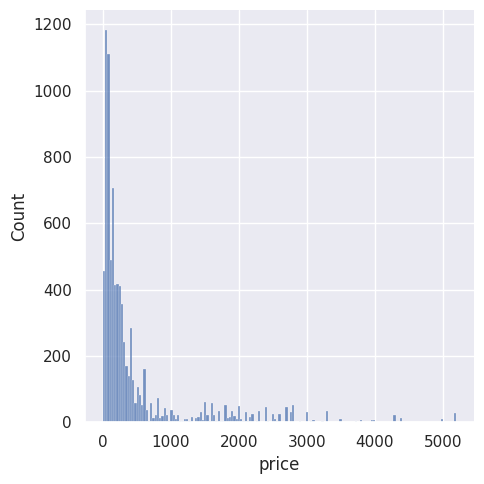

In [ ]:
sns.displot(df1['price'])

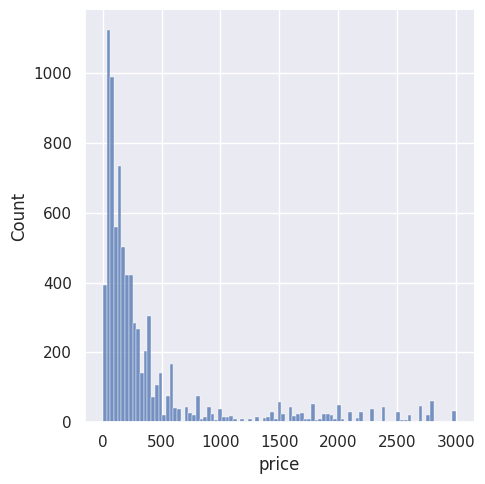

In [ ]:
aux = df1[df1['price'] < 3000]

sns.displot(aux['price'])

In [ ]:
print(df2[['date_imp_d']].min())

print(df2[['date_imp_d']].max())

date_imp_d   2017-01-24
dtype: datetime64[ns]
date_imp_d   2017-12-15
dtype: datetime64[ns]


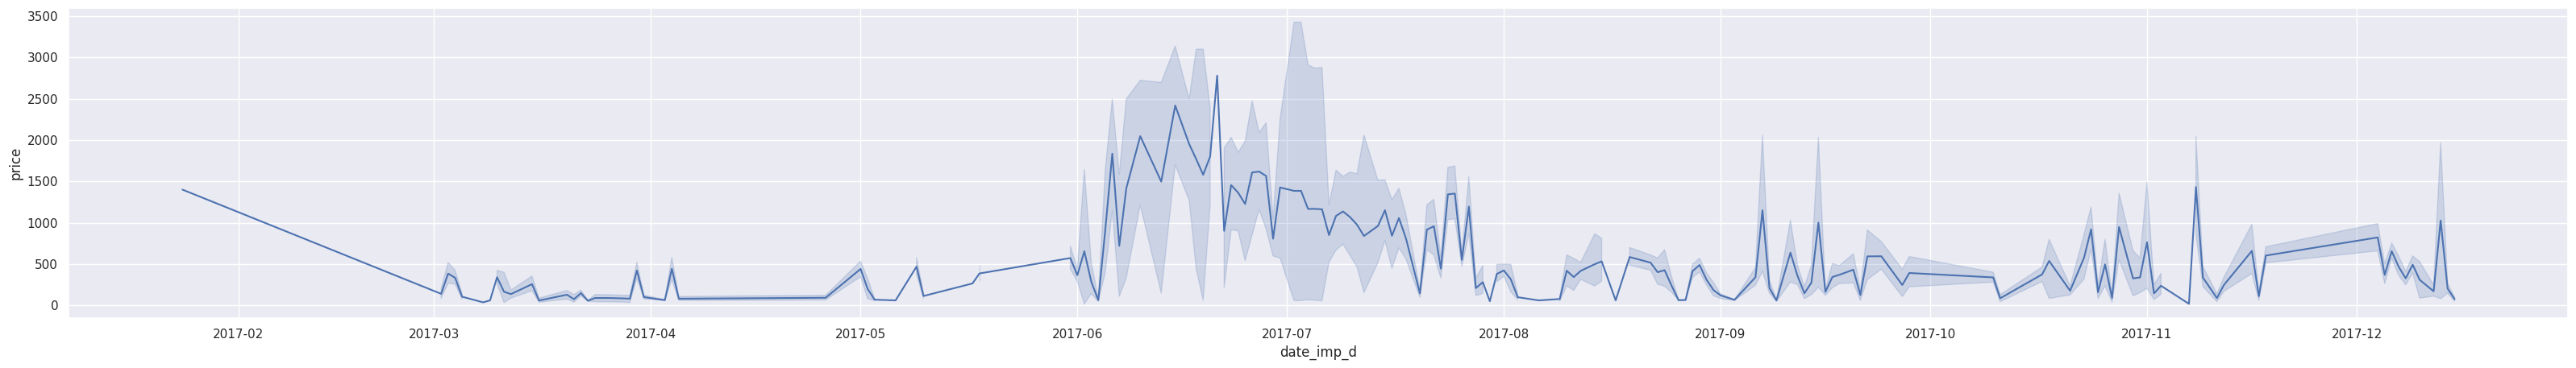

In [ ]:
plt.figure(figsize=(40, 5))
sns.lineplot(data=df2, x='date_imp_d', y='price')

# Exibir o gráfico
plt.show()

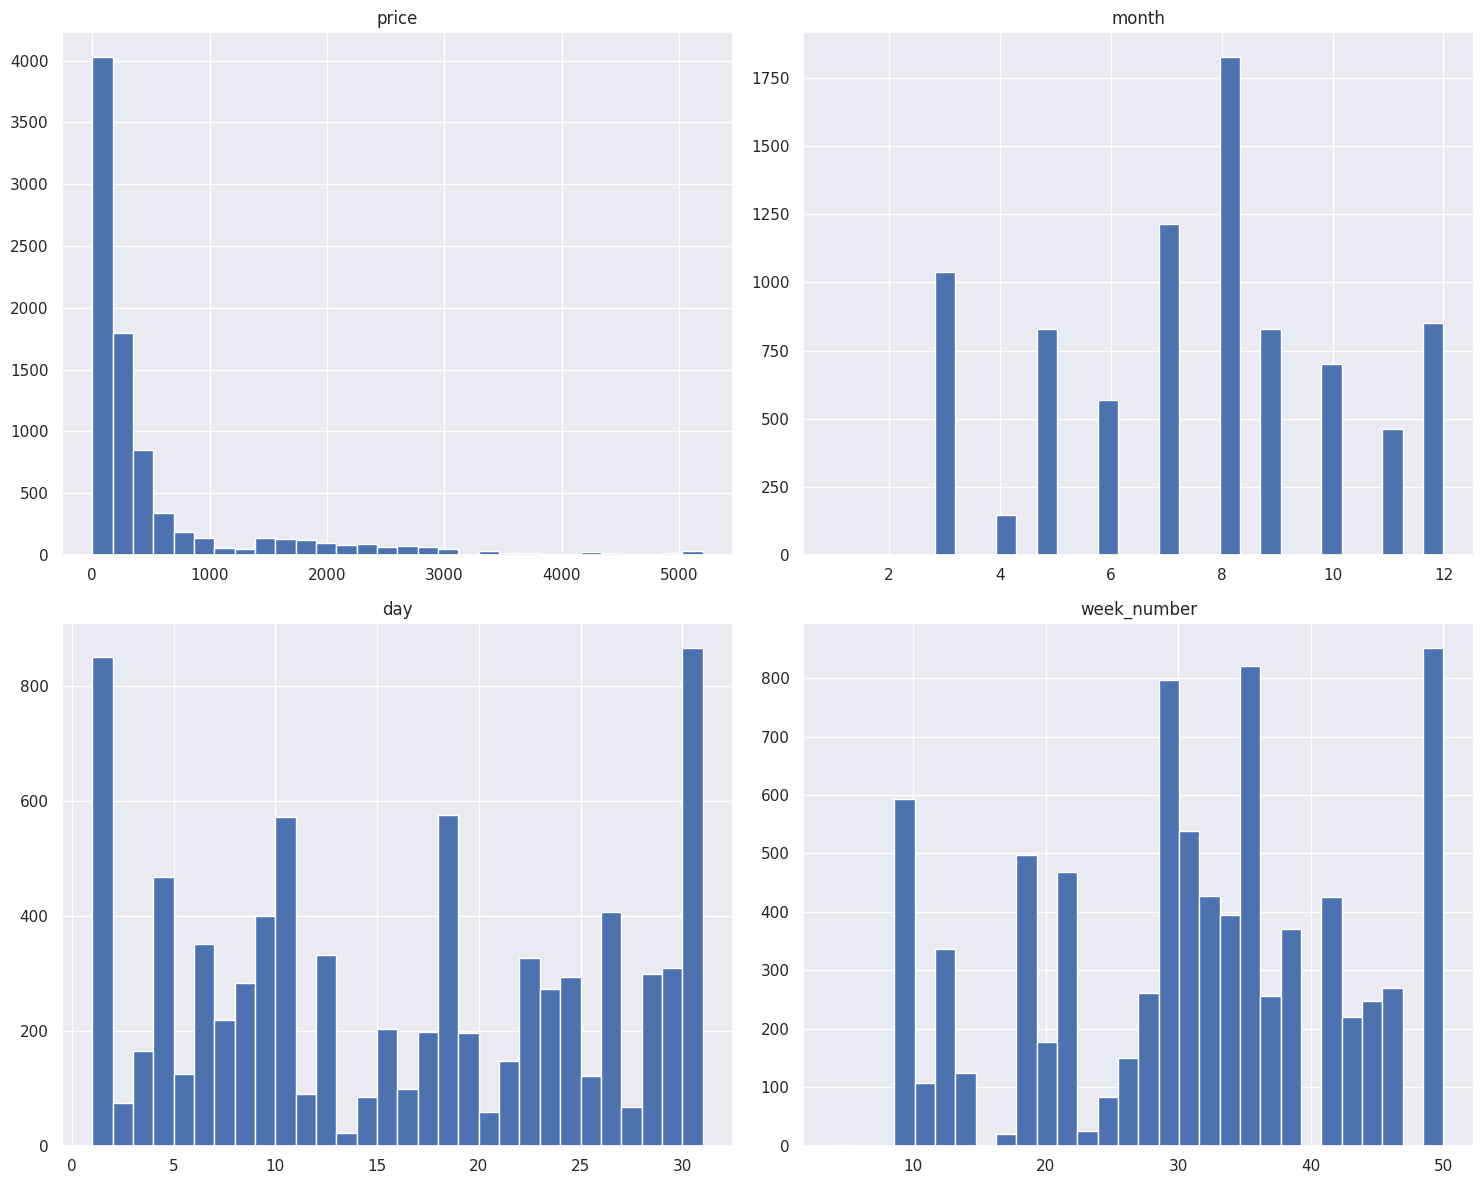

In [ ]:
num_attributes.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

In [ ]:
cat_attributes['brand'].value_counts()

brand
Samsung                        838
Sony                           787
Yamaha                         425
Apple                          399
Alpine                         197
Lenovo                         192
Logitech                       181
WD                             166
Seagate                        162
Pioneer                        148
CORSAIR                        145
Corsair                        138
Razer                          133
Dell                           129
LG                             128
JBL                            111
Onkyo                          101
SOL REPUBLIC                    97
Elite Screens                   93
Alienware                       91
ECOXGEAR                        90
Kenwood                         89
Canon                           88
SanDisk                         83
House of Marley                 79
Russound                        78
Sennheiser                      76
Denon                           74
Kanto Living                    68
Olympus                         66
Microsoft                       65
Lowepro                         63
Zoom                            58
Netgear                         56
Siriusxm                        54
Definitive Technology           54
Cooler Master                   53
Jensen                          53
Panasonic                       52
Kanto                           50
Pyle Pro                        50
TP-Link                         48
AOC                             45
RODE                            44
Boytone                         42
Sandisk                         41
Epson                           41
Mevo                            41
Jvcm                            41
Grace Digital                   40
Sanus                           40
Outdoor Tech                    40
Power Acoustik                  39
HP                              39
Monster                         37
Insignia™                       37
kate spade new york             36
Papago                          35
ASUS                            35
Universal Remote Control        34
MTX                             34
Manfrotto                       34
MSI                             33
Insignia                        31
Steelseries                     31
GEKO                            31
Belkin Inc.                     30
Actiontec                       29
Zmodo                           28
Kicker                          27
Sol Republic                    26
MEE audio                       26
MartinLogan                     26
Thule                           26
SKB                             26
Sharp                           25
Western Digital                 25
StarTech.com                    23
DENAQ                           23
Dual                            23
Bose®                           23
Peak Design                     23
Bower                           22
NETGEAR                         22
VisionTek                       22
Intel                           22
Jbl                             22
Sideclick                       21
Pny                             21
VIZIO                           21
Escort                          21
Retrak                          21
Belkin                          20
Kingston                        20
Silicondust                     20
ViewSonic                       20
CybertronPC                     19
iSimple                         19
Aluratek                        19
Sima                            18
XFX                             18
ZAGG                            18
PELICAN                         17
Leef                            17
mophie                          17
Polaroid                        16
Sdi Technologies, Inc.          16
Diamond Multimedia              16
Cerwin Vega                     16
Acer                            15
MTX Audio                       15
Niles                           15
Midland                         15
DreamWave                       15
Pana

In [ ]:
cat_attributes['category_name'].value_counts()

category_name
tv, television, video              810
laptop, computer                   504
drive, storage, internal           415
car, speaker, subwoofer            402
receiver, amplifier, home          374
speaker, portable, bluetooth       363
player, home, audio                316
drive, storage, hard               294
headphone, earbud, ear             236
speaker, wireless, audio           210
car, receiver, dash                201
speaker, audio, home               196
memory, computer, component        194
case, computer                     189
shelf, tabletop, audio             180
camera, shoot                      170
headphone                          152
mouse, keyboard                    143
sound, speaker, home               139
computer, charger, laptop          132
radio, portable, satellite         129
ipod, player                       123
desktop                            123
case, keyboard, tablet             119
power, battery, cell               119
speaker, subwoofer, separate       115
phone, cell                        114
headset, game, computer            111
monitor, computer                  111
networking, modem, router          104
projector, presentation, mount     103
speaker, center, channel           102
headphone, used, audio             100
camera, mirrorless, photo           97
adapter, networking, usb            94
screen, projector, projection       93
remote, control, tv                 92
card, memory, camera                90
car, camera, dash                   89
fan, cooling, computer              88
camera, bag                         86
security, surveillance, camera      81
lens, camera                        73
microphone, musical, instrument     71
mount, tv, stand                    62
keyboard, computer, mouse           53
camcorder, camera, action           49
camera, battery, charger            44
flash, camera                       34
switch, hub, networking             28
tripod, camera                      24
cable, tv, theater                  23
gps, navigation, car                22
radar, detector, vehicle            21
speaker, ceiling, wall              19
graphic, card, computer             18
surge, power                        15
tablet, ipad, computer               7
Name: count, dtype: int64

In [ ]:
df2['merchant'].value_counts()

merchant
Bestbuy.com         4609
bhphotovideo.com    1761
Walmart.com         1387
ebay.com             709
Name: count, dtype: int64

#### Bivariate Analysis

##### Visão Geral

Which merchant sold the most?

<Axes: xlabel='merchant', ylabel='qtd'>

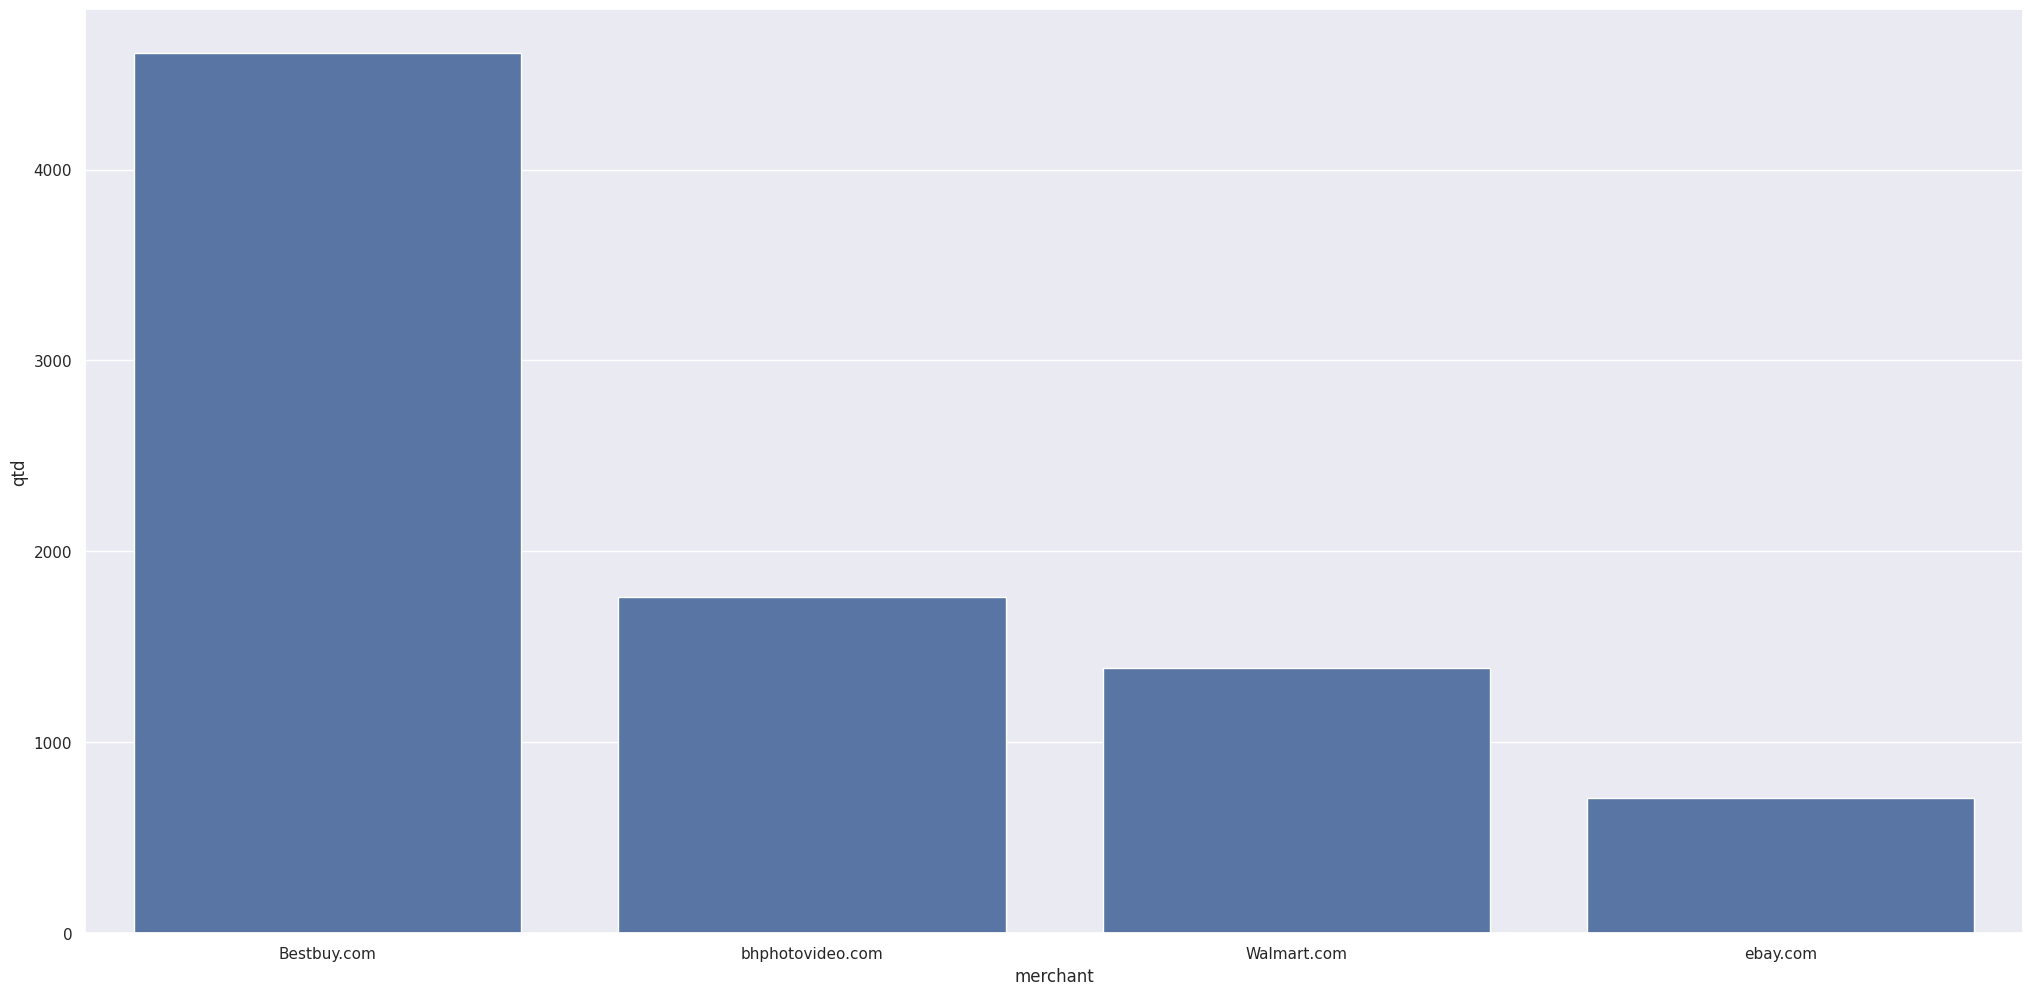

In [ ]:
columns = ['merchant', 'price']

aux = df2[columns].groupby(['merchant']).count().reset_index()

aux.columns = ['merchant', 'qtd']

aux = aux.sort_values(by='qtd', ascending=False)

sns.barplot(data=aux, x='merchant', y='qtd')

Best-selling category of products in overall

<Axes: xlabel='category_name', ylabel='price'>

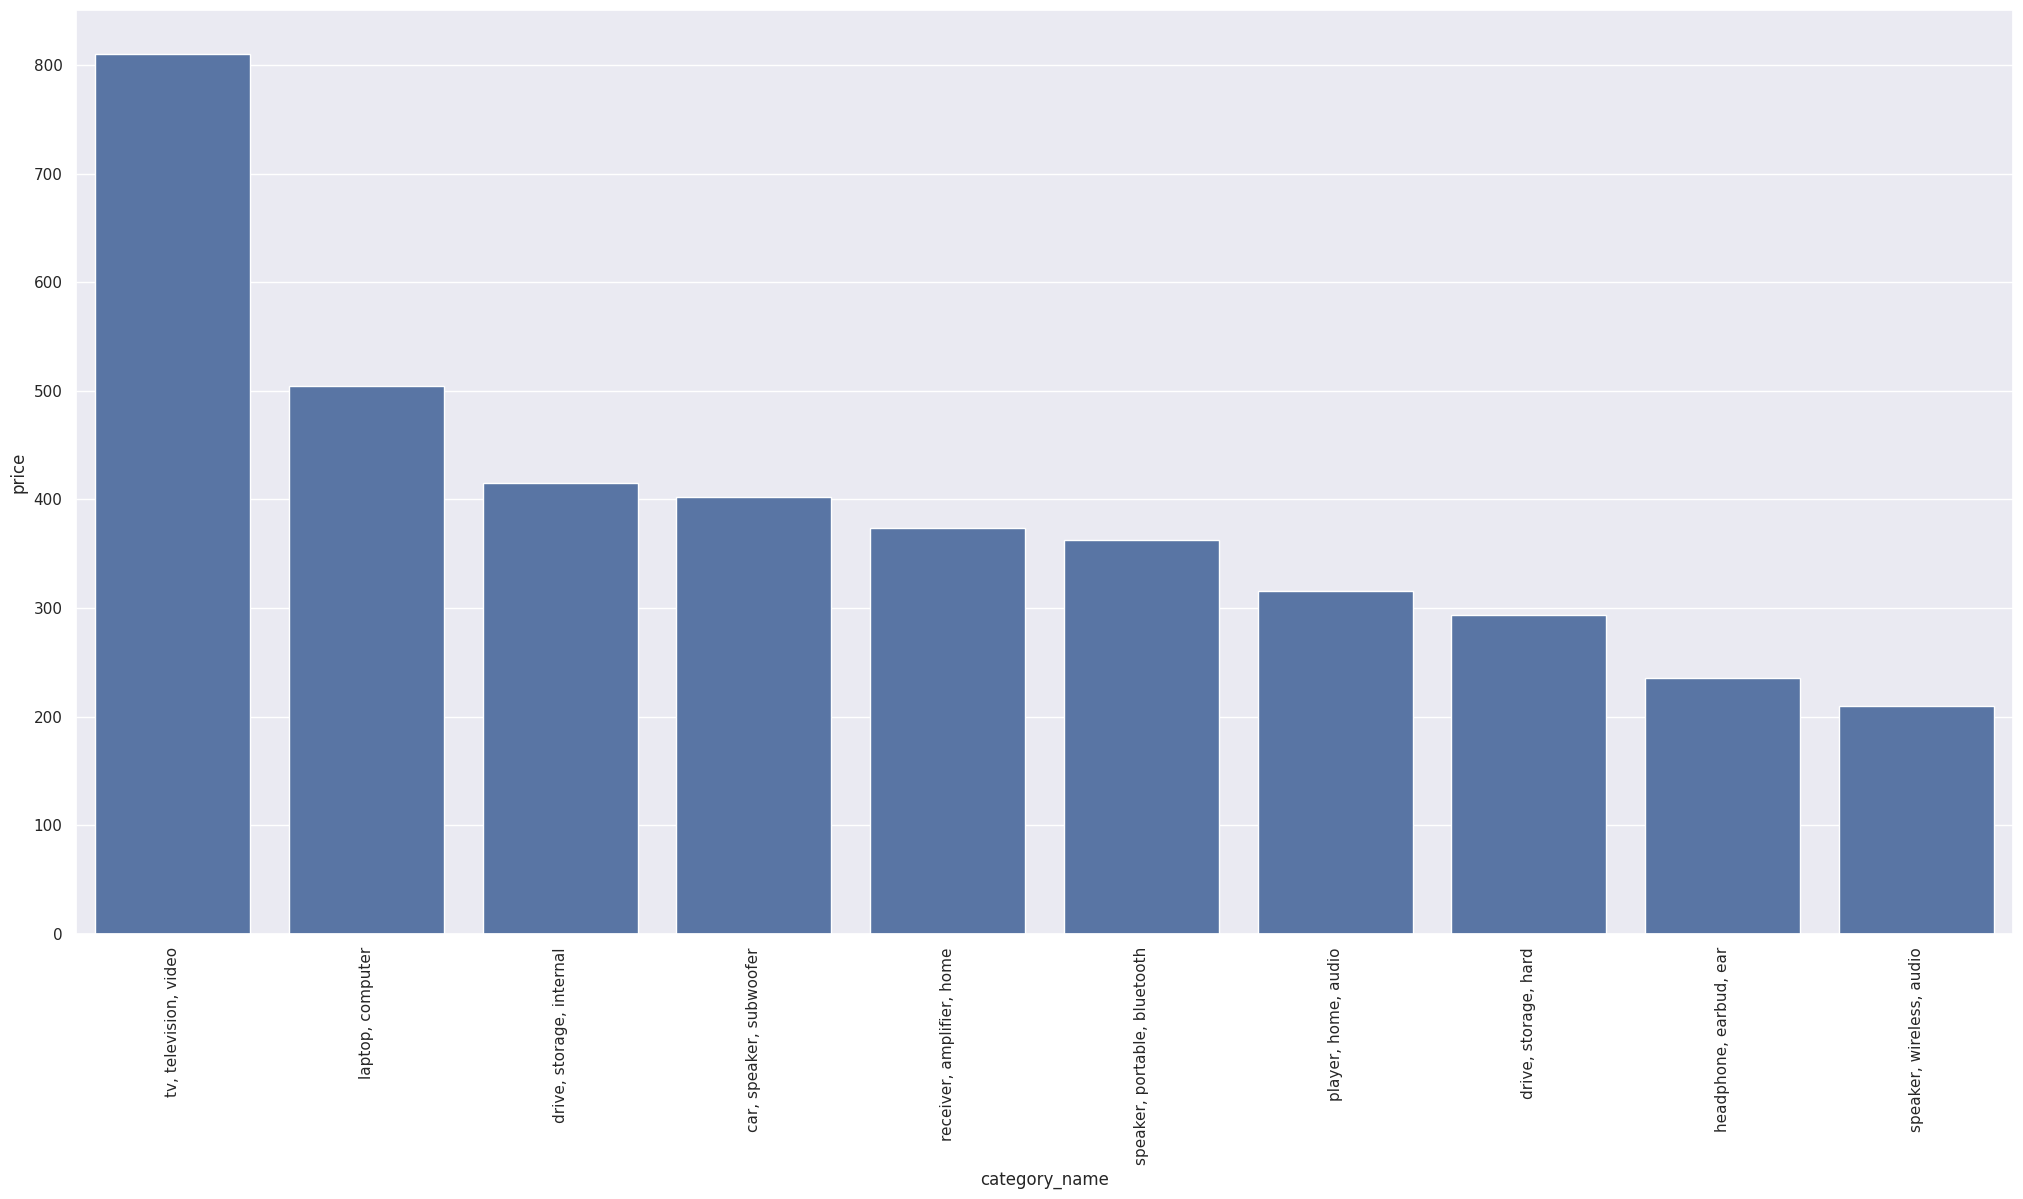

In [ ]:
columns = ['category_name','price']

aux = df2[columns].groupby('category_name').count().reset_index()
plt.xticks(rotation=90)
sns.barplot(data = aux.sort_values(by='price', ascending=False).head(10), x='category_name', y='price')

For this EDA, we considered the four major merchants in terms of price variation.

In [ ]:
stores = ['Bestbuy.com', 'bhphotovideo.com', 'Walmart.com', 'ebay.com']

df_bestbuy = filter_by_merchant(df2, stores[0])
df_bhphoto = filter_by_merchant(df2, stores[1])
df_walmart = filter_by_merchant(df2, stores[2])
df_ebay = filter_by_merchant(df2, stores[3])

##### BestBuy

Best-selling category of products

In [ ]:
columns = ['category_name', 'name']

aux = df_bestbuy[columns].groupby('category_name').count().reset_index()

aux = aux.rename(columns={'name': 'qtd_product'}).sort_values(by='qtd_product', ascending=False)

aux.head(10)

category_name  qtd_product
27              laptop, computer          373
50  speaker, portable, bluetooth          291
9        car, speaker, subwoofer          267
41     receiver, amplifier, home          247
22        headphone, earbud, ear          171
16      drive, storage, internal          158
47          speaker, audio, home          151
45        shelf, tabletop, audio          147
29   memory, computer, component          146
56         tv, television, video          143

What is the best-selling product?

In [ ]:
columns = ['name', 'price']

aux = df_bestbuy[columns].groupby('name').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value', 'name': 'Product'}).sort_values(by='Total Value', ascending=False)

aux.head(10)

Product  Total Value
4    15.4 MacBook Pro with Touch Bar (Late 2016, Sp...           84
150  Logitech Keys-To-Go Ultra-Portable Bluetooth K...           53
29   Alpine - 6-1/2 2-Way Component Car Speakers wi...           40
232  Seagate - Backup Plus 5TB External USB 3.0 Por...           40
179        Outdoor Tech Buckshot Pro Bluetooth Speaker           40
127  Jensen174 Portable 3-Speed Stereo Turntable Wi...           40
2       128GB iPod touch (Space Gray) (6th Generation)           39
119  Insignia™ - Battery Charger for Acer, HP and S...           37
37   Apple MD825AM/A Lightning to VGA Adapter for i...           36
288  kate spade new york - Glitter Sleeve for 13 Ap...           36

What is the best-selling brand?

In [ ]:
columns = ['brand', 'price']

aux = df_bestbuy[columns].groupby('brand').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value'}).sort_values(by='Total Value', ascending=False)

aux.head(10)

brand  Total Value
125    Yamaha          307
111      Sony          302
7       Apple          284
97    Samsung          227
5      Alpine          167
58   Logitech          156
57     Lenovo          145
25       Dell           99
92      Razer           96
15    CORSAIR           95

Which days, months, and weeks had the highest sales?



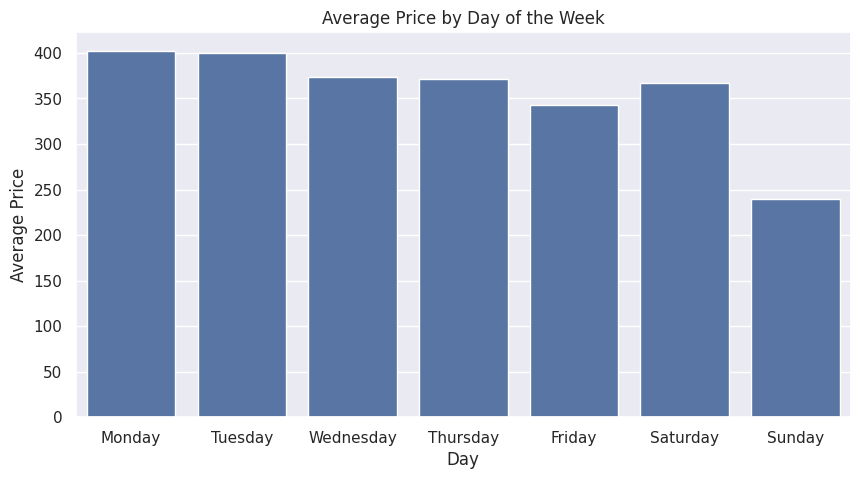

In [ ]:
aux = df_bestbuy.groupby('day_n')['price'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=aux, x='day_n', y='price', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Price by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Price')
plt.show()

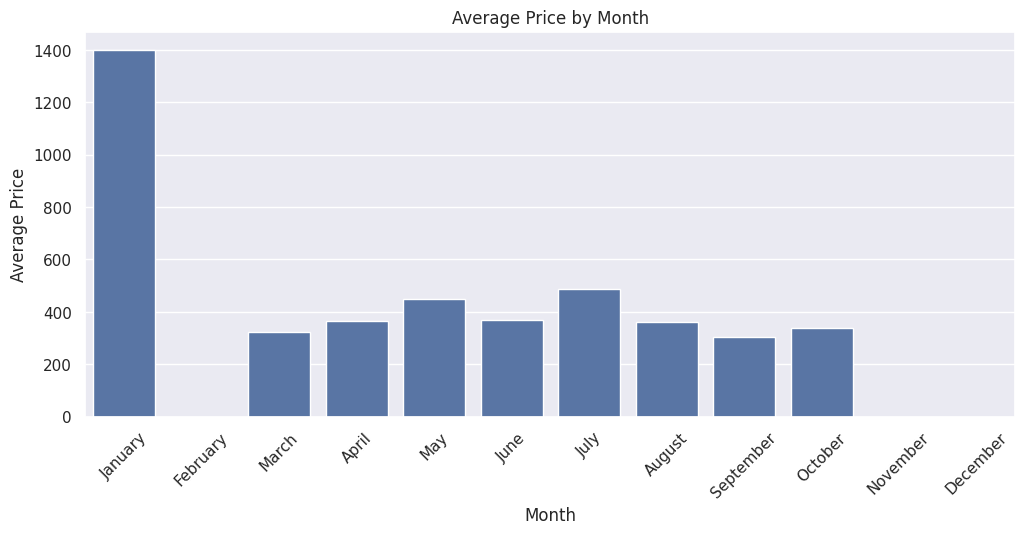

In [ ]:
aux = df_bestbuy.groupby('month_n')['price'].mean().reset_index()

order_months = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 5))
sns.barplot(data=aux, x='month_n', y='price', order=order_months)
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

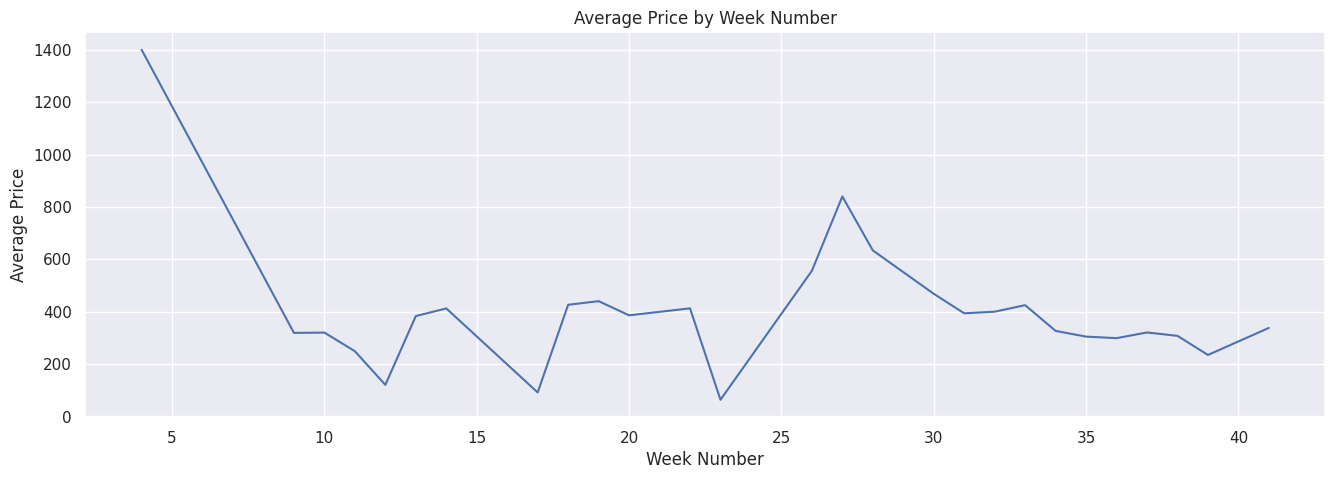

In [ ]:
aux = df_bestbuy.groupby('week_number')['price'].mean().reset_index()

plt.figure(figsize=(16, 5))
sns.lineplot(data=aux, x='week_number', y='price')
plt.title('Average Price by Week Number')
plt.xlabel('Week Number')
plt.ylabel('Average Price')
plt.show()

Weekly average price of the best-selling product

In [ ]:
df_bestbuy['name'].value_counts().sort_values(ascending=False).head(10)

name
15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)                                  84
Logitech Keys-To-Go Ultra-Portable Bluetooth Keyboard for Android and Windows            53
Outdoor Tech Buckshot Pro Bluetooth Speaker                                              40
Seagate - Backup Plus 5TB External USB 3.0 Portable Hard Drive - silver                  40
Jensen174 Portable 3-Speed Stereo Turntable With Built-In Speakers - Black (jta-410 )    40
Alpine - 6-1/2 2-Way Component Car Speakers with Poly-Mica Cones (Pair) - Black"         40
128GB iPod touch (Space Gray) (6th Generation)                                           39
Insignia™ - Battery Charger for Acer, HP and Samsung Chromebooks - Black                 37
Apple MD825AM/A Lightning to VGA Adapter for iPhones                                     36
kate spade new york - Glitter Sleeve for 13 Apple® MacBook® - Rose Gold"                 36
Name: count, dtype: int64

<Axes: xlabel='week_number', ylabel='price'>

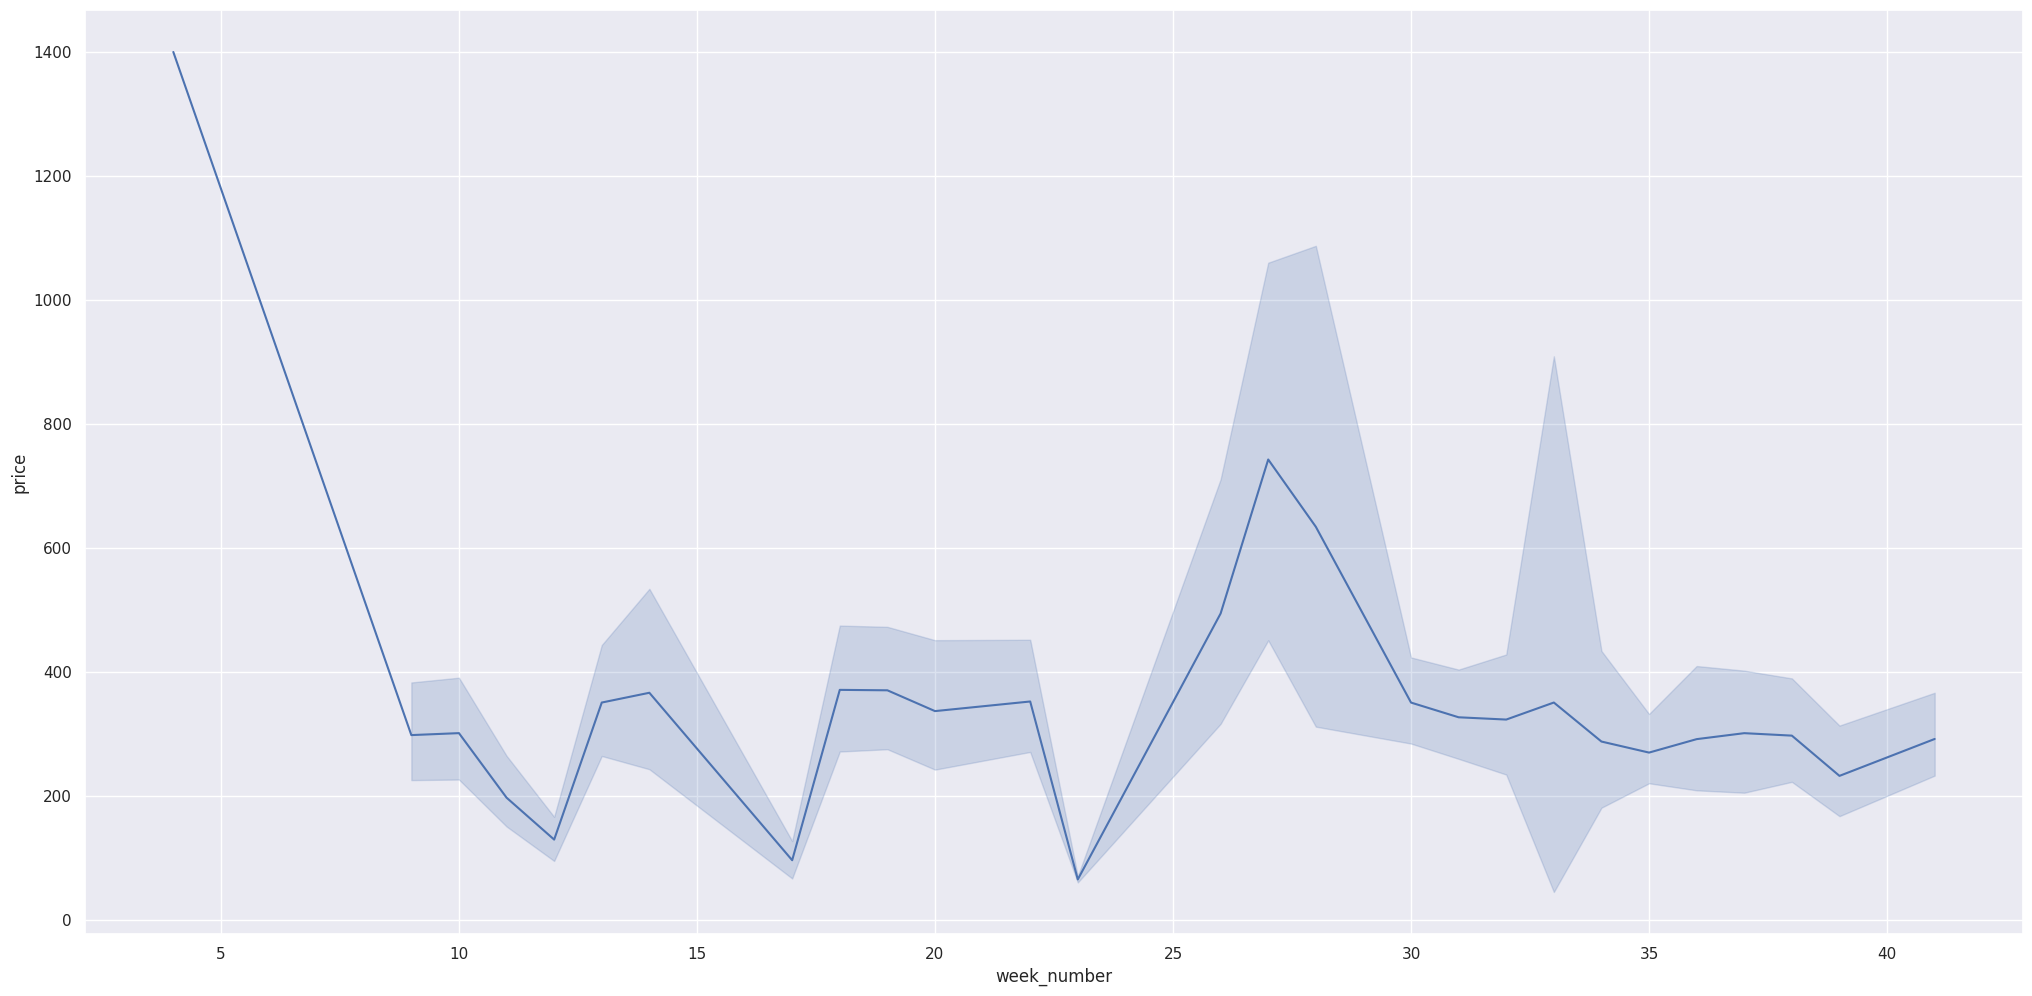

In [ ]:
aux = df_bestbuy[df_bestbuy['name'] == '15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)']

aux = df_bestbuy.groupby(['name', 'week_number'])['price'].mean().reset_index()

sns.lineplot(aux, x='week_number', y='price')

Group prices over time

<Axes: >

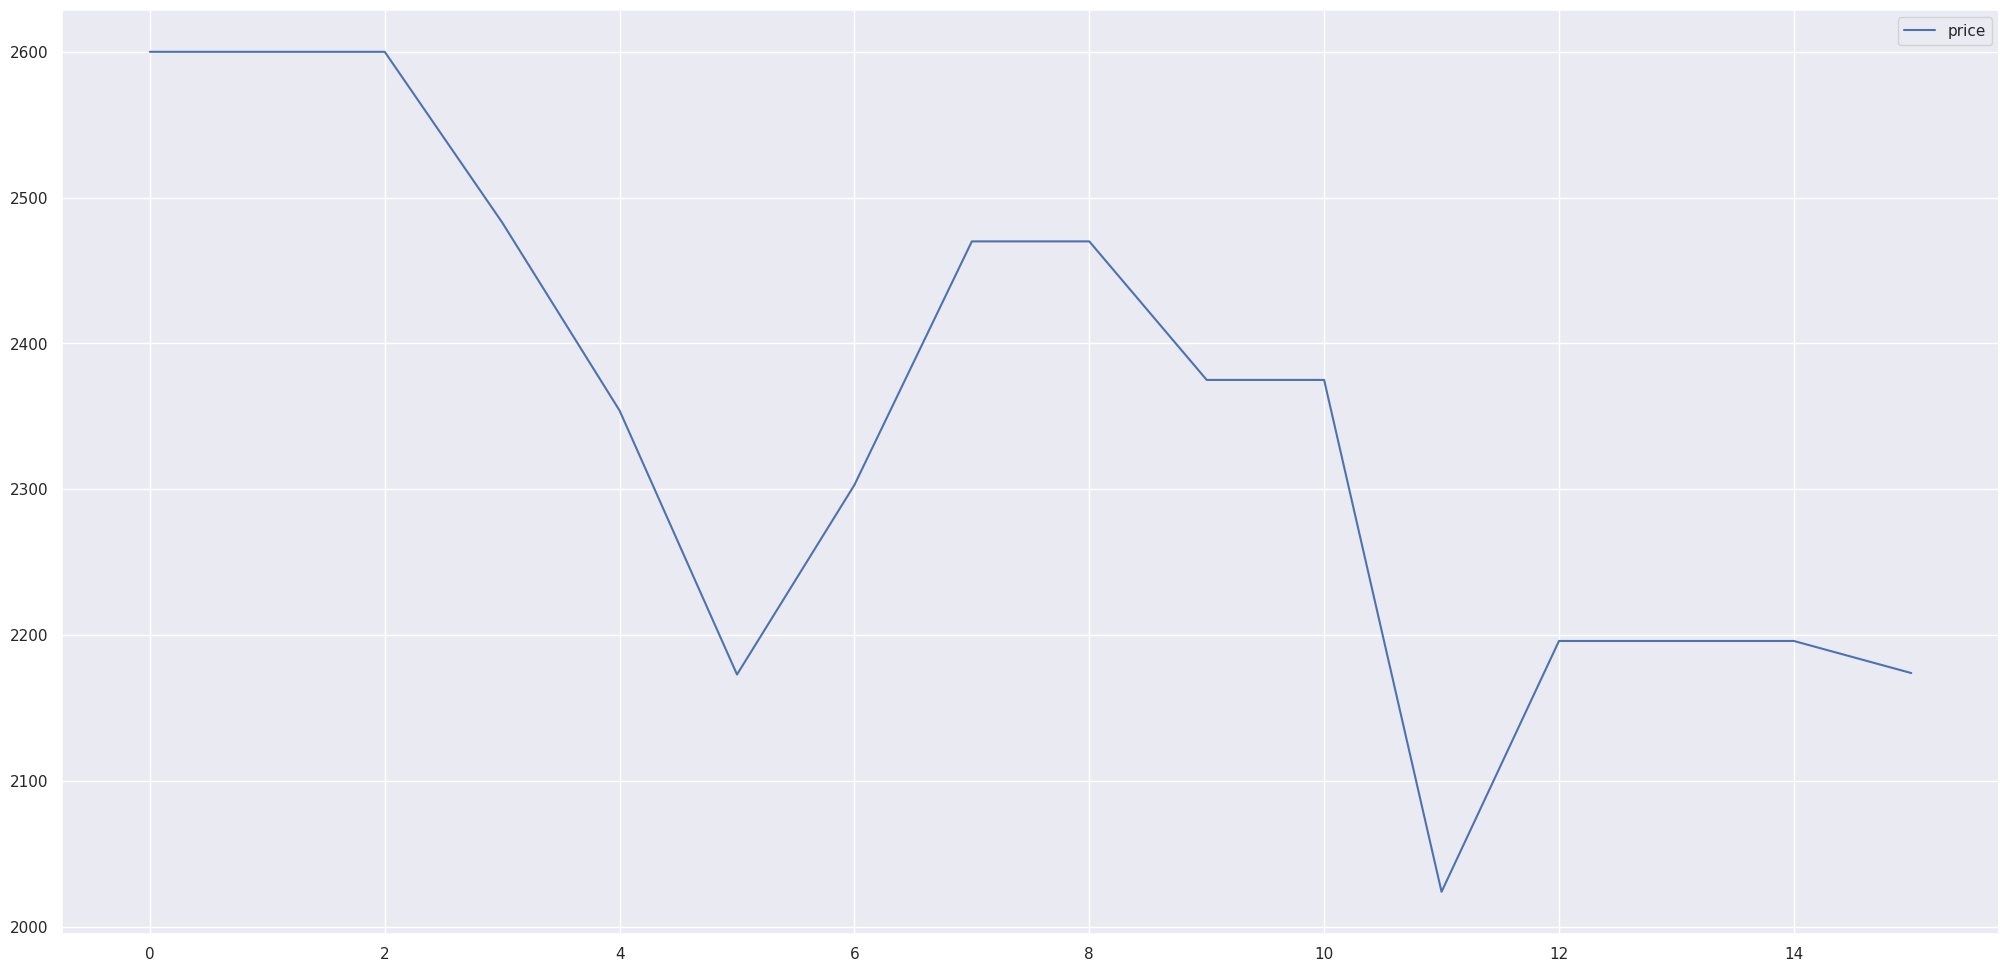

In [ ]:
aux = df_bestbuy[df_bestbuy['name'] == '15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)']

aux = aux.groupby('date_imp_d')['price'].mean().reset_index()

sns.lineplot(aux)

##### Bh Photo Video

Best-selling category

<Axes: xlabel='category_name', ylabel='qtd_product'>

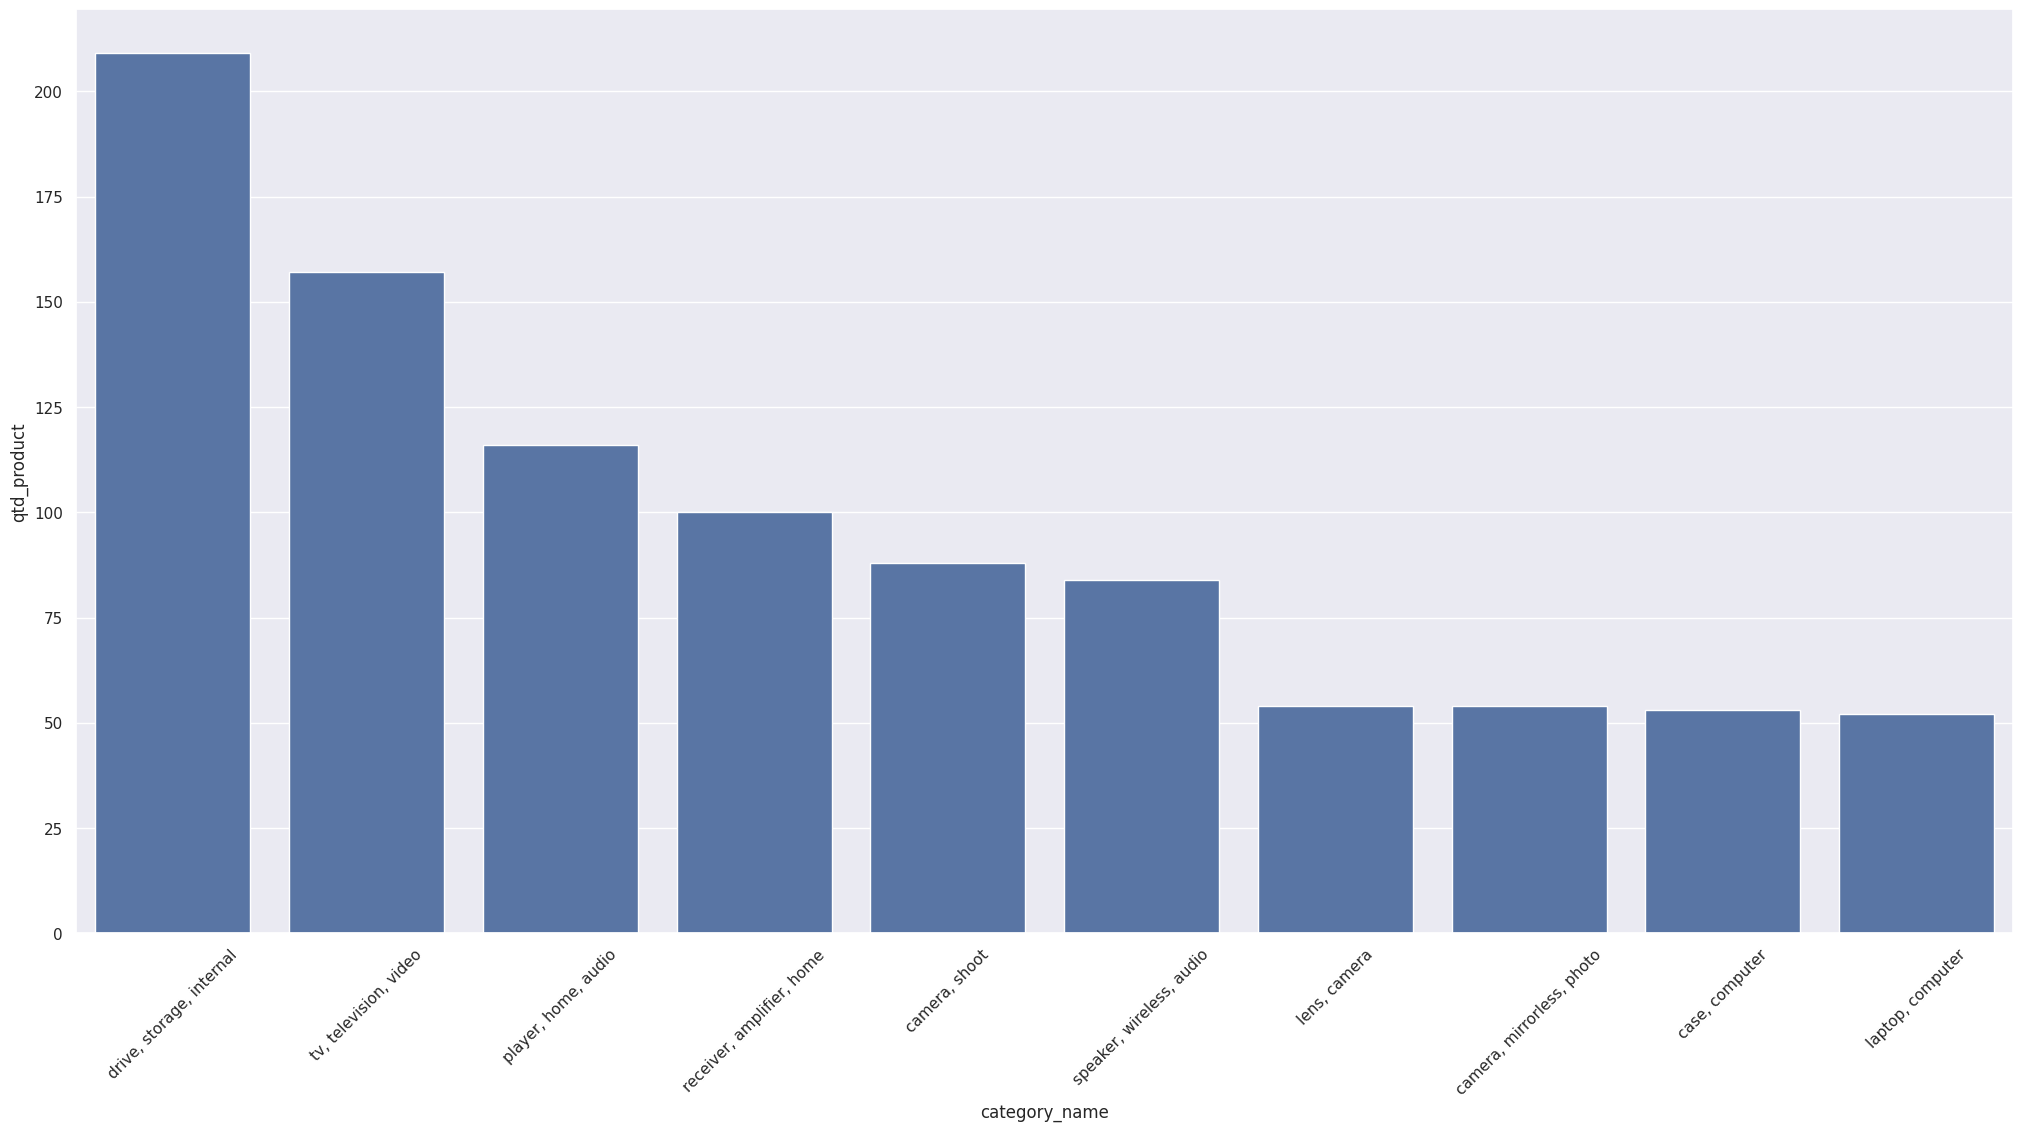

In [ ]:
columns = ['category_name', 'name']

aux = df_bhphoto[columns].groupby('category_name').count().reset_index()

aux = aux.rename(columns={'name': 'qtd_product'}).sort_values(by='qtd_product', ascending=False)

plt.xticks(rotation=45)

sns.barplot(data=aux.head(10), x='category_name', y='qtd_product')

In [ ]:
aux.head(10)

category_name  qtd_product
12   drive, storage, internal          209
43      tv, television, video          157
28        player, home, audio          116
31  receiver, amplifier, home          100
5               camera, shoot           88
39   speaker, wireless, audio           84
20               lens, camera           54
4   camera, mirrorless, photo           54
8              case, computer           53
19           laptop, computer           52

What is the best-selling product?

In [ ]:
columns = ['name', 'price']

aux = df_bhphoto[columns].groupby('name').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value', 'name': 'Product'}).sort_values(by='Total Value', ascending=False)

aux.head(10)

Product  Total Value
10   4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...           58
52   H6 Handy Recorder Kit with Resident Audio R100...           58
90            RODE - NTG1 Condenser Shotgun Microphone           44
86    PowerShot G5 X Digital Camera Free Accessory Kit           40
3    15.4 MacBook Pro with Touch Bar (Late 2016, Sp...           36
79      Olympus TG-5 Waterproof Camera with 3-Inch LCD           34
65   Lumix DMC-G7 Mirrorless Micro Four Thirds Digi...           32
134    UBD-M9500 HDR UHD Upscaling Blu-ray Disc Player           25
50                        Gear 360 Spherical VR Camera           22
146  Yamaha - AVENTAGE 7.2-Ch. 4K Ultra HD A/V Home...           22

What is the best-selling brand?

<Axes: xlabel='brand', ylabel='Total Value'>

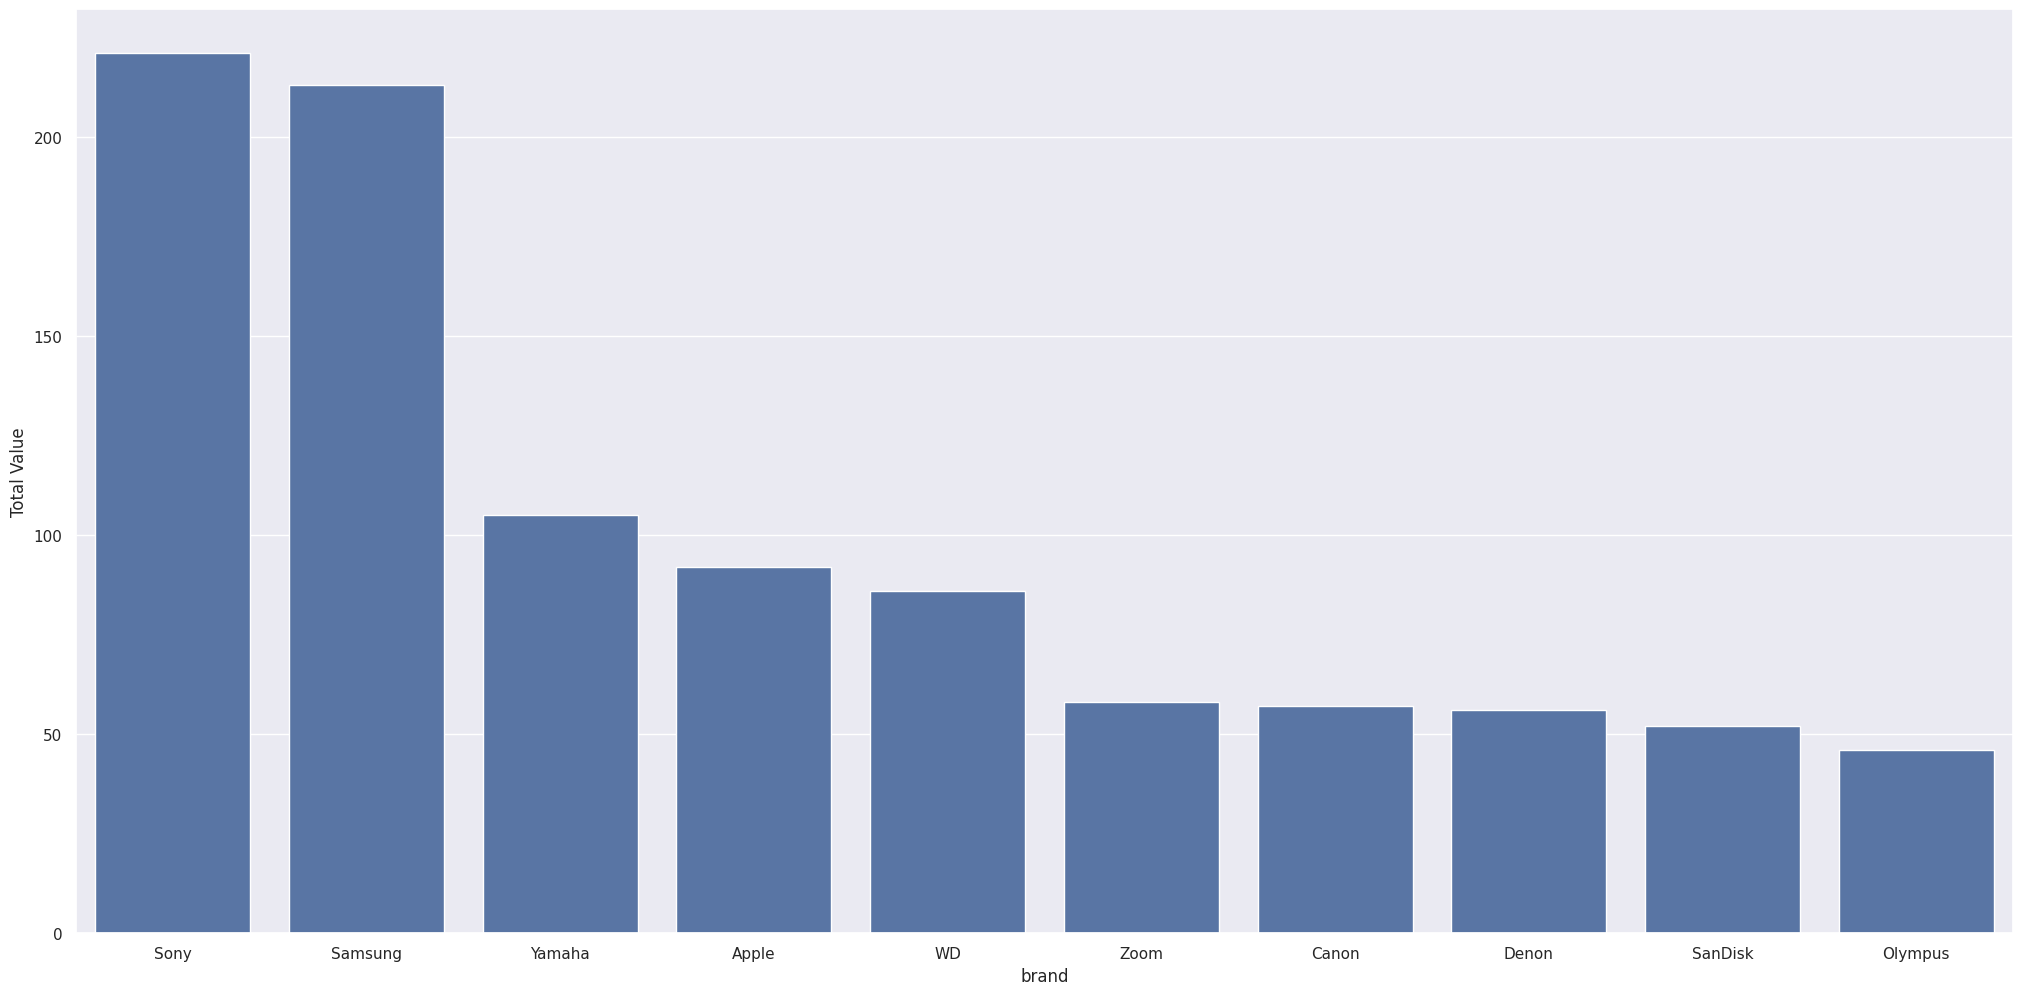

In [ ]:
columns = ['brand', 'price']

aux = df_bhphoto[columns].groupby('brand').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value'}).sort_values(by='Total Value', ascending=False)

sns.barplot(data=aux.head(10), x='brand', y='Total Value')

Which days, months, and weeks had the highest sales?


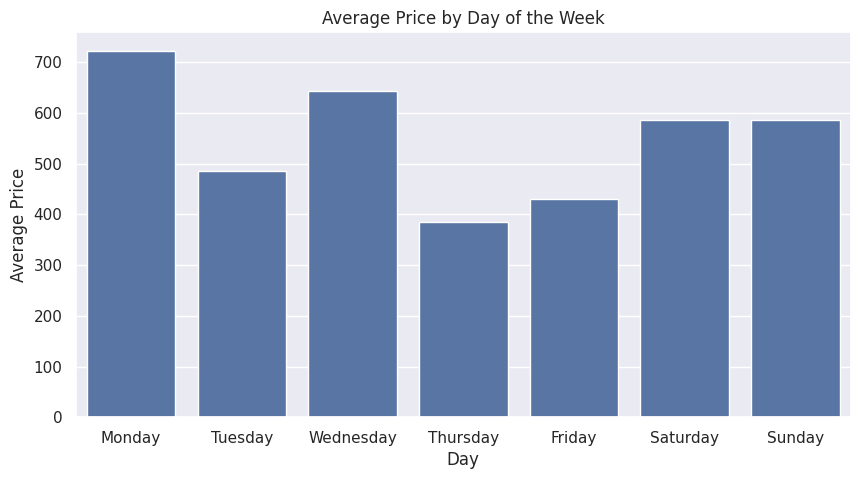

In [ ]:
aux = df_bhphoto.groupby('day_n')['price'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=aux, x='day_n', y='price', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Price by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Price')
plt.show()

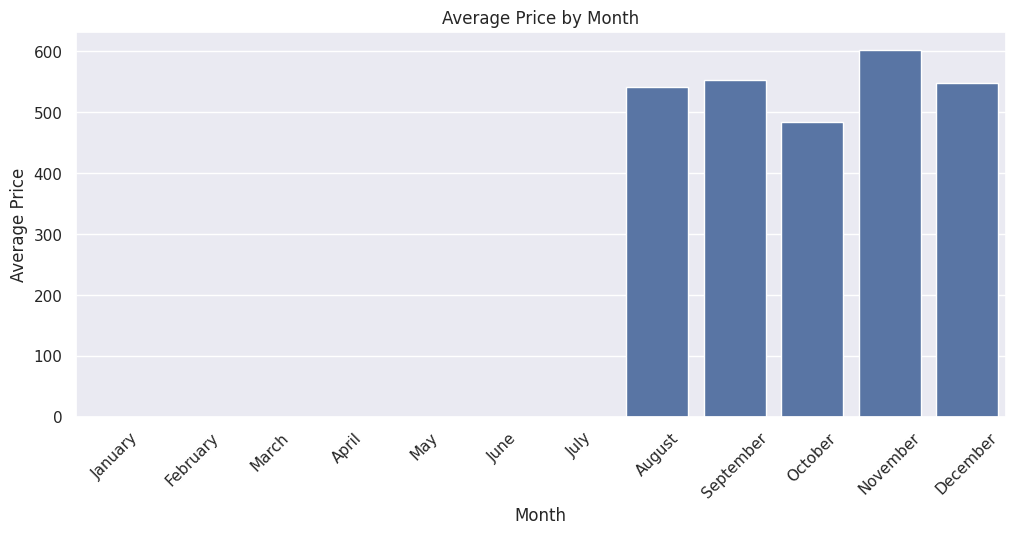

In [ ]:
aux = df_bhphoto.groupby('month_n')['price'].mean().reset_index()

order_months = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 5))
sns.barplot(data=aux, x='month_n', y='price', order=order_months)
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

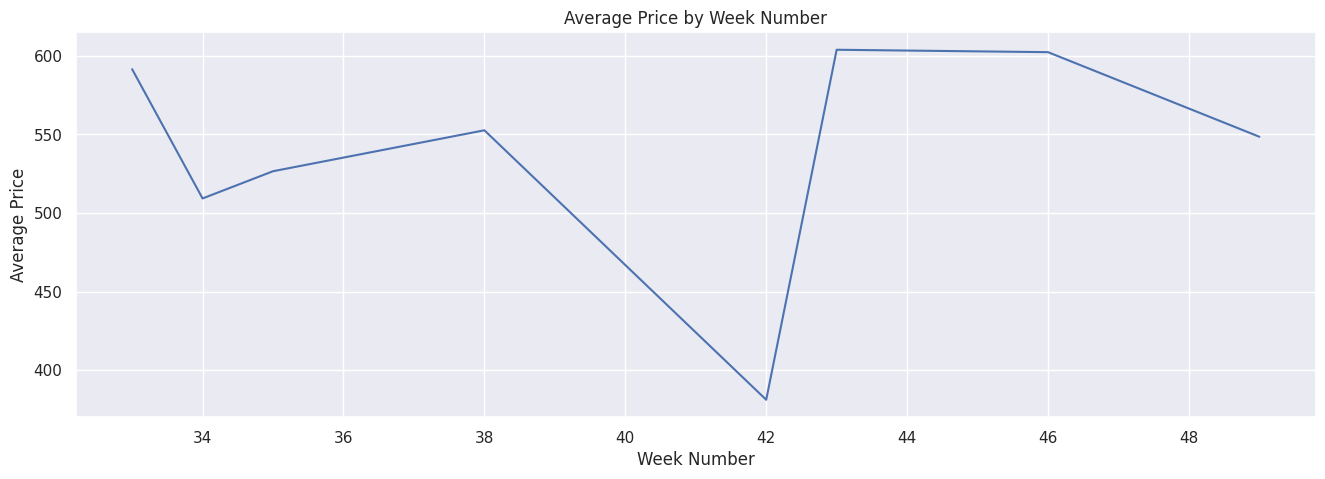

In [ ]:
aux = df_bhphoto.groupby('week_number')['price'].mean().reset_index()

plt.figure(figsize=(16, 5))
sns.lineplot(data=aux, x='week_number', y='price')
plt.title('Average Price by Week Number')
plt.xlabel('Week Number')
plt.ylabel('Average Price')
plt.show()

Weekly average price of the best-selling product

In [ ]:
df_bhphoto['name'].value_counts().sort_values(ascending=False).head(10)

name
4TB Network OEM HDD Retail Kit (8-Pack, WD40EFRX, Red Drives)                                           58
H6 Handy Recorder Kit with Resident Audio R100 Headphones                                               58
RODE - NTG1 Condenser Shotgun Microphone                                                                44
PowerShot G5 X Digital Camera Free Accessory Kit                                                        40
15.4 MacBook Pro with Touch Bar (Late 2016, Space Gray)                                                 36
Olympus TG-5 Waterproof Camera with 3-Inch LCD                                                          34
Lumix DMC-G7 Mirrorless Micro Four Thirds Digital Camera with 14-42mm Lens and Accessory Kit (Black)    32
UBD-M9500 HDR UHD Upscaling Blu-ray Disc Player                                                         25
Yamaha - AVENTAGE 7.2-Ch. 4K Ultra HD A/V Home Theater Receiver - Black                                 22
Gear 360 Spherical VR Camera                                                                            22
Name: count, dtype: int64

<Axes: xlabel='week_number', ylabel='price'>

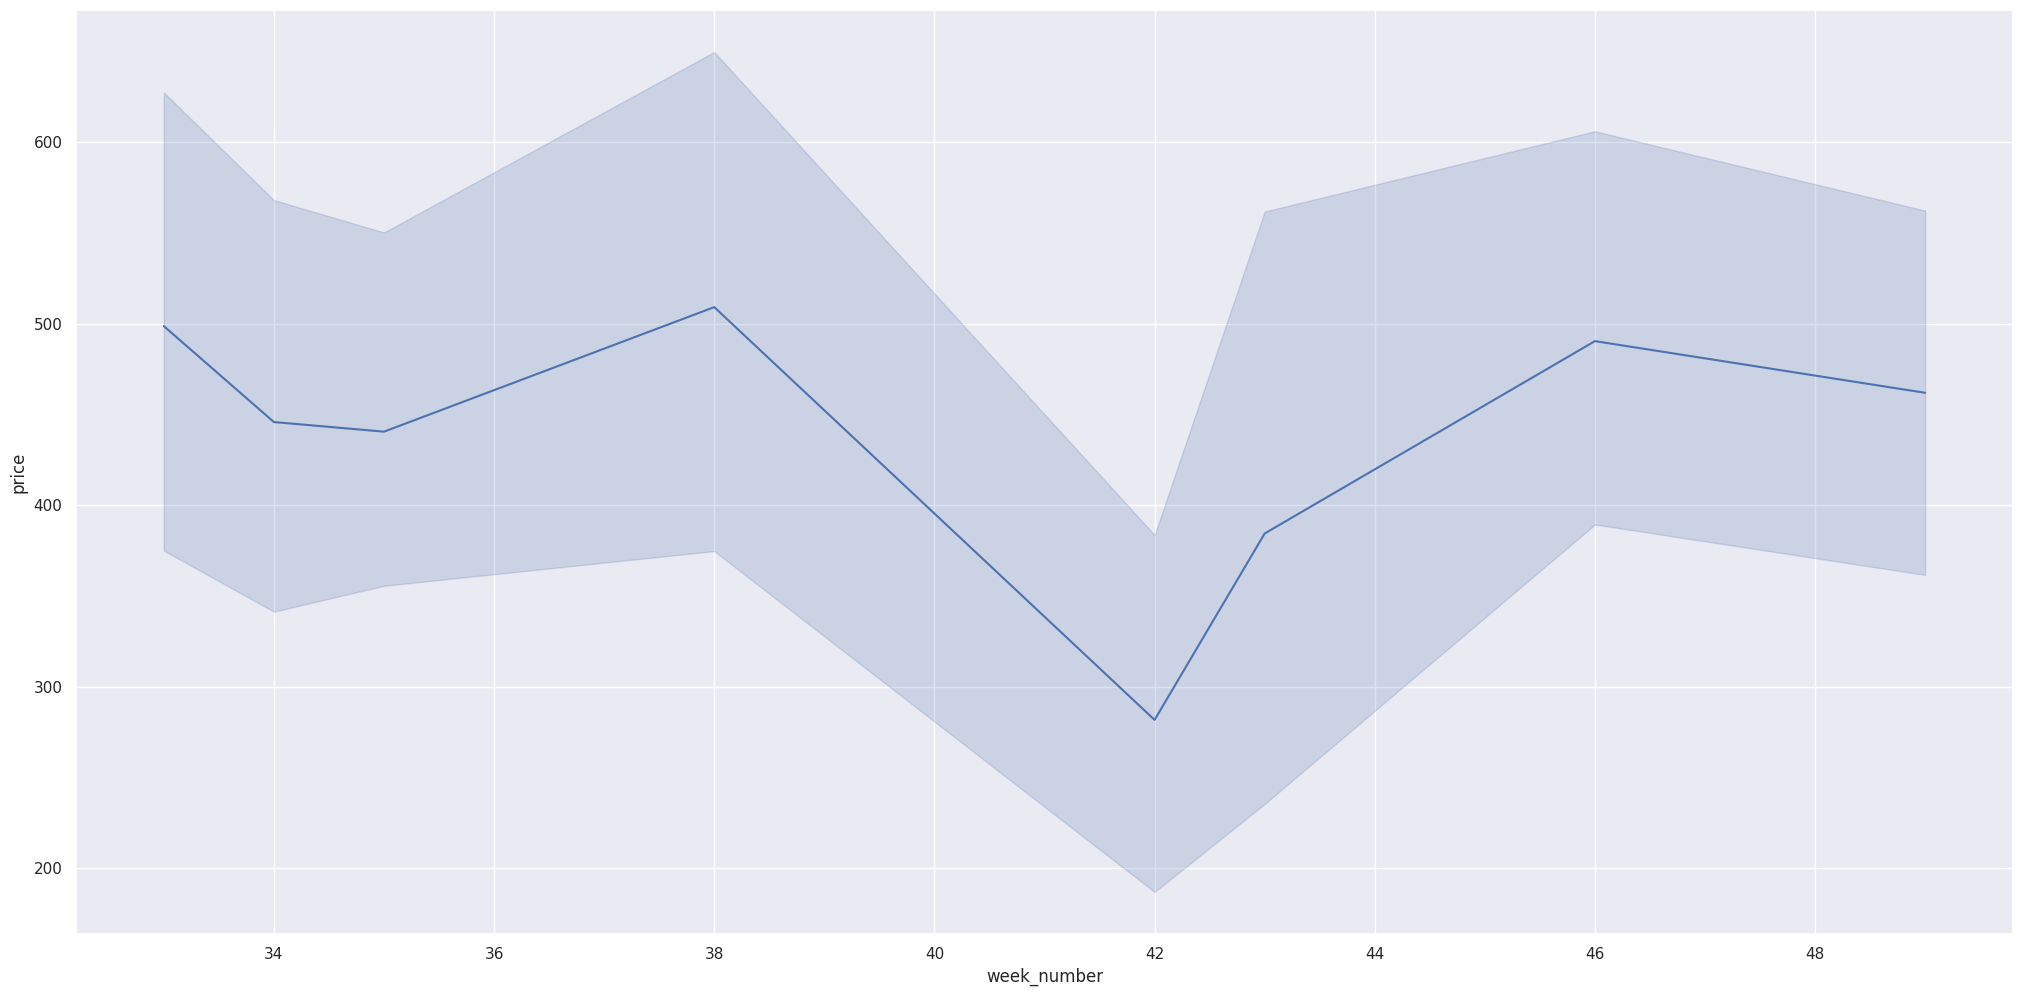

In [ ]:
aux = df_bhphoto[df_bhphoto['name'] == 'Alpha a7S II Mirrorless Digital Camera Body with Accessories Kit']

aux = df_bhphoto.groupby(['name', 'week_number'])['price'].mean().reset_index()

sns.lineplot(aux, x='week_number', y='price')

Group prices over time

<Axes: >

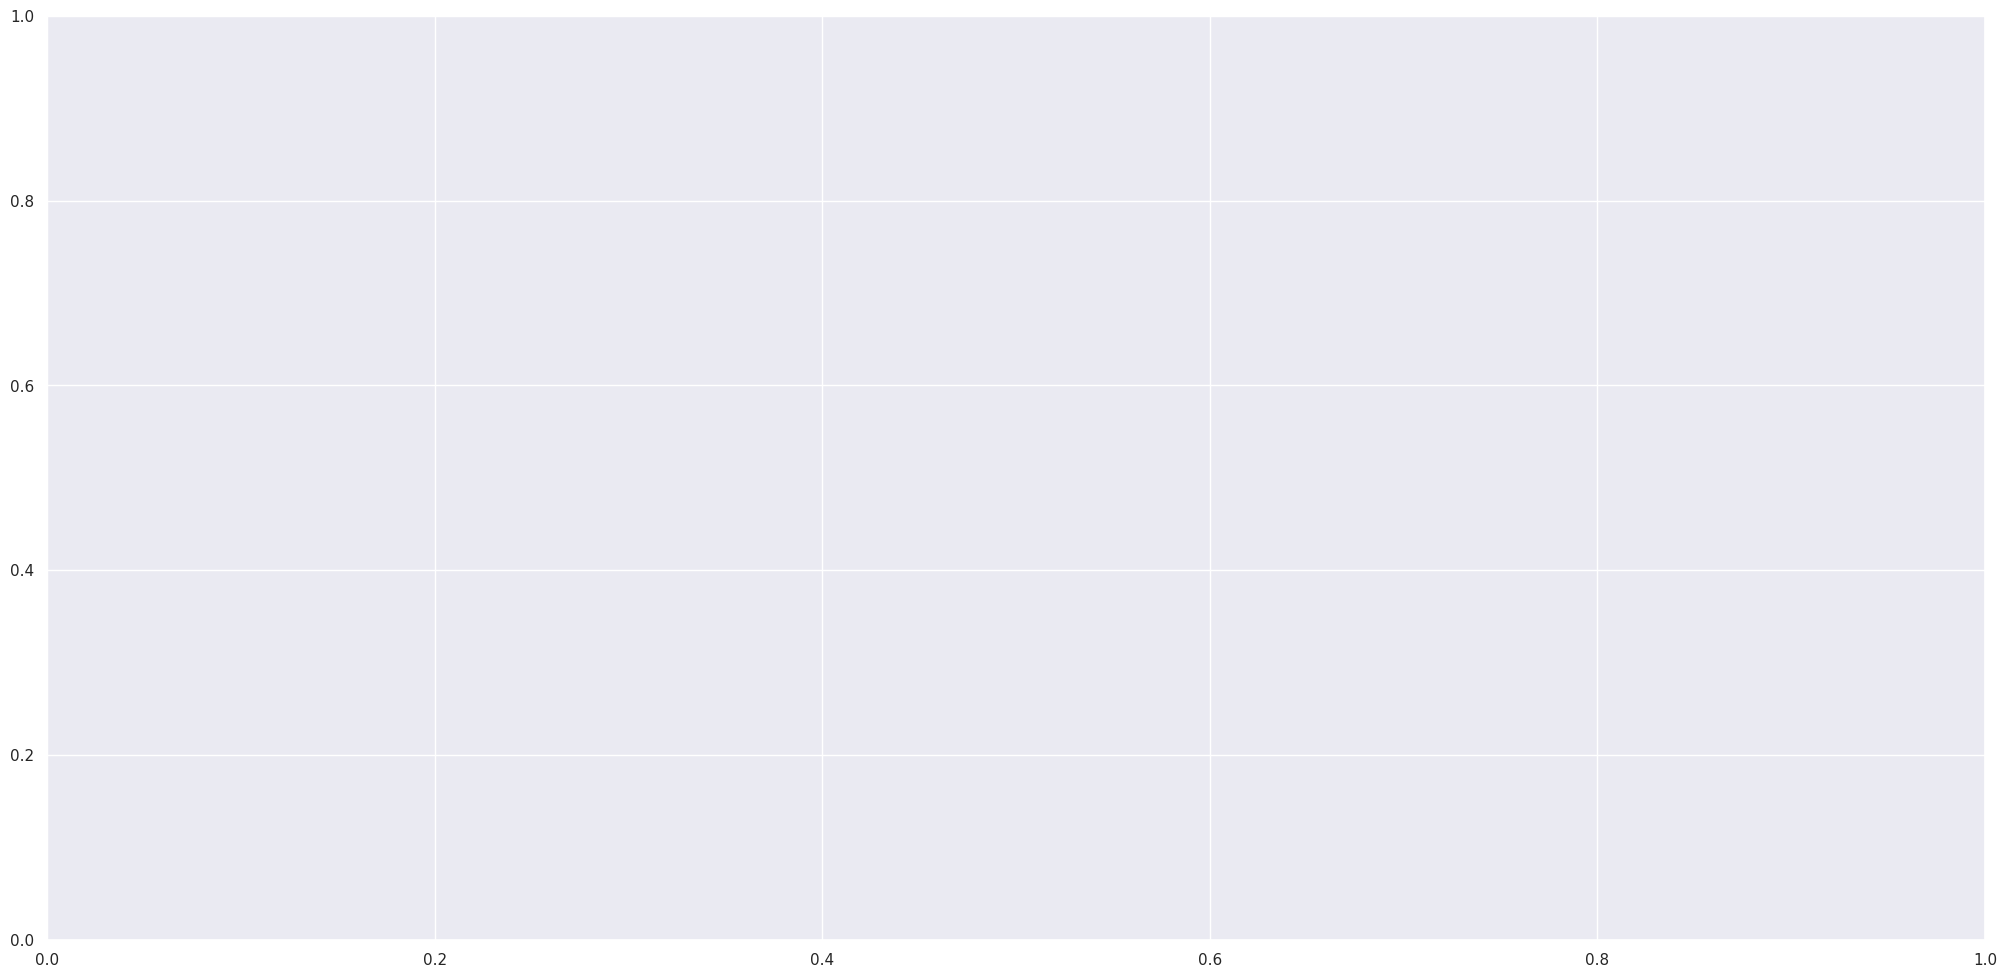

In [ ]:
aux = df_bhphoto[df_bhphoto['name'] == 'Alpha a7S II Mirrorless Digital Camera Body with Accessories Kit']

aux = aux.groupby('date_imp_d')['price'].mean().reset_index()

sns.lineplot(aux)

##### Walmart

Best-selling category

<Axes: xlabel='category_name', ylabel='qtd_product'>

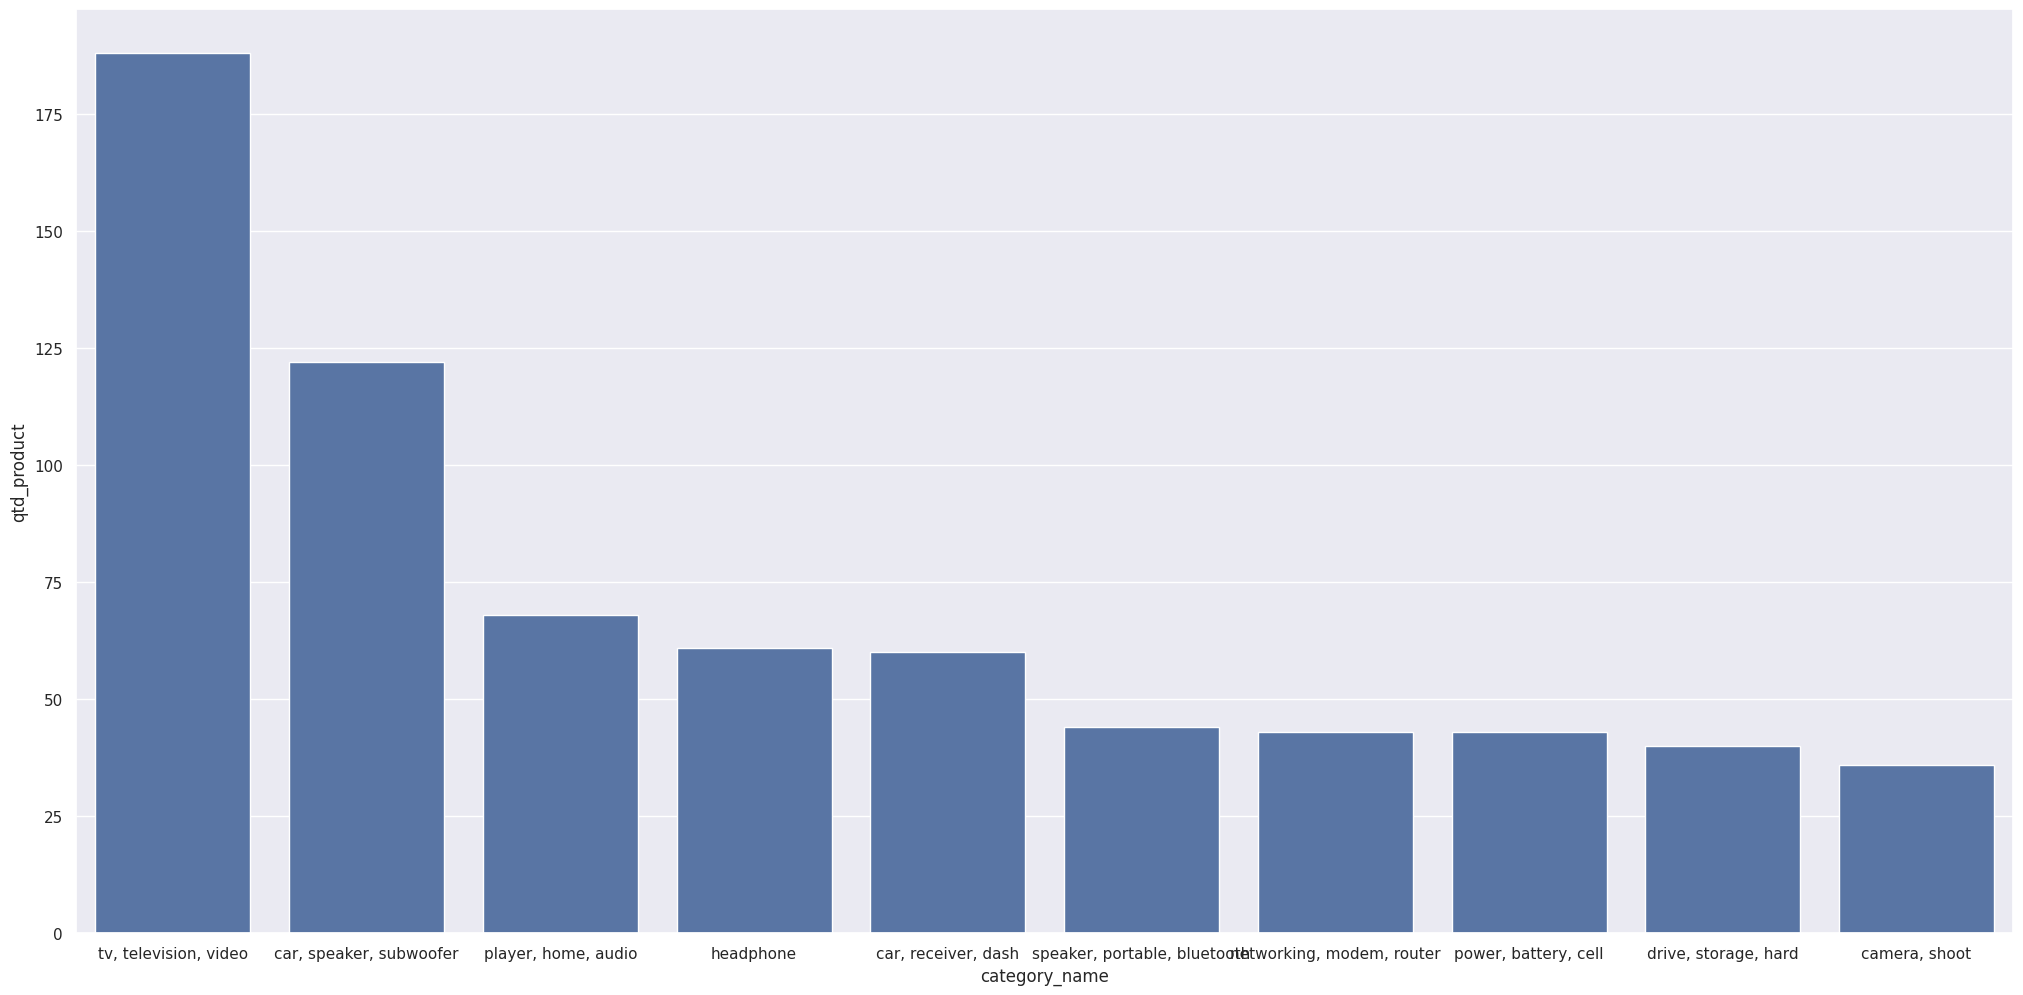

In [ ]:
columns = ['category_name', 'name']

aux = df_walmart[columns].groupby('category_name').count().reset_index()

aux = aux.rename(columns={'name': 'qtd_product'}).sort_values(by='qtd_product', ascending=False)



sns.barplot(data=aux.head(10), x='category_name', y='qtd_product')

What is the best-selling product?

In [ ]:
columns = ['name', 'price']

aux = df_walmart[columns].groupby('name').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value', 'name': 'Product'}).sort_values(by='Total Value', ascending=False)

aux.head(10)

Product  Total Value
140  Refurbished Samsung Curved 65 4K (2160P) Smart...           41
155  Samsung - Adaptive Fast Charging Wall Charger ...           36
112  Microsoft Surface Pro 4 Type Cover with Finger...           32
42   Details About Fits Chevy Silverado Pickup 1999...           30
165  Sennheiser - HD 800 Over-the-Ear Headphones - ...           25
9    Actiontec 300 Mbps Wireless-N ADSL Modem Route...           24
110        MU9000-Series 65-Class HDR UHD Smart LED TV           23
40   Dell DW316 External USB Slim DVD R/W Optical D...           22
108  MTX - Monitor Series Dual 6-1/2 200W 2-way Cen...           20
109        MU8000-Series 65-Class HDR UHD Smart LED TV           19

What is the best-selling brand?

<Axes: xlabel='brand', ylabel='Total Value'>

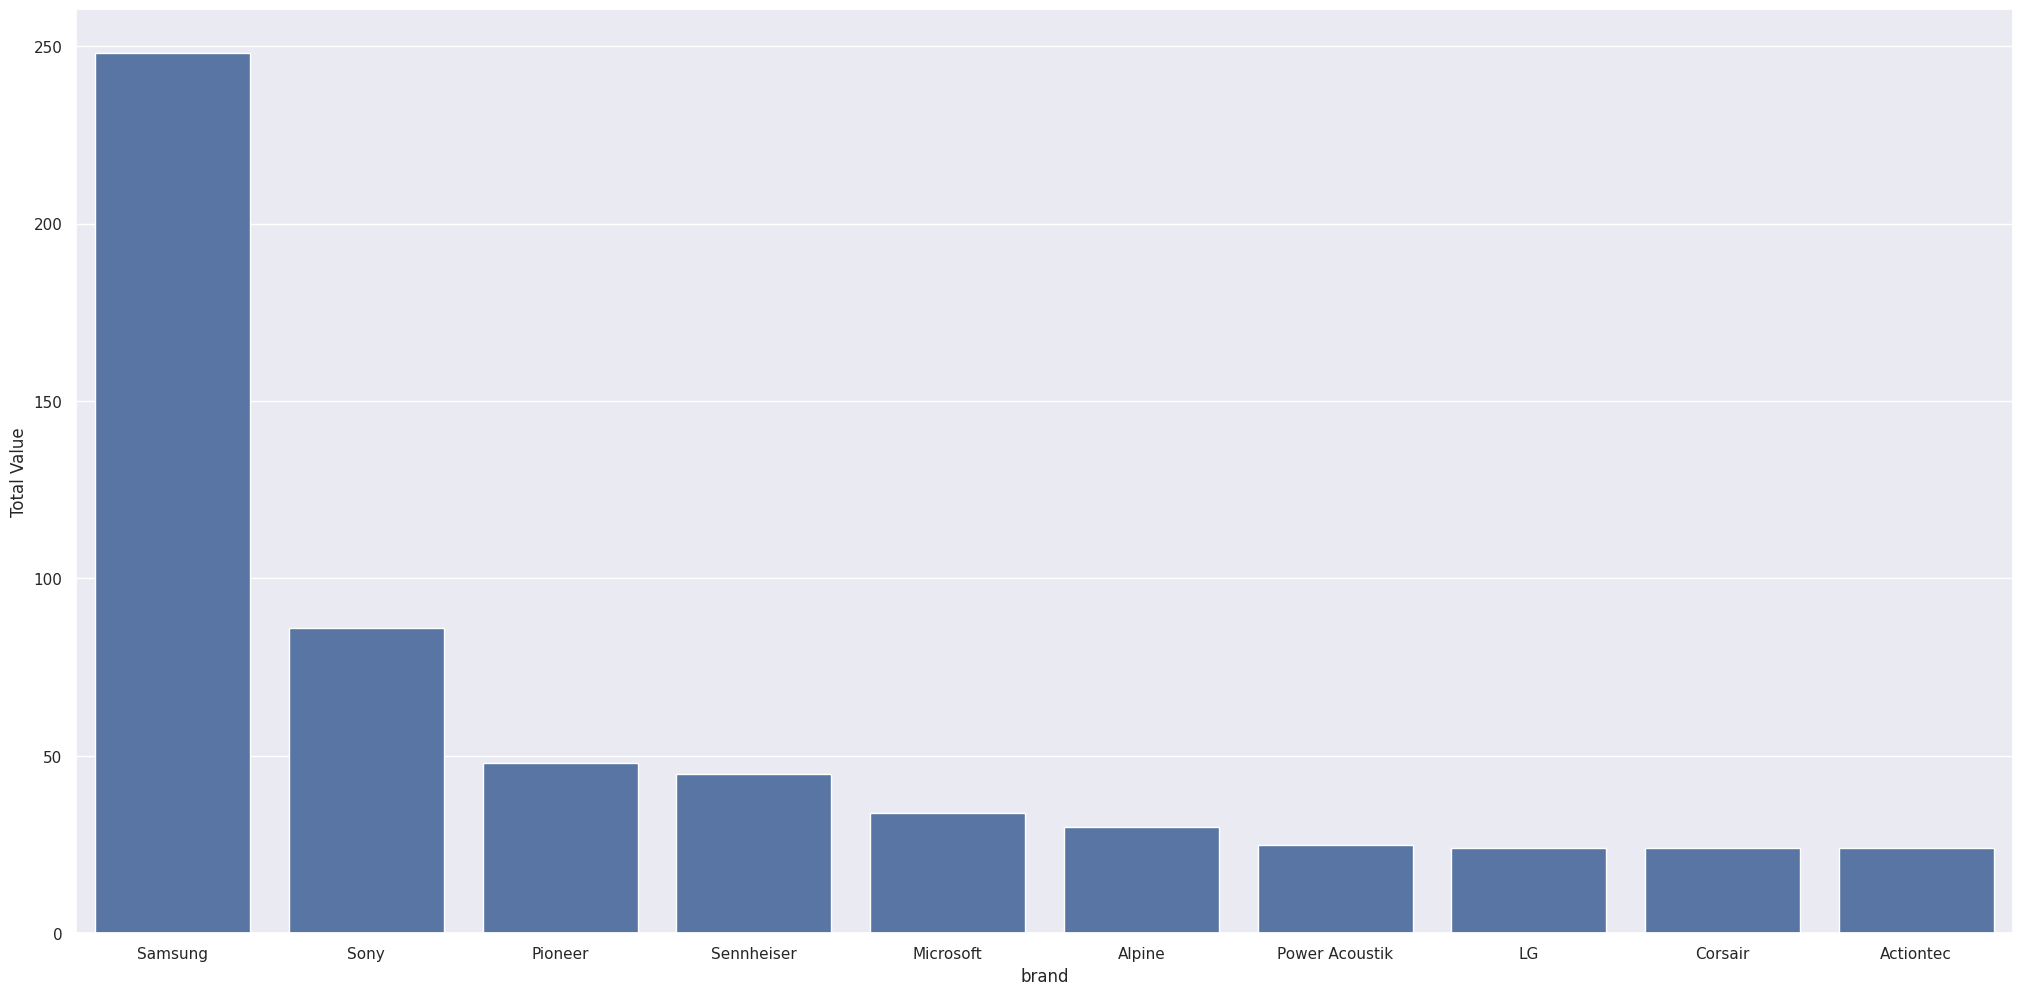

In [ ]:
columns = ['brand', 'price']

aux = df_walmart[columns].groupby('brand').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value'}).sort_values(by='Total Value', ascending=False)

sns.barplot(data=aux.head(10), x='brand', y='Total Value')

Which days, months, and weeks had the highest sales?


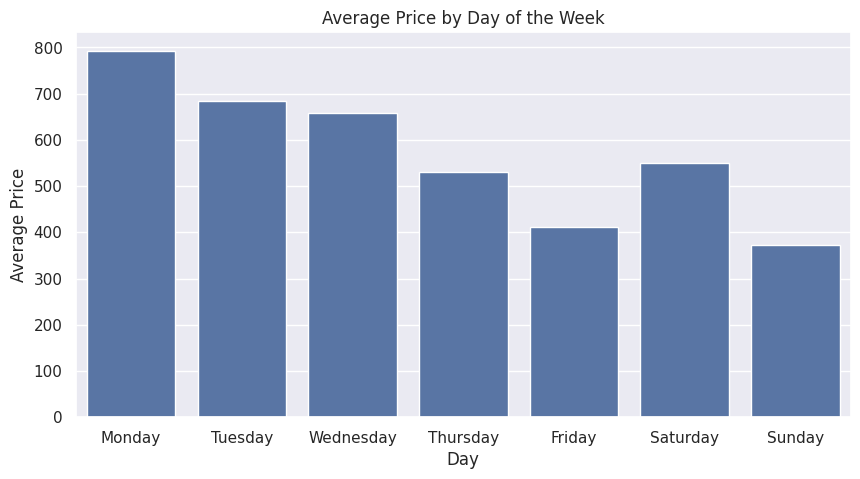

In [ ]:
aux = df_walmart.groupby('day_n')['price'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=aux, x='day_n', y='price', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Price by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Price')
plt.show()

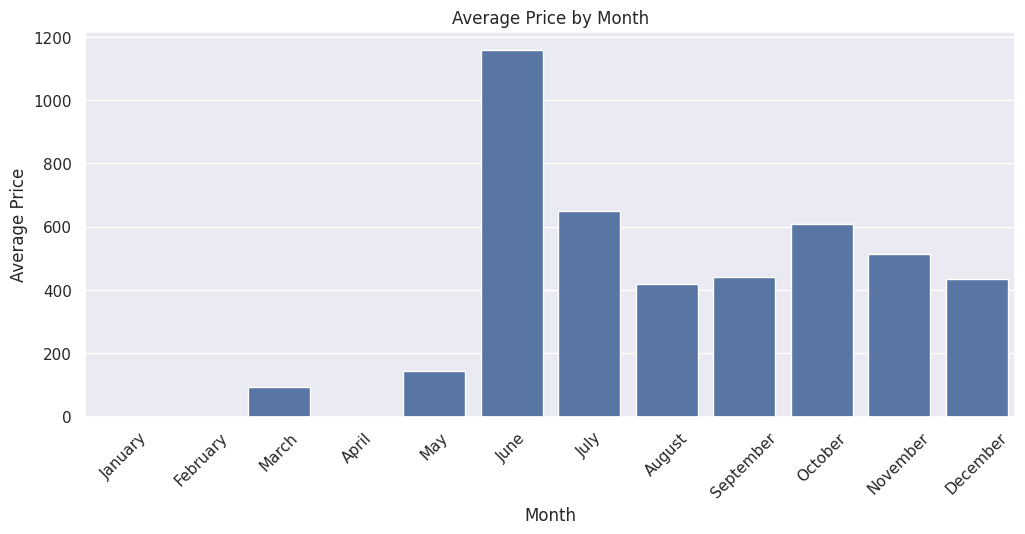

In [ ]:
aux = df_walmart.groupby('month_n')['price'].mean().reset_index()

order_months = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 5))
sns.barplot(data=aux, x='month_n', y='price', order=order_months)
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

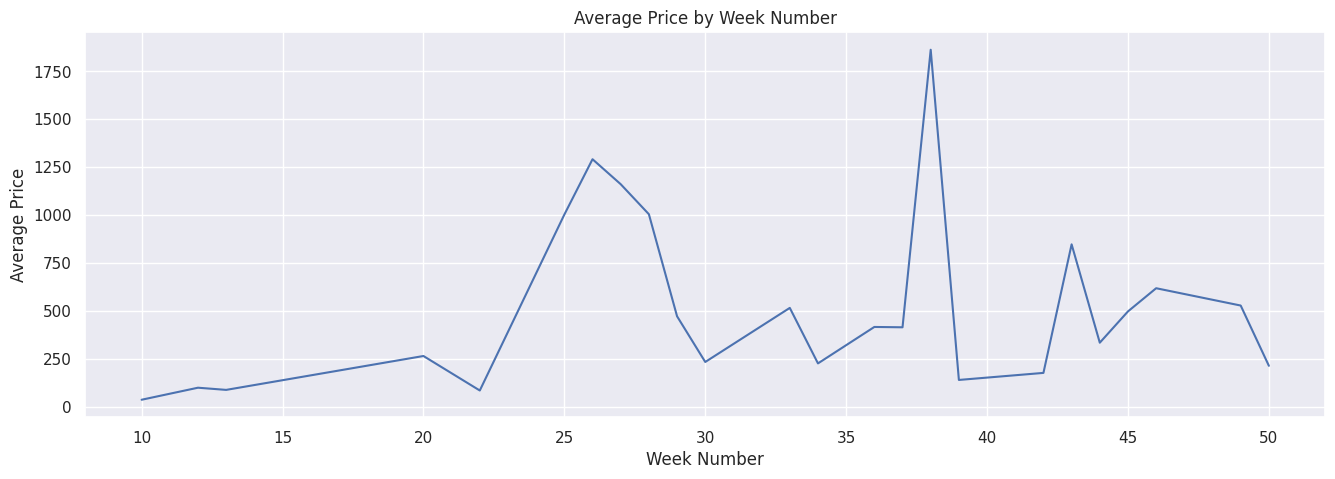

In [ ]:
aux = df_walmart.groupby('week_number')['price'].mean().reset_index()

plt.figure(figsize=(16, 5))
sns.lineplot(data=aux, x='week_number', y='price')
plt.title('Average Price by Week Number')
plt.xlabel('Week Number')
plt.ylabel('Average Price')
plt.show()

Weekly average price of the best-selling product

In [ ]:
df_walmart['name'].value_counts().sort_values(ascending=False).head(10)

name
Refurbished Samsung Curved 65 4K (2160P) Smart QLED TV (2017 Model) + 1 Year Extended Warranty (QN65Q7CAMFXZA)"    41
Samsung - Adaptive Fast Charging Wall Charger - White                                                              36
Microsoft Surface Pro 4 Type Cover with Fingerprint ID                                                             32
Details About Fits Chevy Silverado Pickup 19992006 Speaker Upgrade Pioneer Tsg1345r Tsg4620s                       30
Sennheiser - HD 800 Over-the-Ear Headphones - Silver/Black                                                         25
Actiontec 300 Mbps Wireless-N ADSL Modem Router (GT784WN)                                                          24
MU9000-Series 65-Class HDR UHD Smart LED TV                                                                        23
Dell DW316 External USB Slim DVD R/W Optical Drive 429-AAUX                                                        22
MTX - Monitor Series Dual 6-1/2 200W 2-way Center-Channel Speaker (Each) - Black"                                  20
MU8000-Series 65-Class HDR UHD Smart LED TV                                                                        19
Name: count, dtype: int64

<Axes: xlabel='week_number', ylabel='price'>

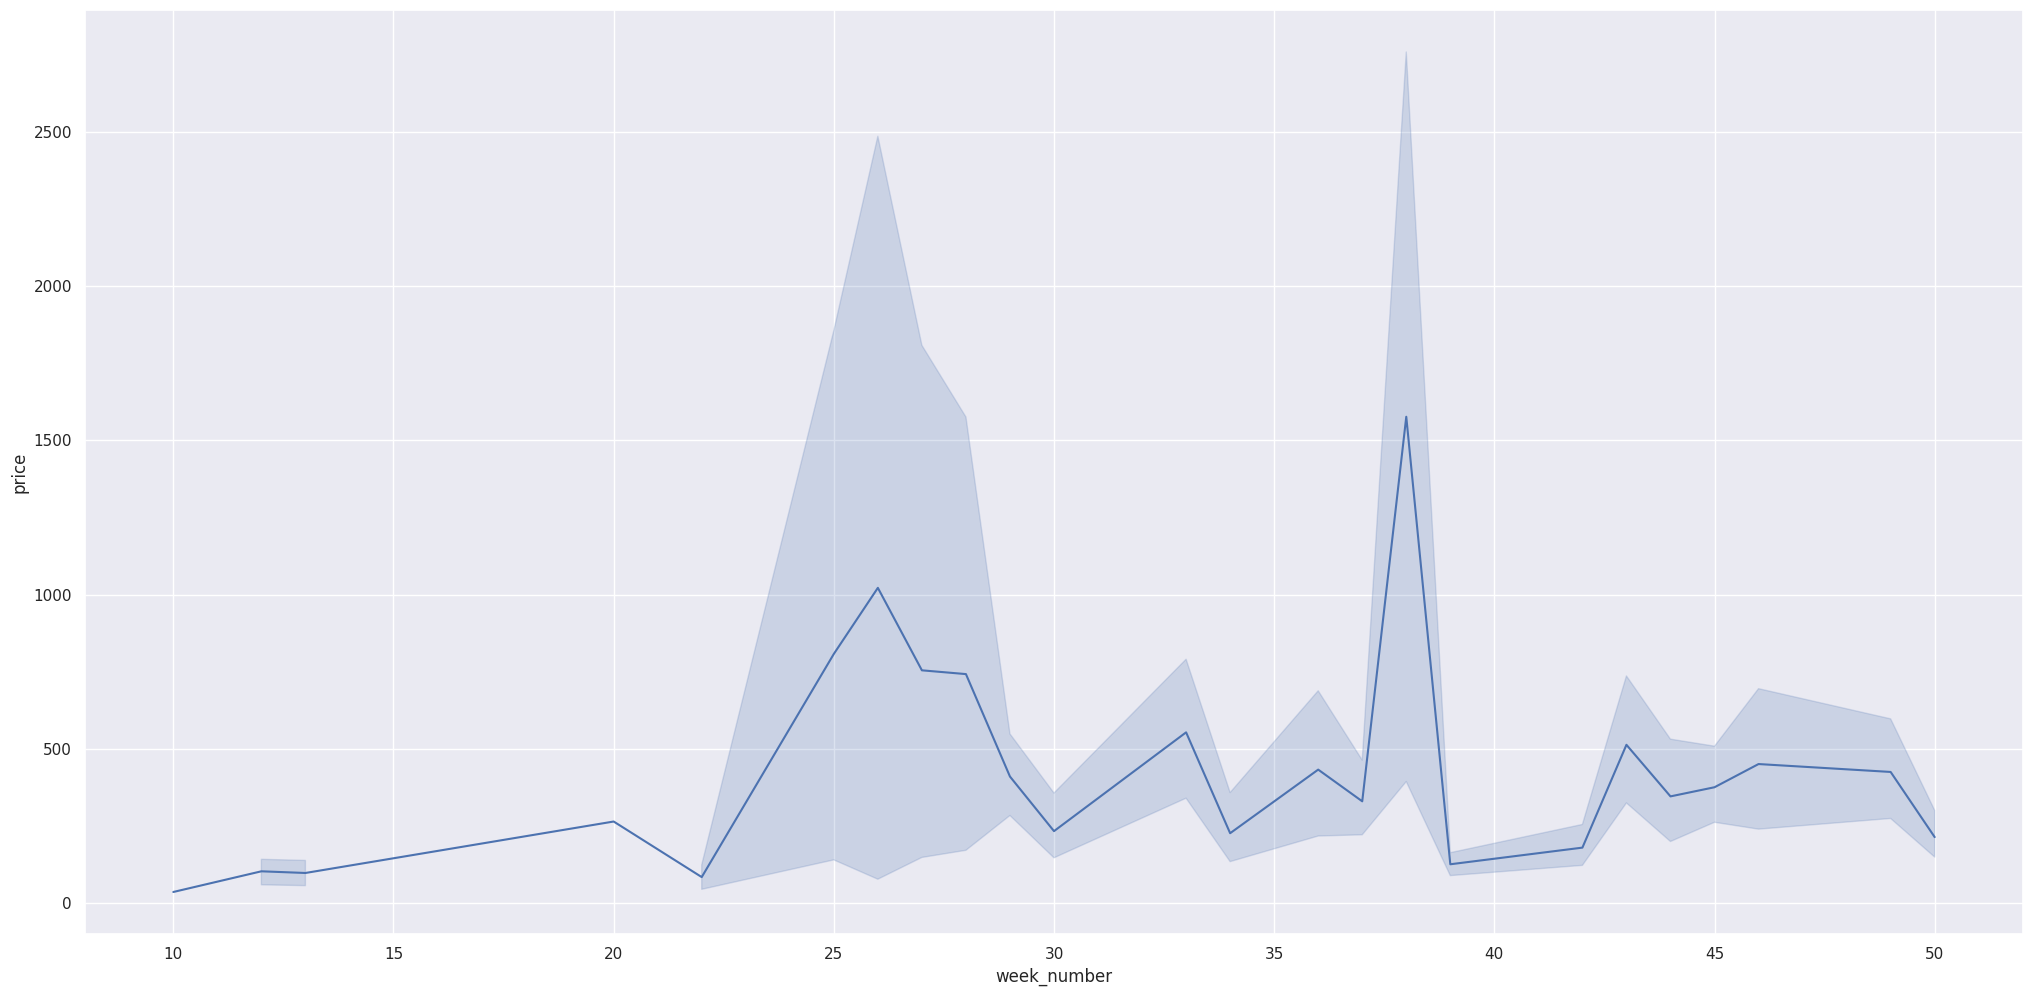

In [ ]:
aux = df_walmart[df_walmart['name'] == '4K Video Camera']

aux = df_walmart.groupby(['name', 'week_number'])['price'].mean().reset_index()

sns.lineplot(aux, x='week_number', y='price')

Group prices over time

<Axes: >

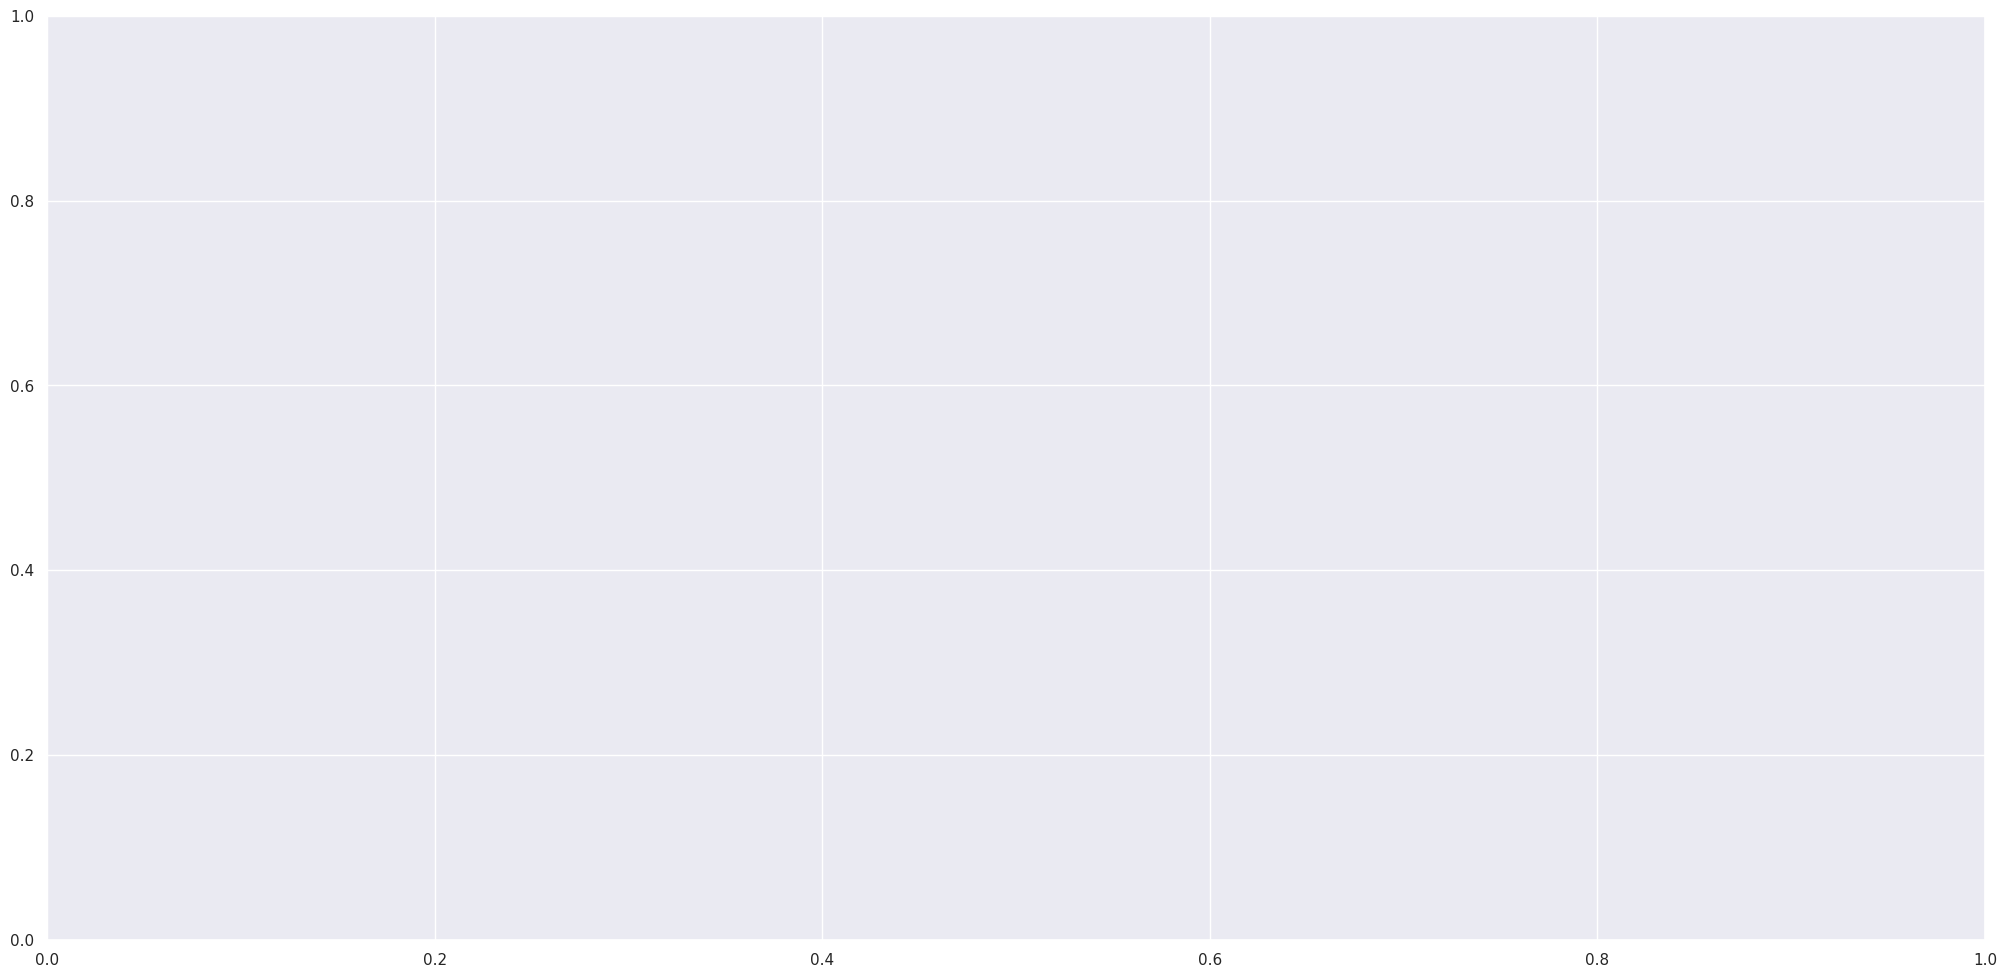

In [ ]:
aux = df_walmart[df_walmart['name'] == '4K Video Camera']

aux = aux.groupby('date_imp_d')['price'].mean().reset_index()

sns.lineplot(aux)

##### Ebay

Best-selling category

In [ ]:
columns = ['category_name', 'name']

aux = df_ebay[columns].groupby('category_name').count().reset_index()

aux = aux.rename(columns={'name': 'qtd_product'}).sort_values(by='qtd_product', ascending=False)

aux.head(10)

category_name  qtd_product
27           tv, television, video          322
7             drive, storage, hard           91
14                laptop, computer           44
8         drive, storage, internal           30
25  security, surveillance, camera           25
13         headset, game, computer           21
20  projector, presentation, mount           19
4              car, receiver, dash           17
23       receiver, amplifier, home           13
5          car, speaker, subwoofer           13

What is the best-selling product?

In [ ]:
columns = ['name', 'price']

aux = df_ebay[columns].groupby('name').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value', 'name': 'Product'}).sort_values(by='Total Value', ascending=False)

aux.head(10)

Product  Total Value
56     XBR-X850E-Series 75-Class HDR UHD Smart LED TV           82
33        MU8000-Series 65-Class HDR UHD Smart LED TV           72
44  Seagate - Backup Plus 5TB External USB 3.0 Por...           63
34        MU9000-Series 65-Class HDR UHD Smart LED TV           46
28  LG - 65 Class - LED - SJ8500 Series - 2160p - ...           32
15  Details About Sony Kd43x720e 43inch 4k Ultra H...           30
45  Seagate Backup Plus Ultra Slim 2TB Portable Ex...           24
29  LG - 75 Class - LED - UJ6470 Series - 2160p - ...           23
0       1TB WD Black Mobile OEM Hard Drive (WD10JPLX)           23
47  Sony - 55 Class - OLED - A1E Series - 2160p - ...           19

What is the best-selling brand?

In [ ]:
columns = ['brand', 'price']

aux = df_ebay[columns].groupby('brand').count().reset_index()

aux = aux.rename(columns={'price': 'Total Value'}).sort_values(by='Total Value', ascending=False)

aux.head(10)

brand  Total Value
27         Sony          178
24      Samsung          150
25      Seagate           87
17           LG           57
34           WD           23
12           HP           19
18       Lenovo           19
37        Zmodo           17
28  Steelseries           14
6       Corsair           11

Which days, months, and weeks had the highest sales?


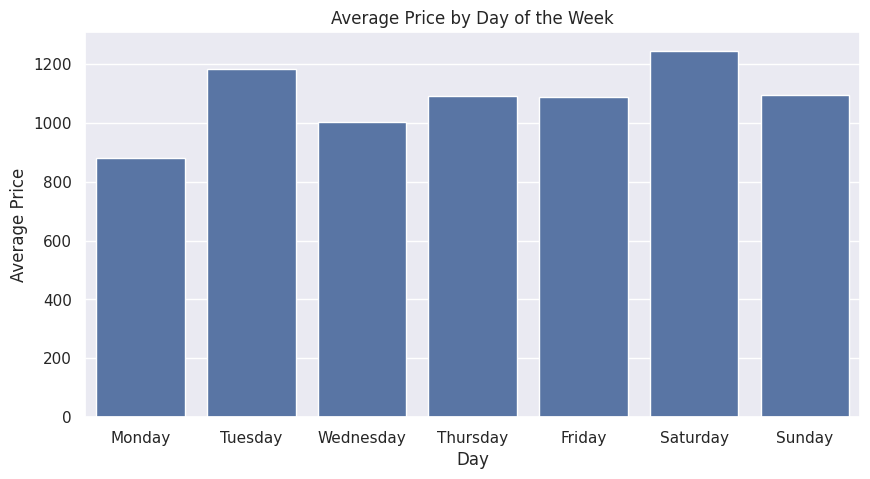

In [ ]:
aux = df_ebay.groupby('day_n')['price'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=aux, x='day_n', y='price', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Price by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Price')
plt.show()

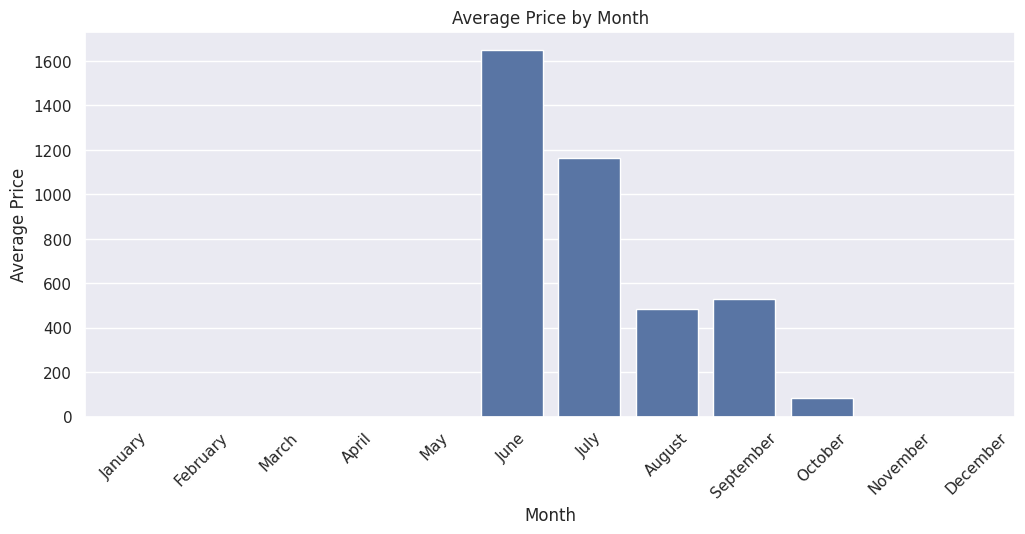

In [ ]:
aux = df_ebay.groupby('month_n')['price'].mean().reset_index()

order_months = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 5))
sns.barplot(data=aux, x='month_n', y='price', order=order_months)
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

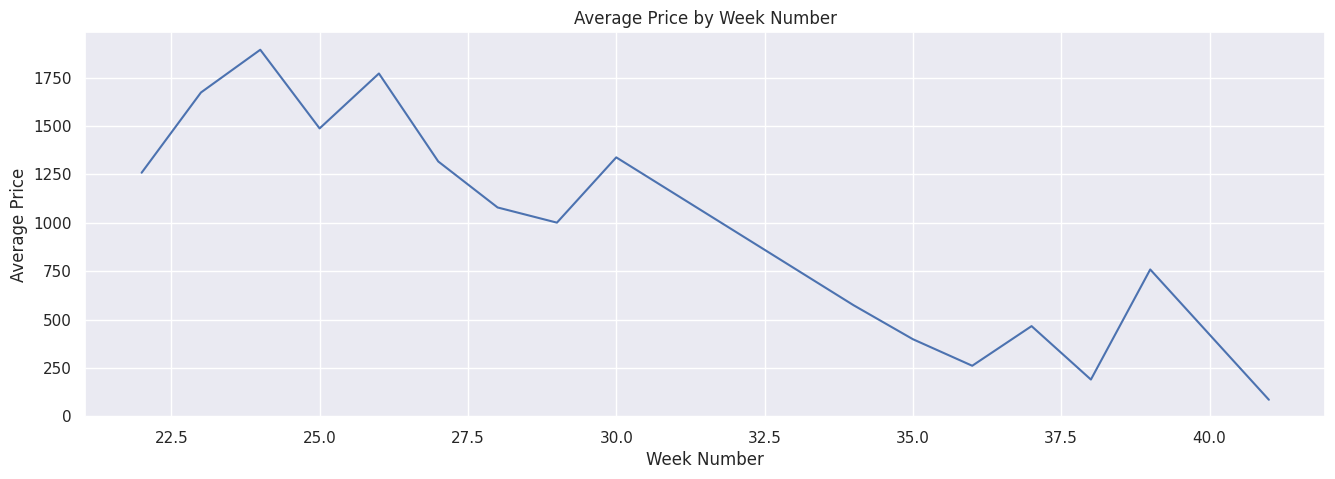

In [ ]:
aux = df_ebay.groupby('week_number')['price'].mean().reset_index()

plt.figure(figsize=(16, 5))
sns.lineplot(data=aux, x='week_number', y='price')
plt.title('Average Price by Week Number')
plt.xlabel('Week Number')
plt.ylabel('Average Price')
plt.show()

Weekly average price of the best-selling product

In [ ]:
df_ebay['name'].value_counts().sort_values(ascending=False).head(10)

name
XBR-X850E-Series 75-Class HDR UHD Smart LED TV                                                                                                     82
MU8000-Series 65-Class HDR UHD Smart LED TV                                                                                                        72
Seagate - Backup Plus 5TB External USB 3.0 Portable Hard Drive - silver                                                                            63
MU9000-Series 65-Class HDR UHD Smart LED TV                                                                                                        46
LG - 65 Class - LED - SJ8500 Series - 2160p - Smart - 4K UHD TV with HDR"                                                                          32
Details About Sony Kd43x720e 43inch 4k Ultra Hd Smart Led Tv (2017 Model) Kd43x720e                                                                30
Seagate Backup Plus Ultra Slim 2TB Portable External Hard Drive                                                                                    24
1TB WD Black Mobile OEM Hard Drive (WD10JPLX)                                                                                                      23
LG - 75 Class - LED - UJ6470 Series - 2160p - Smart - 4K UHD TV with HDR"                                                                          23
HP 15-AY103DX 15.6 Touchscreen Touch Screen HD Laptop Notebook PC Computer 7th Gen i5-7200U Kaby Lake 8GB Memory 1TB HDD Hard Drive Windows 10"    19
Name: count, dtype: int64

<Axes: xlabel='week_number', ylabel='price'>

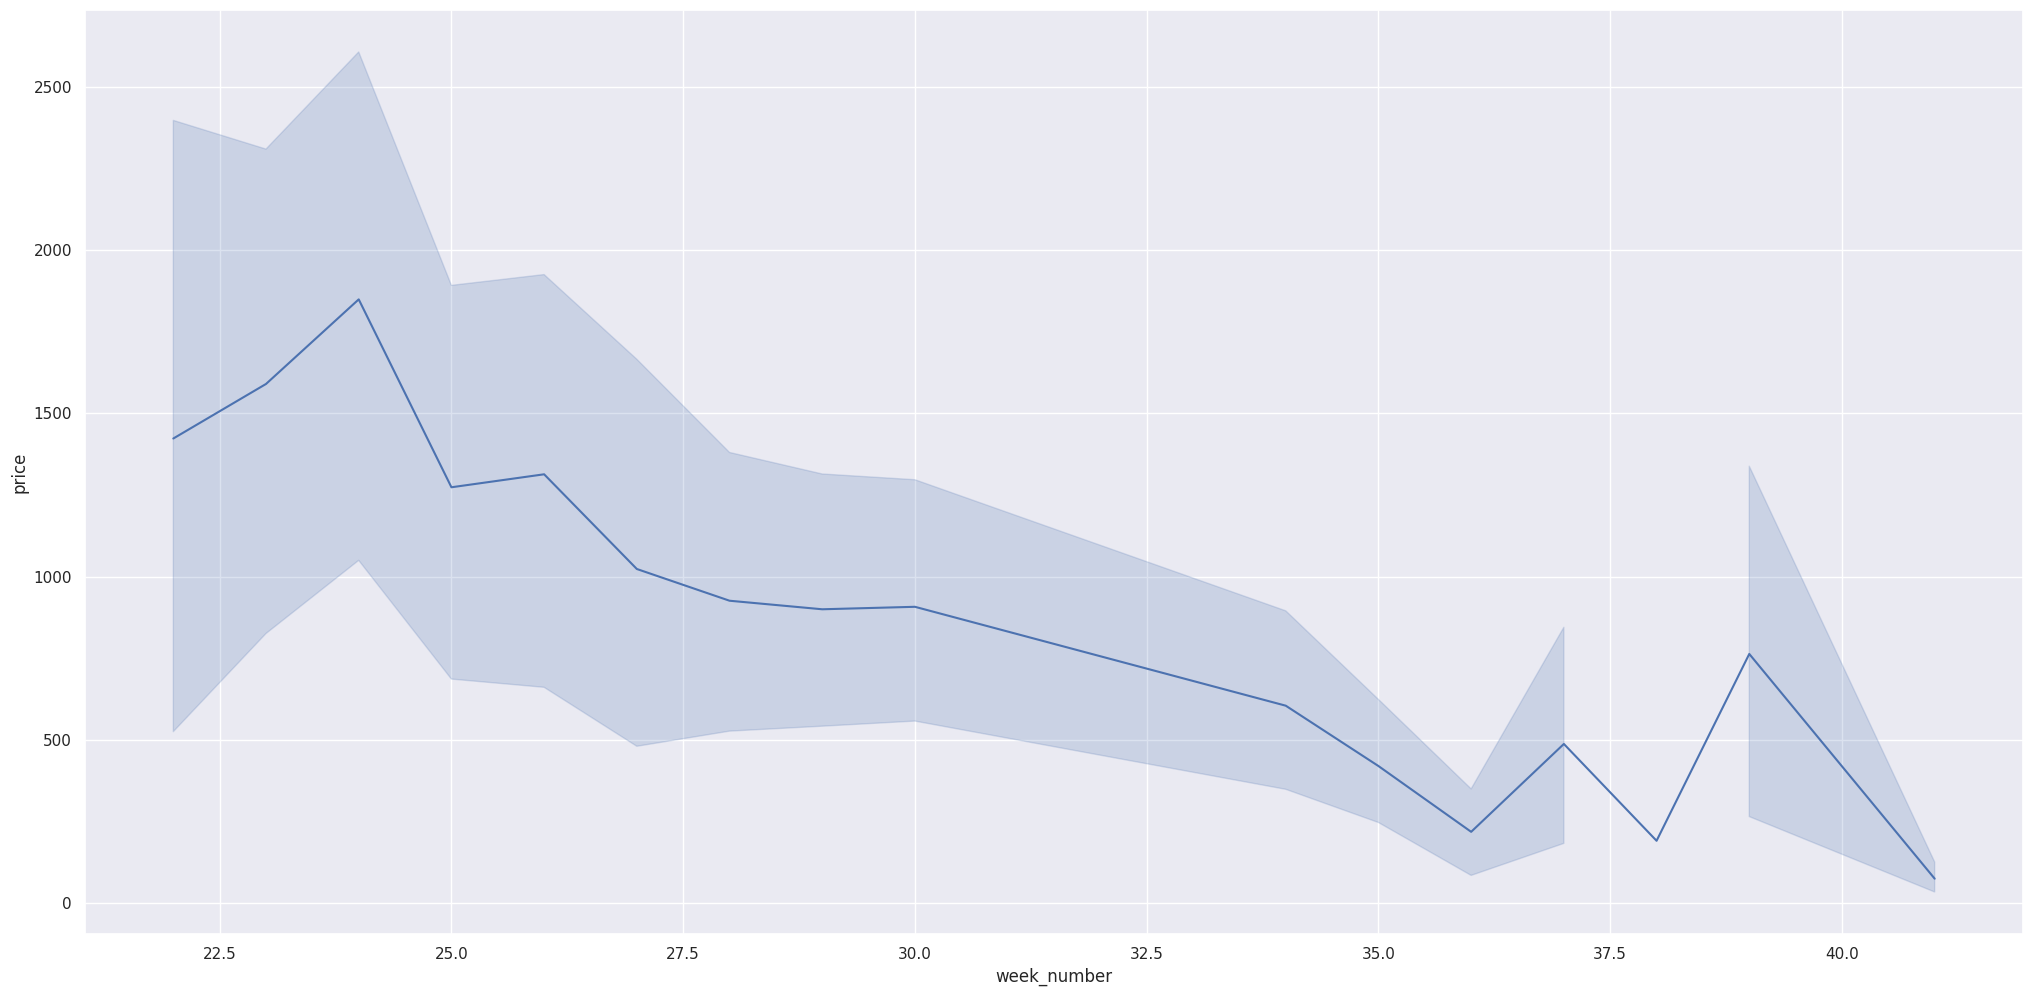

In [ ]:
aux = df_ebay[df_ebay['name'] == 'Details About Apple Macbook Air 13.3 Laptop (early 2015) 2.2ghz Core I7 8gb 256gb"']

aux = df_ebay.groupby(['name', 'week_number'])['price'].mean().reset_index()

sns.lineplot(aux, x='week_number', y='price')

Group prices over time

<Axes: >

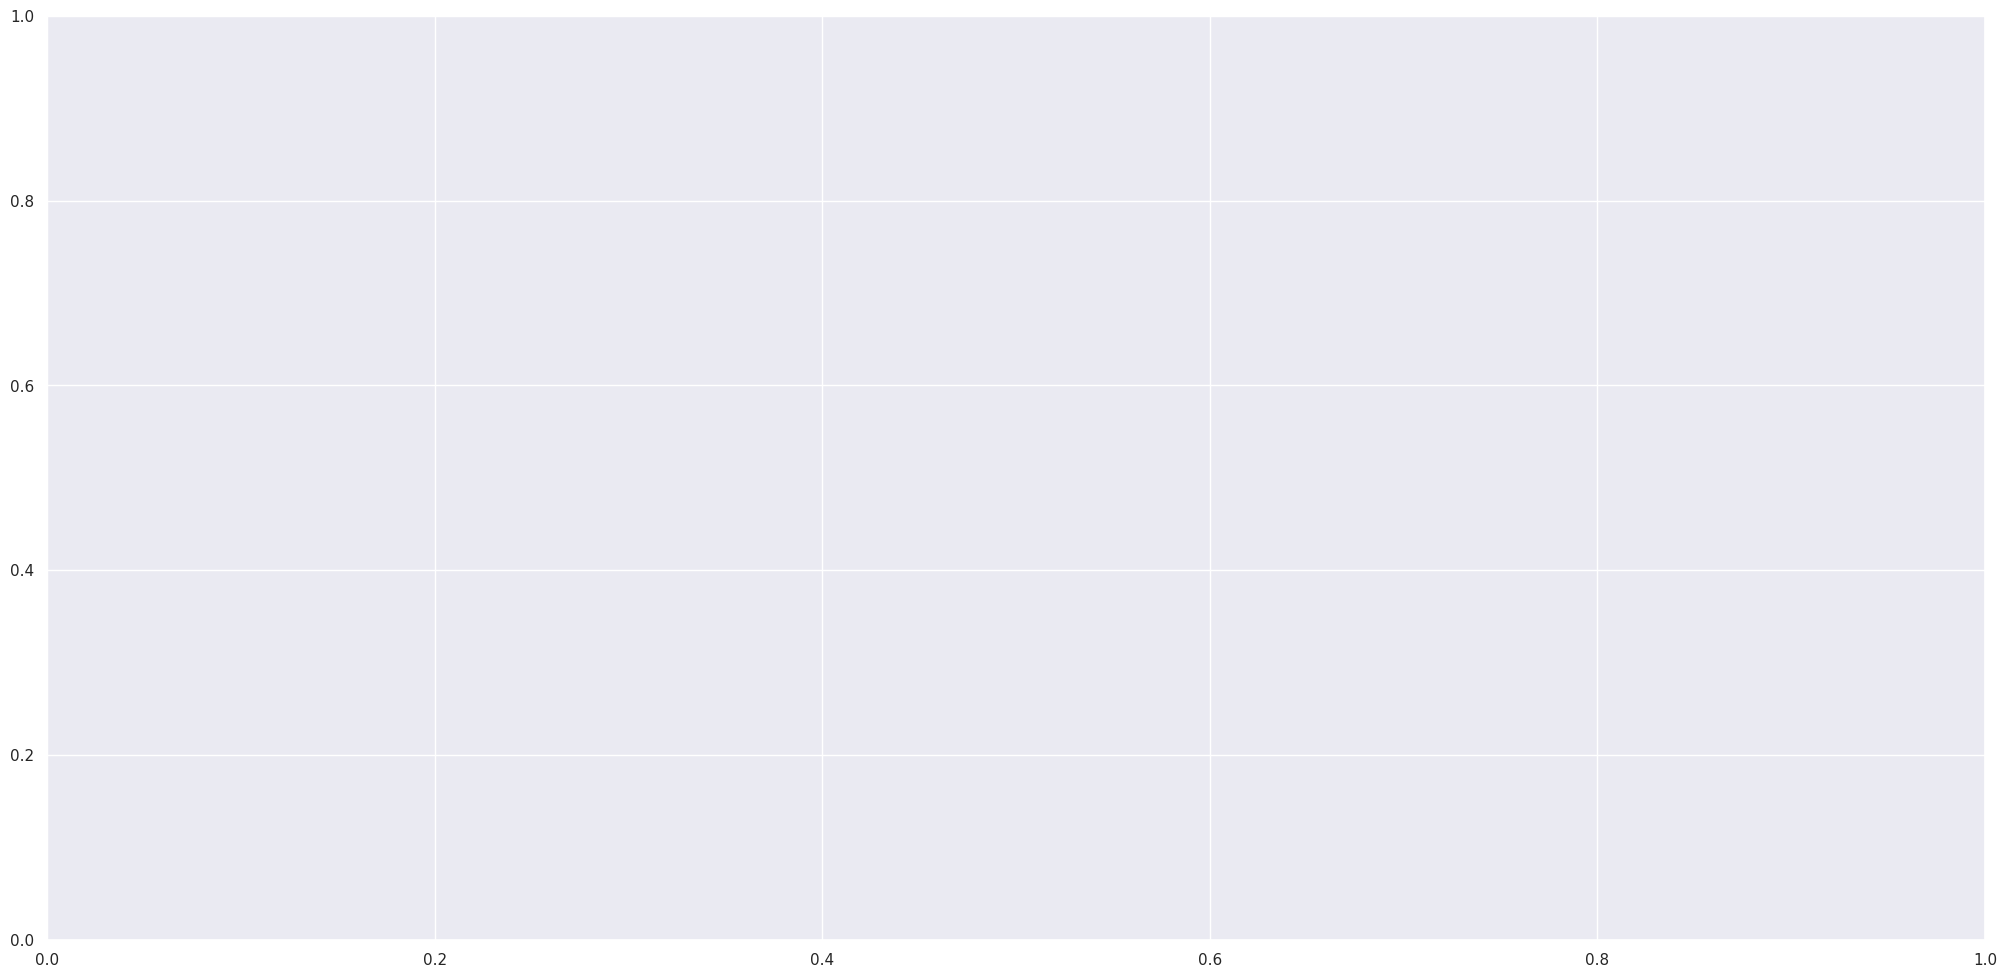

In [ ]:
aux = df_ebay[df_ebay['name'] == 'Details About Apple Macbook Air 13.3 Laptop (early 2015) 2.2ghz Core I7 8gb 256gb"']

aux = aux.groupby('date_imp_d')['price'].mean().reset_index()

sns.lineplot(aux)

#### Multivariate Analysis

<Axes: >

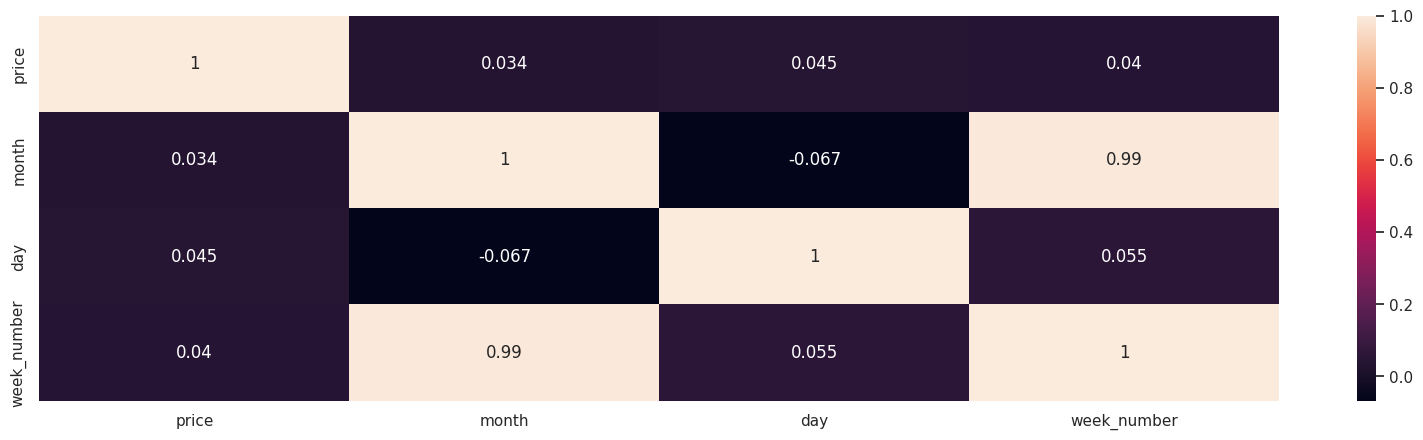

In [ ]:
corr = num_attributes.corr(method='pearson')

plt.figure(figsize=(20,5))
sns.heatmap(corr, annot=True)

Price Over Time – Top 5 Best-Selling Categories

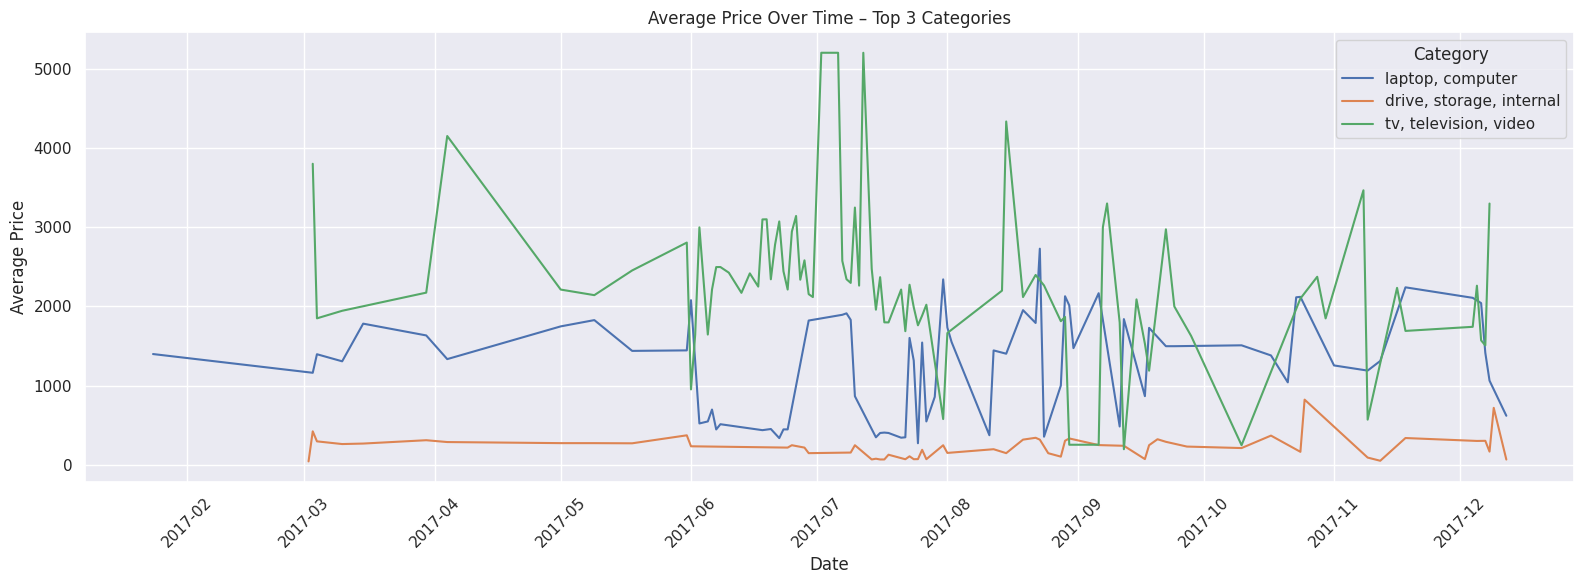

In [ ]:
top_categories = df2['category_name'].value_counts().head(3).index.tolist()

df_top_cat = df2[df2['category_name'].isin(top_categories)]

aux = df_top_cat.groupby(['date_imp_d', 'category_name'])['price'].mean().reset_index()


plt.figure(figsize=(16, 6))
sns.lineplot(data=aux, x='date_imp_d', y='price', hue='category_name')
plt.title('Average Price Over Time – Top 3 Categories')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Price Over Time – Top 5 Best-Selling Brands

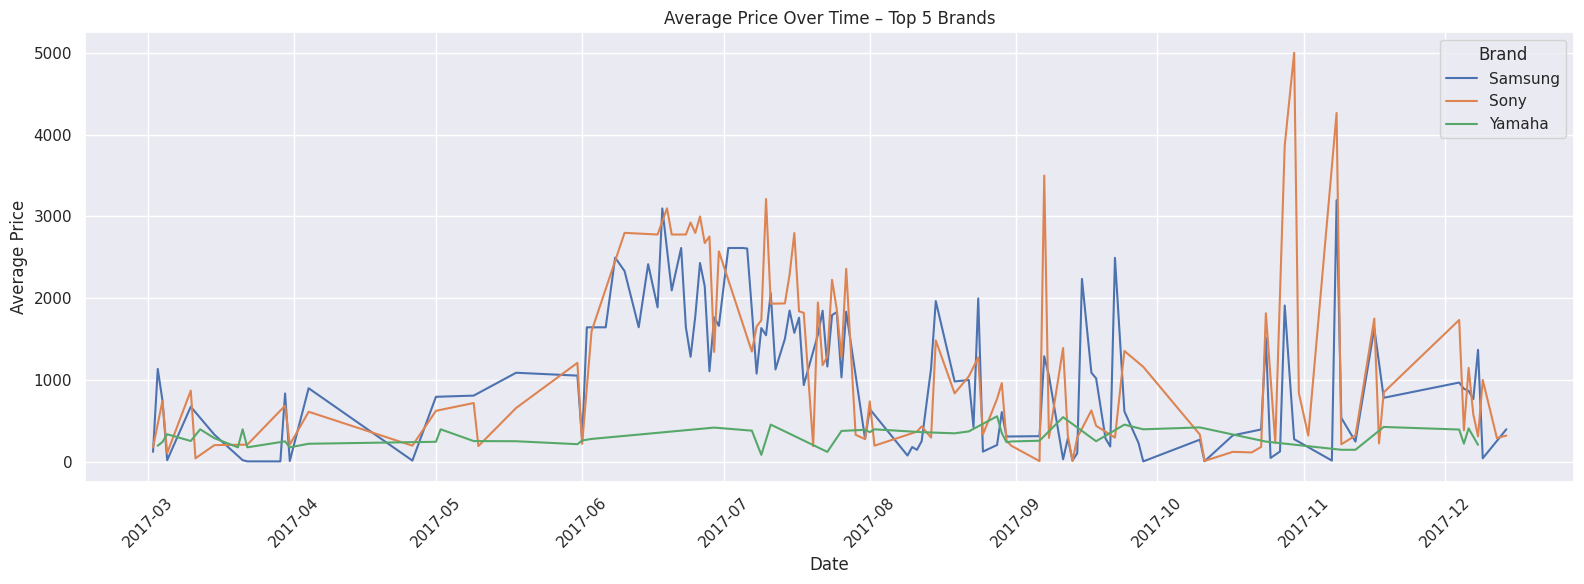

In [ ]:
top_brands = df2['brand'].value_counts().head(3).index.tolist()

df_top_brand = df2[df2['brand'].isin(top_brands)]

aux = df_top_brand.groupby(['date_imp_d', 'brand'])['price'].mean().reset_index()

plt.figure(figsize=(16, 6))
sns.lineplot(data=aux, x='date_imp_d', y='price', hue='brand')
plt.title('Average Price Over Time – Top 5 Brands')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(title='Brand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preparation

In [ ]:
df3 = df2.copy()

Categoria mais vendida da Ebay

In [ ]:
#Segunda Categoria mais vendida da BestBuy
df_product = df_bestbuy[df_bestbuy['category_name'] == 'speaker, portable, bluetooth']
#df_product = df_bestbuy[df_bestbuy['category_name'] == 'car, speaker, subwoofer']
#df_product = df_ebay[df_ebay['category_name'] == 'tv, television, video']

In [ ]:
df_product.isna().sum()

date_imp_d       0
category_name    0
name             0
price            0
merchant         0
brand            0
day_n            0
month            0
month_n          0
day              0
week_number      0
dtype: int64

In [ ]:
columns = ['price', 'name', 'week_number', 'date_imp_d']

aux_product = df_product[columns].groupby(['week_number', 'name']).agg({'price': 'mean', 'date_imp_d':'count'}).reset_index()

aux_product.head(10)

week_number                                               name   price  date_imp_d
0          9.0  BRAVEN BRV-HD Wireless Bluetooth Speaker [28 H...  179.99           1
1          9.0  Boytone - 2500W 2.1-Ch. Home Theater System - ...   64.99           2
2          9.0  DreamWave - Tremor Portable Bluetooth Speaker ...  290.99           1
3          9.0  ECOXGEAR ECOXBT Rugged and Waterproof Wireless...   72.99           1
4          9.0       ECOXGEAR ECOXBT Waterproof Bluetooth Speaker   63.99           2
5          9.0         EcoJam Waterproof Bluetooth Speaker, Black  129.99           2
6          9.0  Ecoxgear Ecocarbon Bluetooth Waterproof Speake...  129.99           2
7          9.0           Get Up Stand Bluetooth Home Audio System  299.99           1
8          9.0  JBL Flip 3 Splashproof Portable Bluetooth Spea...   99.99           3
9          9.0        Outdoor Tech Buckshot Pro Bluetooth Speaker   57.49           4

In [ ]:
#generate dataframe with the values (X)
X_price = aux_product.pivot(index='week_number', columns='name', values='price')
X_price = pd.DataFrame(X_price.to_records())
X_price.head(10)

week_number  BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond  Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker  DreamWave - Tremor Portable Bluetooth Speaker - Green,Black  ECOXGEAR ECOXBT Rugged and Waterproof Wireless Bluetooth Speaker (Orange)  ECOXGEAR ECOXBT Waterproof Bluetooth Speaker  EcoJam Waterproof Bluetooth Speaker, Black  Ecoxgear Ecocarbon Bluetooth Waterproof Speaker (black)  Get Up Stand Bluetooth Home Audio System  JBL Flip 3 Splashproof Portable Bluetooth Speaker (Teal)  Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green  Outdoor Tech Buckshot Pro Bluetooth Speaker  Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoor Speaker (Each) - White"  SRS-XB40 Bluetooth Speaker (Black)  SRS-XB40 Bluetooth Speaker (Blue)  Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charcoal black  iHome Rechargeable Splash Proof Stereo Bluetooth Speaker - Black (IBT33BC)
0          9.0                                             179.99                                                                                                                      64.99                                                          NaN                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          299.99                                              99.99                                                       NaN                                                                57.49                                             249.99                                                        NaN                                NaN                                             149.99                                                    32.99                         
1         10.0                                             129.99                                                                                                                      64.99                                                          NaN                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          225.99                                              99.99                                                       NaN                                                                57.99                                             249.99                                                        NaN                                NaN                                             149.99                                                    32.99                         
2         11.0                                             129.99                                                                                                                        NaN                                                          NaN                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          225.99                                              99.99                                                       NaN                                                                57.49                                      

In [ ]:
#generate dataframe with the values (y)
y_demand = aux_product.pivot(index='week_number', columns='name', values='date_imp_d')
y_demand = pd.DataFrame(y_demand.to_records())
y_demand.head(10)

week_number  BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond  Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker  DreamWave - Tremor Portable Bluetooth Speaker - Green,Black  ECOXGEAR ECOXBT Rugged and Waterproof Wireless Bluetooth Speaker (Orange)  ECOXGEAR ECOXBT Waterproof Bluetooth Speaker  EcoJam Waterproof Bluetooth Speaker, Black  Ecoxgear Ecocarbon Bluetooth Waterproof Speaker (black)  Get Up Stand Bluetooth Home Audio System  JBL Flip 3 Splashproof Portable Bluetooth Speaker (Teal)  Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green  Outdoor Tech Buckshot Pro Bluetooth Speaker  Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoor Speaker (Each) - White"  SRS-XB40 Bluetooth Speaker (Black)  SRS-XB40 Bluetooth Speaker (Blue)  Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charcoal black  iHome Rechargeable Splash Proof Stereo Bluetooth Speaker - Black (IBT33BC)
0          9.0                                                1.0                                                                                                                        2.0                                                          NaN                                                                              1.0                                                          1.0                                                                   2.0                                         2.0                                                2.0                                             1.0                                                3.0                                                       NaN                                                                  4.0                                                1.0                                                        NaN                                NaN                                                2.0                                                      1.0                         
1         10.0                                                1.0                                                                                                                        1.0                                                          NaN                                                                              1.0                                                          1.0                                                                   1.0                                         1.0                                                1.0                                             1.0                                                1.0                                                       NaN                                                                  2.0                                                1.0                                                        NaN                                NaN                                                1.0                                                      1.0                         
2         11.0                                                1.0                                                                                                                        NaN                                                          NaN                                                                              1.0                                                          1.0                                                                   1.0                                         1.0                                                1.0                                             1.0                                                1.0                                                       NaN                                                                  2.0                                      

In [ ]:
#Data Dimesion, check NA, dtypes

X_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 18 columns):
 #   Column                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                     --------------  -----  
 0   week_number                                                                                                                22 non-null     float64
 1   BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  4 non-null      float64
 2   Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond                                                                13 non-null     float64
 3   Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker                                            7 non-nul

In [ ]:
#Data Dimesion,check NA, dtypes

y_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 18 columns):
 #   Column                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                     --------------  -----  
 0   week_number                                                                                                                22 non-null     float64
 1   BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  4 non-null      float64
 2   Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond                                                                13 non-null     float64
 3   Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker                                            7 non-nul

#### Replace NA

In [ ]:
X_price = X_price.fillna(X_price.median(numeric_only=True))
X_price = X_price.round(2)
X_price.head()

week_number  BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond  Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker  DreamWave - Tremor Portable Bluetooth Speaker - Green,Black  ECOXGEAR ECOXBT Rugged and Waterproof Wireless Bluetooth Speaker (Orange)  ECOXGEAR ECOXBT Waterproof Bluetooth Speaker  EcoJam Waterproof Bluetooth Speaker, Black  Ecoxgear Ecocarbon Bluetooth Waterproof Speaker (black)  Get Up Stand Bluetooth Home Audio System  JBL Flip 3 Splashproof Portable Bluetooth Speaker (Teal)  Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green  Outdoor Tech Buckshot Pro Bluetooth Speaker  Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoor Speaker (Each) - White"  SRS-XB40 Bluetooth Speaker (Black)  SRS-XB40 Bluetooth Speaker (Blue)  Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charcoal black  iHome Rechargeable Splash Proof Stereo Bluetooth Speaker - Black (IBT33BC)
0          9.0                                             179.99                                                                                                                      64.99                                                        99.99                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          299.99                                              99.99                                                    119.95                                                                57.49                                             249.99                                                     249.99                             249.99                                             149.99                                                    32.99                         
1         10.0                                             129.99                                                                                                                      64.99                                                        99.99                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          225.99                                              99.99                                                    119.95                                                                57.99                                             249.99                                                     249.99                             249.99                                             149.99                                                    32.99                         
2         11.0                                             129.99                                                                                                                      64.99                                                        99.99                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          225.99                                              99.99                                                    119.95                                                                57.49                                      

In [ ]:
y_demand = y_demand.fillna(0)
y_demand = y_demand.round()
y_demand.head()

week_number  BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond  Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker  DreamWave - Tremor Portable Bluetooth Speaker - Green,Black  ECOXGEAR ECOXBT Rugged and Waterproof Wireless Bluetooth Speaker (Orange)  ECOXGEAR ECOXBT Waterproof Bluetooth Speaker  EcoJam Waterproof Bluetooth Speaker, Black  Ecoxgear Ecocarbon Bluetooth Waterproof Speaker (black)  Get Up Stand Bluetooth Home Audio System  JBL Flip 3 Splashproof Portable Bluetooth Speaker (Teal)  Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green  Outdoor Tech Buckshot Pro Bluetooth Speaker  Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoor Speaker (Each) - White"  SRS-XB40 Bluetooth Speaker (Black)  SRS-XB40 Bluetooth Speaker (Blue)  Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charcoal black  iHome Rechargeable Splash Proof Stereo Bluetooth Speaker - Black (IBT33BC)
0          9.0                                                1.0                                                                                                                        2.0                                                          0.0                                                                              1.0                                                          1.0                                                                   2.0                                         2.0                                                2.0                                             1.0                                                3.0                                                       0.0                                                                  4.0                                                1.0                                                        0.0                                0.0                                                2.0                                                      1.0                         
1         10.0                                                1.0                                                                                                                        1.0                                                          0.0                                                                              1.0                                                          1.0                                                                   1.0                                         1.0                                                1.0                                             1.0                                                1.0                                                       0.0                                                                  2.0                                                1.0                                                        0.0                                0.0                                                1.0                                                      1.0                         
2         11.0                                                1.0                                                                                                                        0.0                                                          0.0                                                                              1.0                                                          1.0                                                                   1.0                                         1.0                                                1.0                                             1.0                                                1.0                                                       0.0                                                                  2.0                                      

In [ ]:
X_price.describe().T

count        mean        std     min     25%     50%     75%     max
week_number                                          22.0   24.727273  10.846030    9.00   14.75   24.00   34.75   41.00
BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Ho...   22.0  131.080909  12.247095  103.99  129.99  129.99  129.99  179.99
Boytone - 2500W 2.1-Ch. Home Theater System - B...   22.0   65.353636   1.135801   64.99   64.99   64.99   64.99   69.99
Details About Logitech Ue Roll 2 Wireless Porta...   22.0   98.626364   6.396021   69.99   99.99   99.99   99.99   99.99
DreamWave - Tremor Portable Bluetooth Speaker -...   22.0  290.353636   2.341051  279.99  290.99  290.99  290.99  290.99
ECOXGEAR ECOXBT Rugged and Waterproof Wireless ...   22.0   71.080909   3.190896   65.99   67.74   72.99   72.99   72.99
ECOXGEAR ECOXBT Waterproof Bluetooth Speaker         22.0   64.262727   4.910454   55.99   63.99   63.99   63.99   79.99
EcoJam Waterproof Bluetooth Speaker, Black           22.0  124.080909  11.194850  102.99  129.99  129.99  129.99  129.99
Ecoxgear Ecocarbon Bluetooth Waterproof Speaker...   22.0  126.171818  12.358288   87.99  129.99  129.99  129.99  129.99
Get Up Stand Bluetooth Home Audio System             22.0  239.444545  29.213055  225.99  225.99  225.99  225.99  299.99
JBL Flip 3 Splashproof Portable Bluetooth Speak...   22.0   82.715455   7.025746   79.95   79.99   79.99   79.99   99.99
Monster SuperStar BackFloat High-Definition Blu...   22.0  119.953636   0.011770  119.95  119.95  119.95  119.95  119.99
Outdoor Tech Buckshot Pro Bluetooth Speaker          22.0   59.149091   3.652743   57.49   57.49   57.49   57.49   68.49
Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoo...   22.0  160.717273  55.961025  125.99  126.49  127.99  219.49  249.99
SRS-XB40 Bluetooth Speaker (Black)                   22.0  240.899091  19.738551  199.99  249.99  249.99  249.99  249.99
SRS-XB40 Bluetooth Speaker (Blue)                    22.0  243.171818  17.562504  199.99  249.99  249.99  249.99  249.99
Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charco...   22.0  183.171818  23.378126  149.99  149.99  199.99  199.99  199.99
iHome Rechargeable Splash Proof Stereo Bluetoot...   22.0   38.217273   3.337119   32.99   37.99   37.99   37.99   49.99

In [ ]:
y_demand.describe().T

count       mean        std  min    25%   50%    75%   max
week_number                                          22.0  24.727273  10.846030  9.0  14.75  24.0  34.75  41.0
BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Ho...   22.0   0.181818   0.394771  0.0   0.00   0.0   0.00   1.0
Boytone - 2500W 2.1-Ch. Home Theater System - B...   22.0   0.681818   0.646335  0.0   0.00   1.0   1.00   2.0
Details About Logitech Ue Roll 2 Wireless Porta...   22.0   0.363636   0.581087  0.0   0.00   0.0   1.00   2.0
DreamWave - Tremor Portable Bluetooth Speaker -...   22.0   0.681818   0.646335  0.0   0.00   1.0   1.00   2.0
ECOXGEAR ECOXBT Rugged and Waterproof Wireless ...   22.0   0.909091   0.750180  0.0   0.00   1.0   1.00   2.0
ECOXGEAR ECOXBT Waterproof Bluetooth Speaker         22.0   0.818182   0.732664  0.0   0.00   1.0   1.00   2.0
EcoJam Waterproof Bluetooth Speaker, Black           22.0   1.045455   0.722250  0.0   1.00   1.0   1.75   2.0
Ecoxgear Ecocarbon Bluetooth Waterproof Speaker...   22.0   1.090909   0.683763  0.0   1.00   1.0   1.75   2.0
Get Up Stand Bluetooth Home Audio System             22.0   0.636364   0.657952  0.0   0.00   1.0   1.00   2.0
JBL Flip 3 Splashproof Portable Bluetooth Speak...   22.0   0.545455   0.800433  0.0   0.00   0.0   1.00   3.0
Monster SuperStar BackFloat High-Definition Blu...   22.0   0.272727   0.550482  0.0   0.00   0.0   0.00   2.0
Outdoor Tech Buckshot Pro Bluetooth Speaker          22.0   1.818182   1.622355  0.0   0.00   2.0   3.50   4.0
Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoo...   22.0   0.681818   0.646335  0.0   0.00   1.0   1.00   2.0
SRS-XB40 Bluetooth Speaker (Black)                   22.0   0.954545   0.998917  0.0   0.00   1.0   1.75   3.0
SRS-XB40 Bluetooth Speaker (Blue)                    22.0   0.772727   0.812510  0.0   0.00   1.0   1.00   2.0
Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charco...   22.0   1.181818   0.732664  0.0   1.00   1.0   1.75   3.0
iHome Rechargeable Splash Proof Stereo Bluetoot...   22.0   0.590909   0.666125  0.0   0.00   0.5   1.00   2.0

#### EDA with de Price and Demand

<Axes: xlabel='products', ylabel='median_price'>

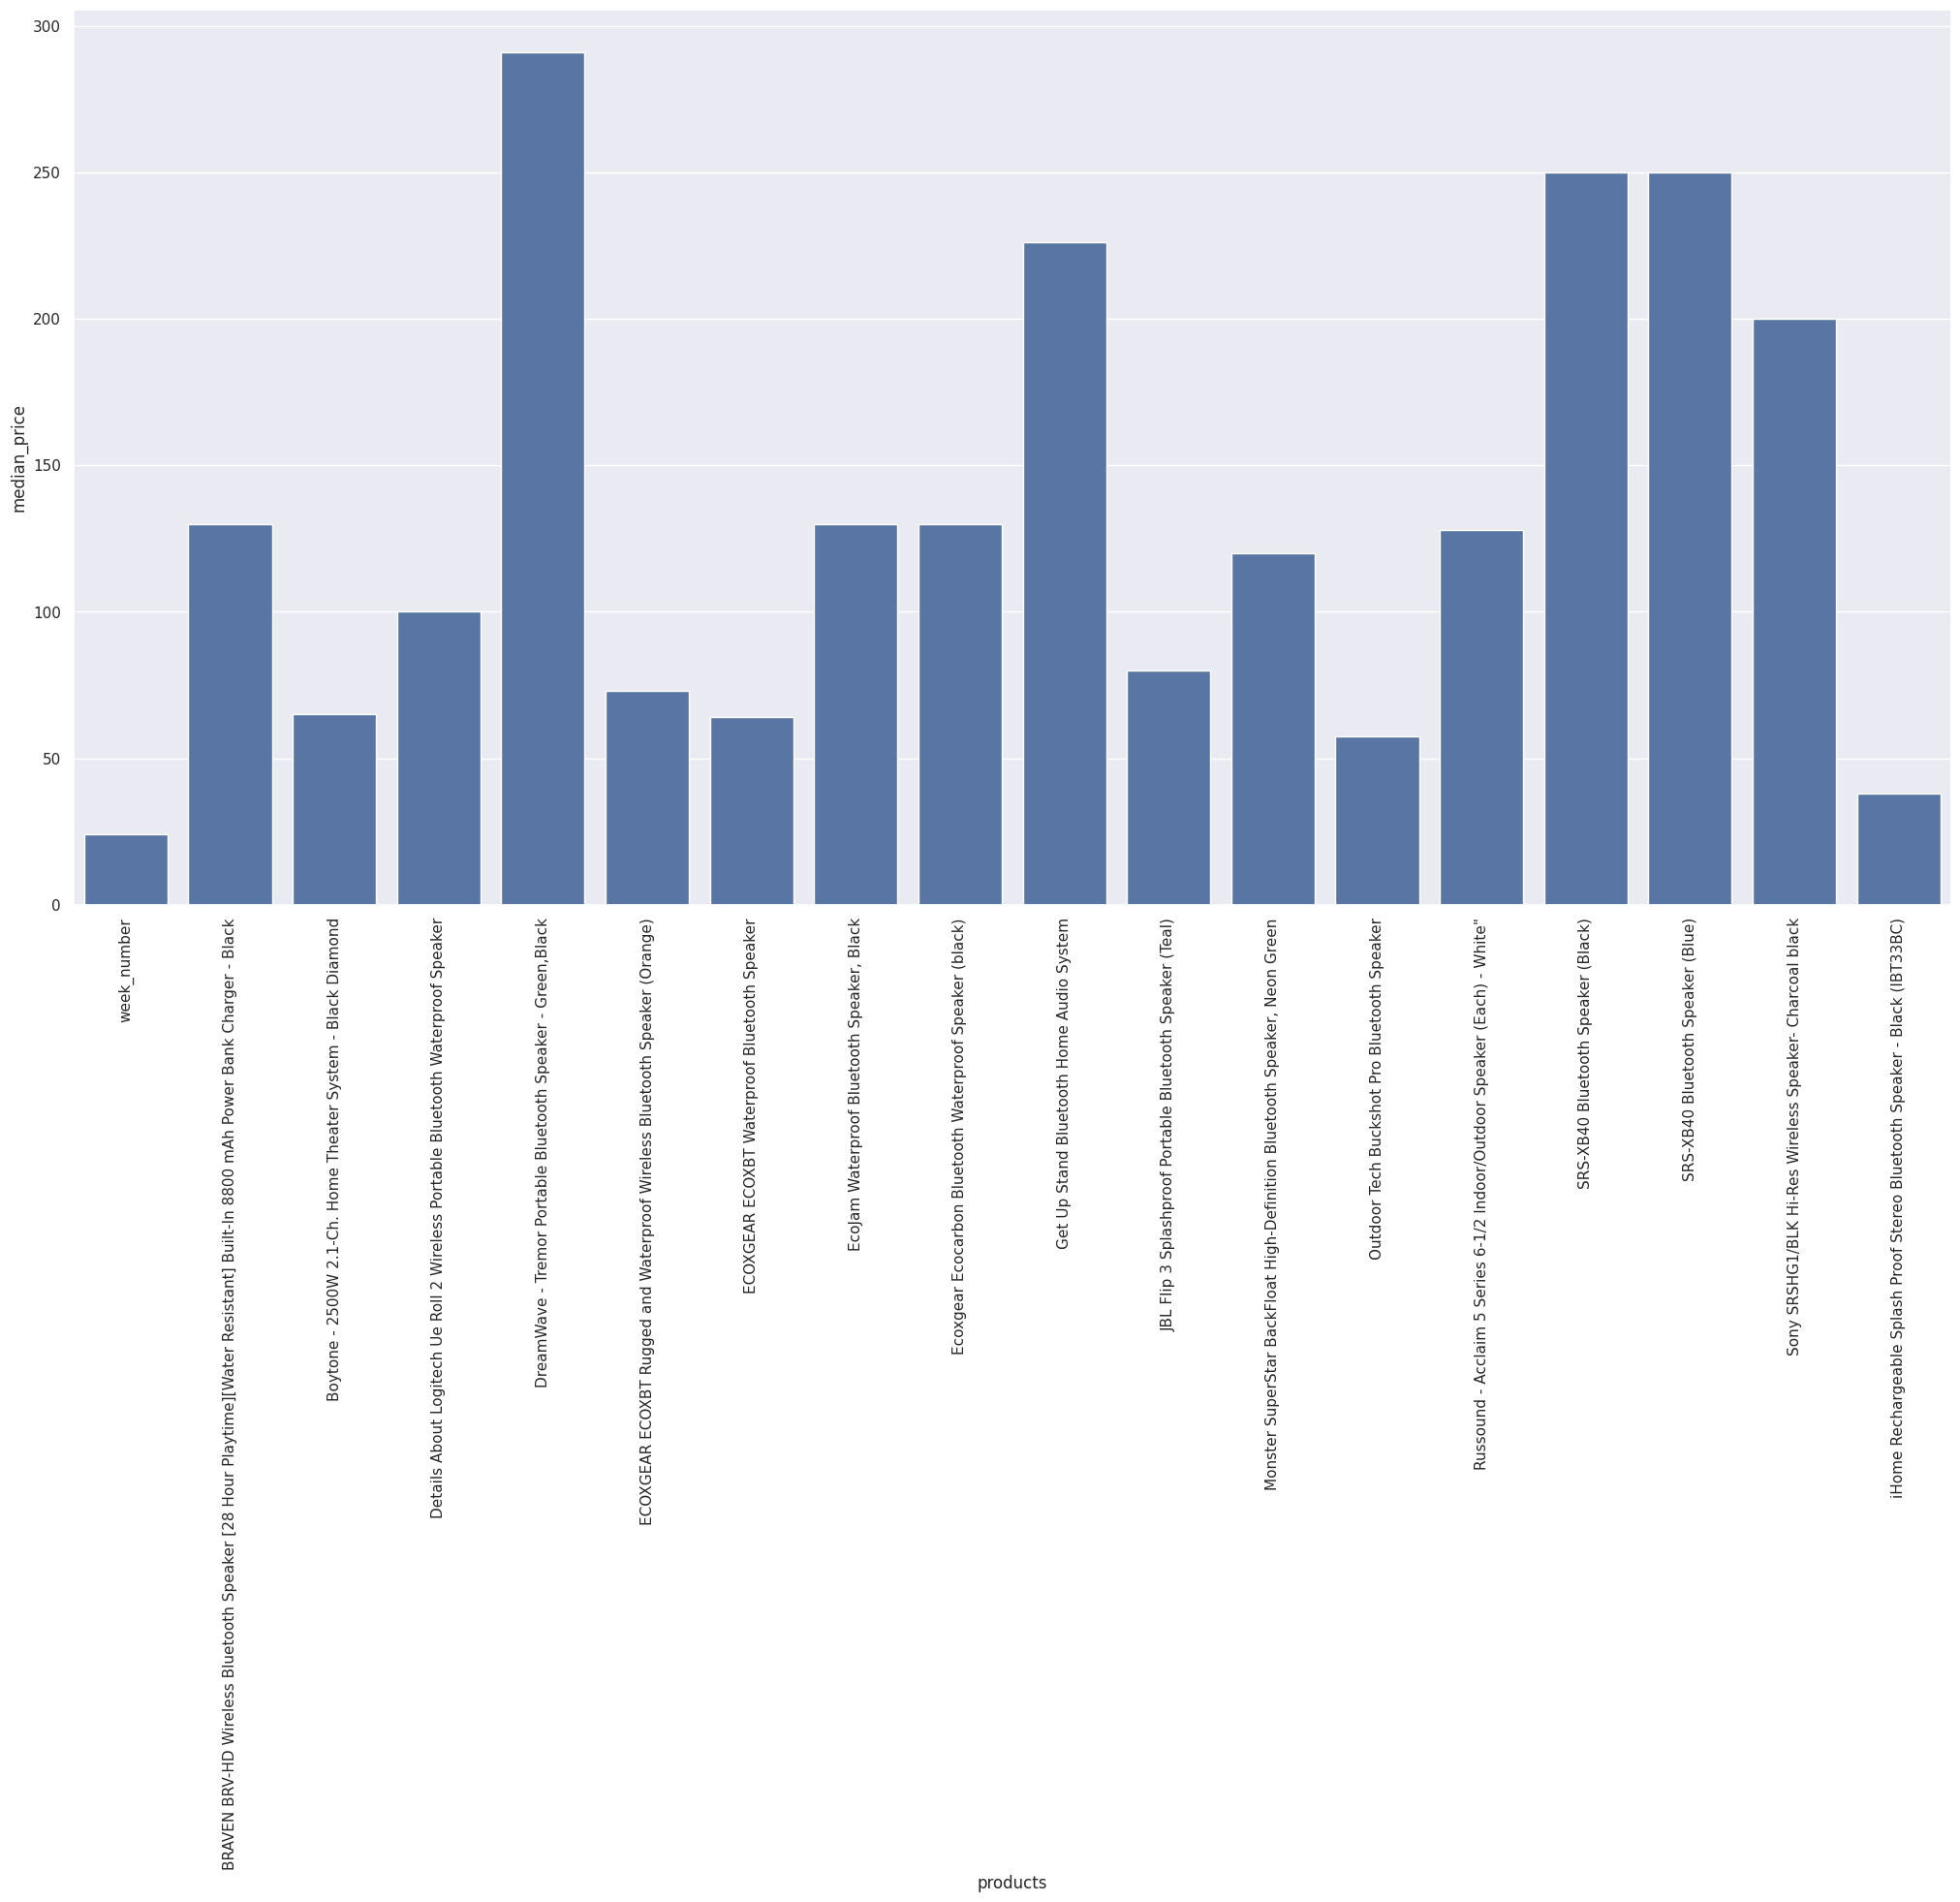

In [ ]:
aux = pd.DataFrame(X_price.apply(lambda x: x.median())).reset_index()
aux.columns = ['products', 'median_price']

#plt.figure(figsize=(30,20))
plt.xticks(rotation=90)
sns.barplot(data=aux, x='products', y='median_price')

<Axes: xlabel='products', ylabel='demand'>

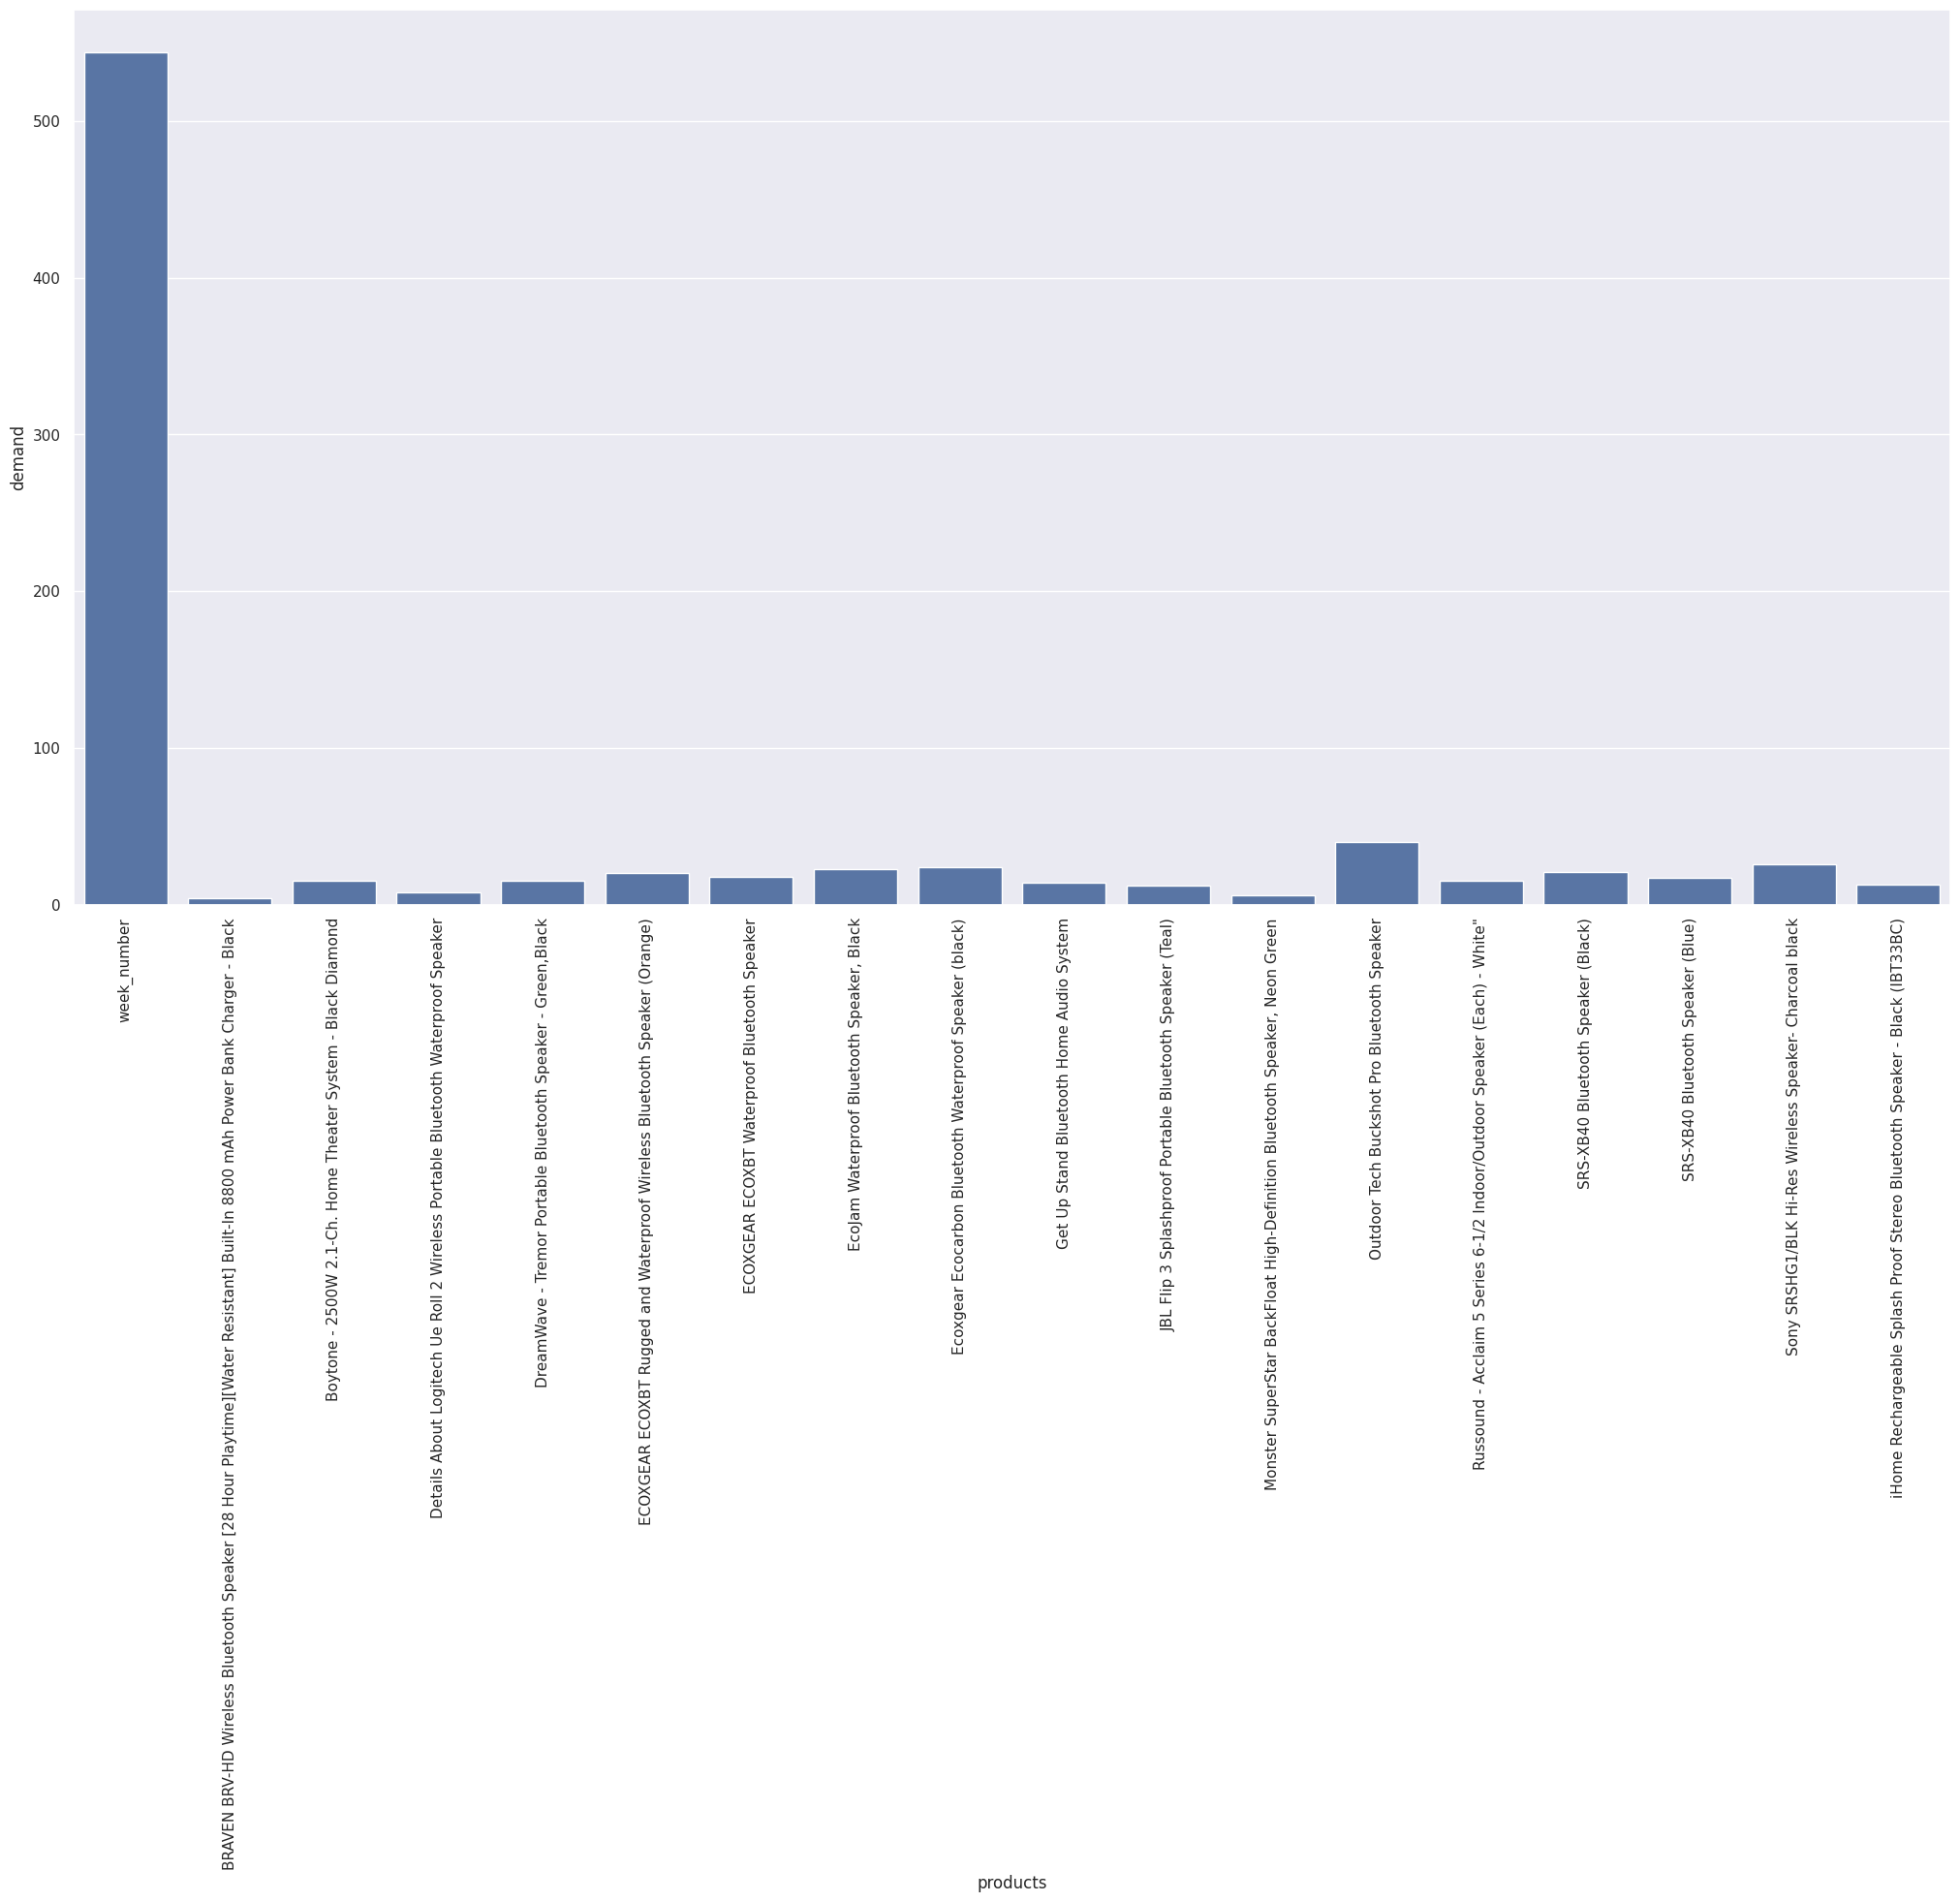

In [ ]:
aux2 = pd.DataFrame(y_demand.apply(lambda x: x.sum())).reset_index()
aux2.columns = ['products', 'demand']

plt.xticks(rotation=90)
sns.barplot(data=aux2, x='products', y='demand')

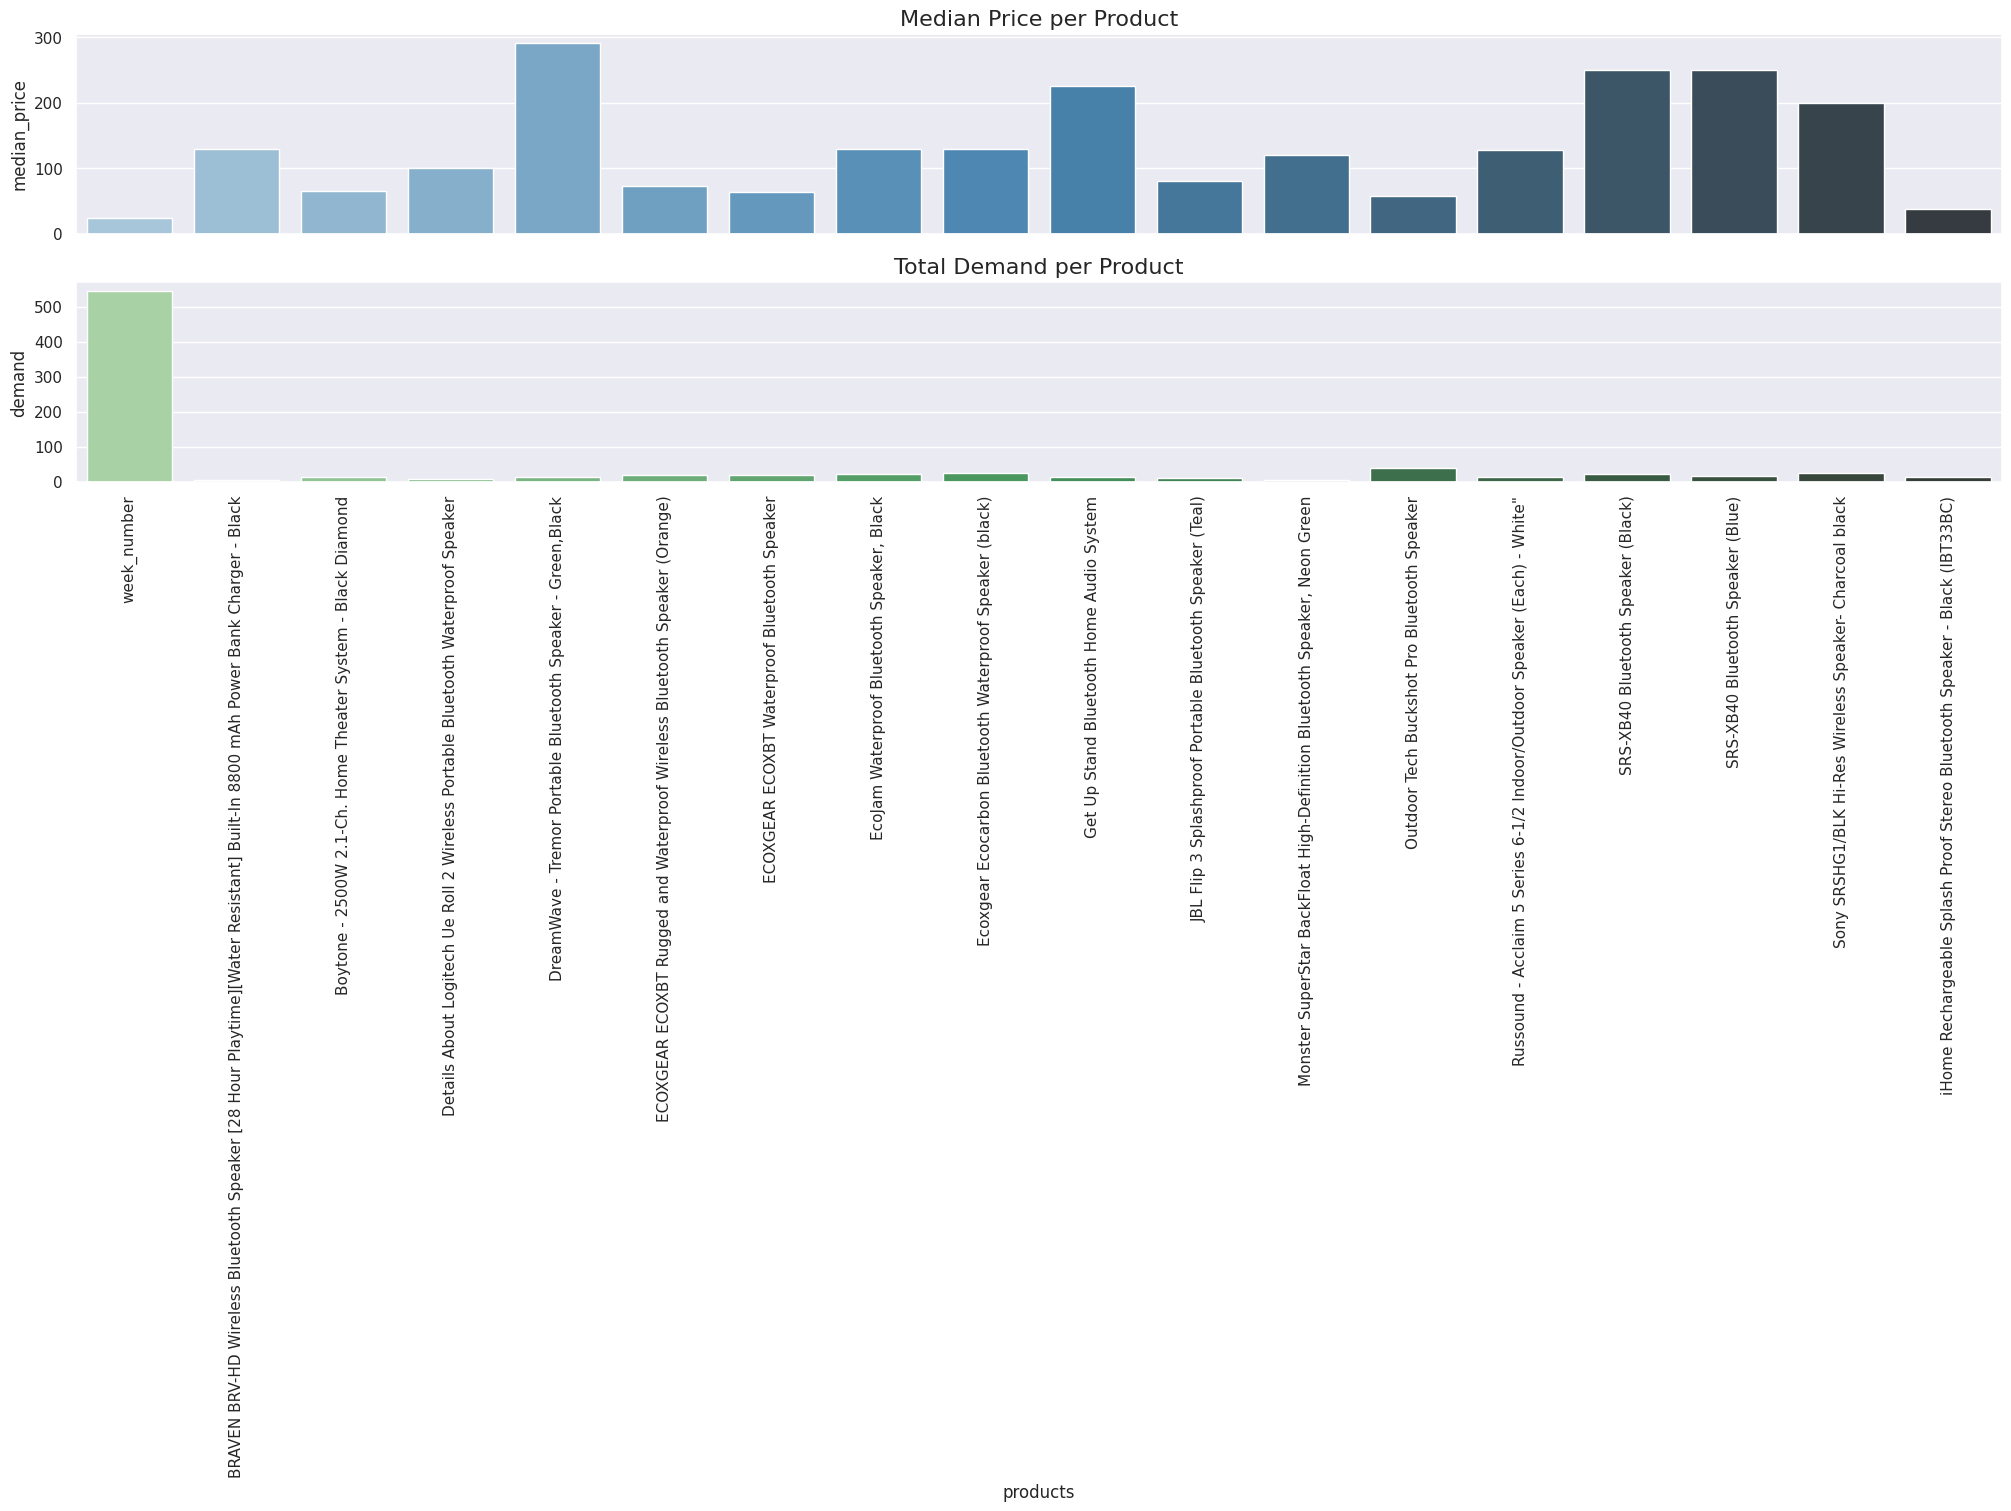

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15), sharex=True, constrained_layout=True)

sns.barplot(ax=axes[0], data=aux, x='products', y='median_price',  hue='products', palette='Blues_d',  legend=False)
axes[0].set_title('Median Price per Product', fontsize=16)
axes[0].tick_params(axis='x', labelbottom=False)  # oculta nomes dos produtos


sns.barplot(ax=axes[1], data=aux2, x='products', y='demand', hue='products', palette='Greens_d', legend=False)
axes[1].set_title('Total Demand per Product', fontsize=16)
axes[1].tick_params(axis='x', rotation=90)

plt.show()

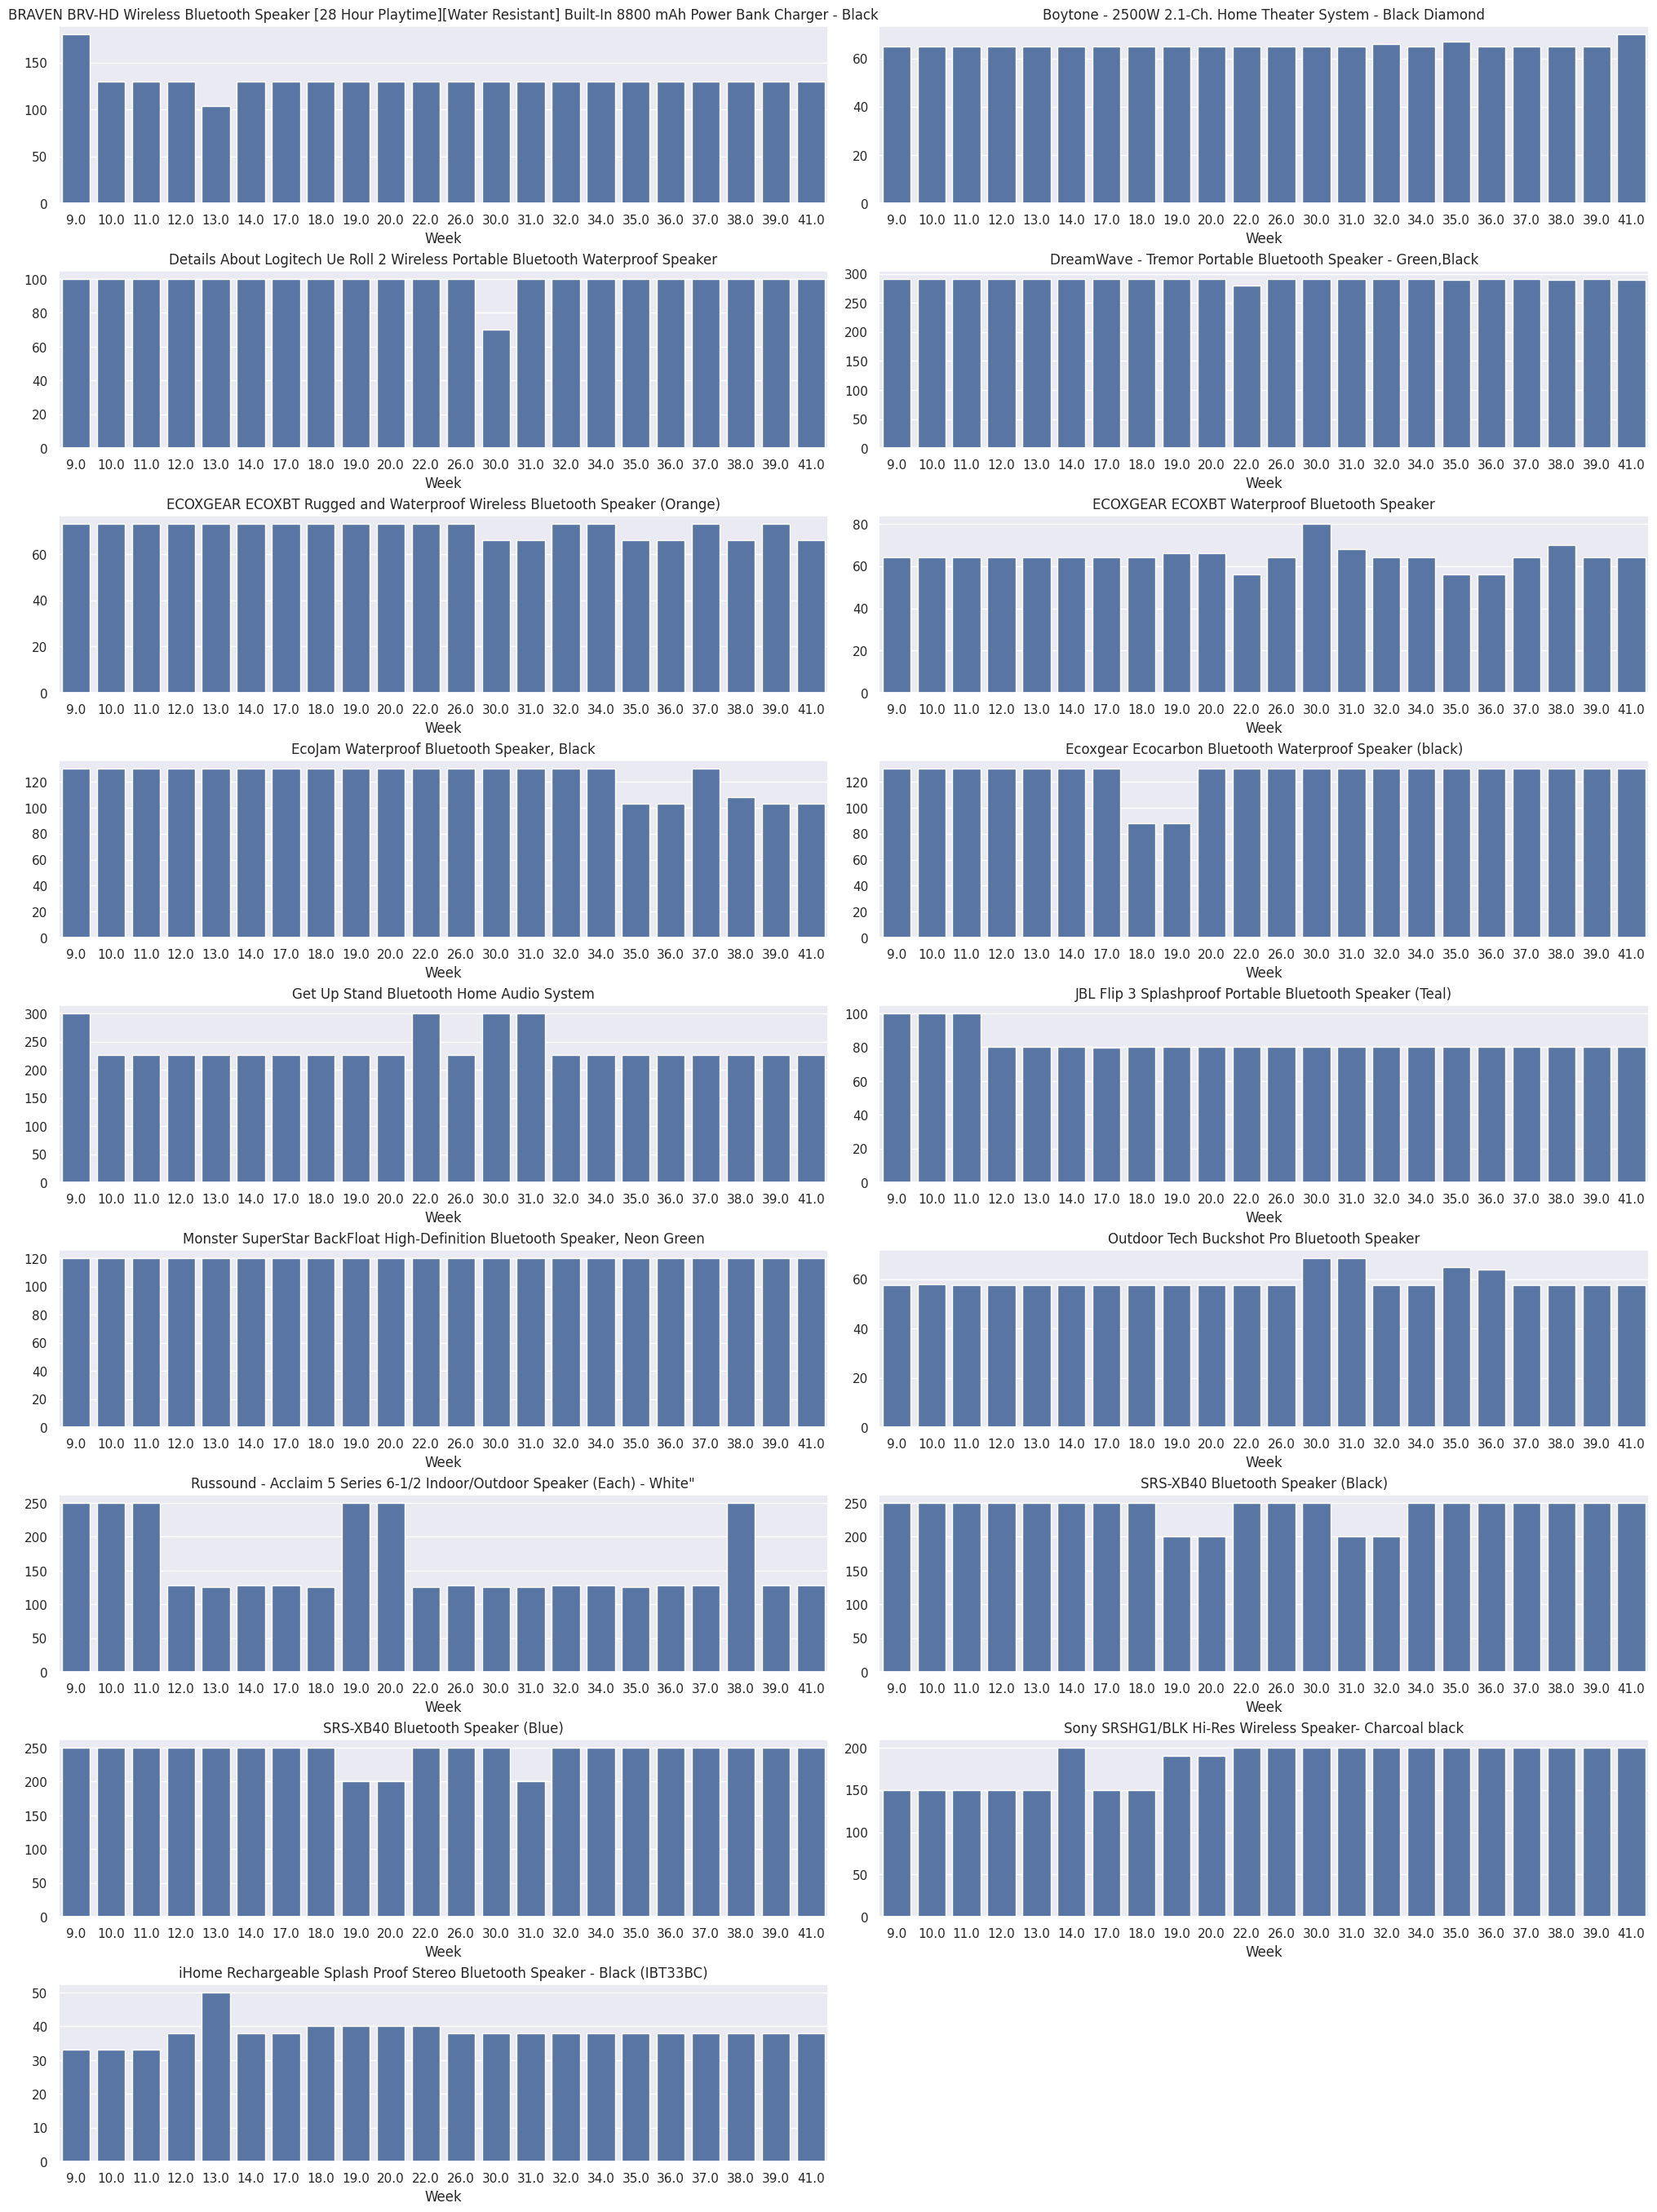

In [ ]:
cols = list(X_price.columns)[1:]  # Ignora a primeira coluna se for 'week_number'
num_plots = len(cols)
n_rows = (num_plots + 1) // 2  # Duas colunas por linha
fig, axes = plt.subplots(n_rows, 2, figsize=(20, n_rows * 3), constrained_layout=True)

axes = axes.flatten()  # Torna o array de eixos 1D para iteração

for i, col in enumerate(cols):
    sns.barplot(ax=axes[i], data=X_price, x='week_number', y=col)
    axes[i].set_title(col)
    axes[i].set_xlabel("Week")
    axes[i].set_ylabel("")

# Esconde subplots extras (se houver)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


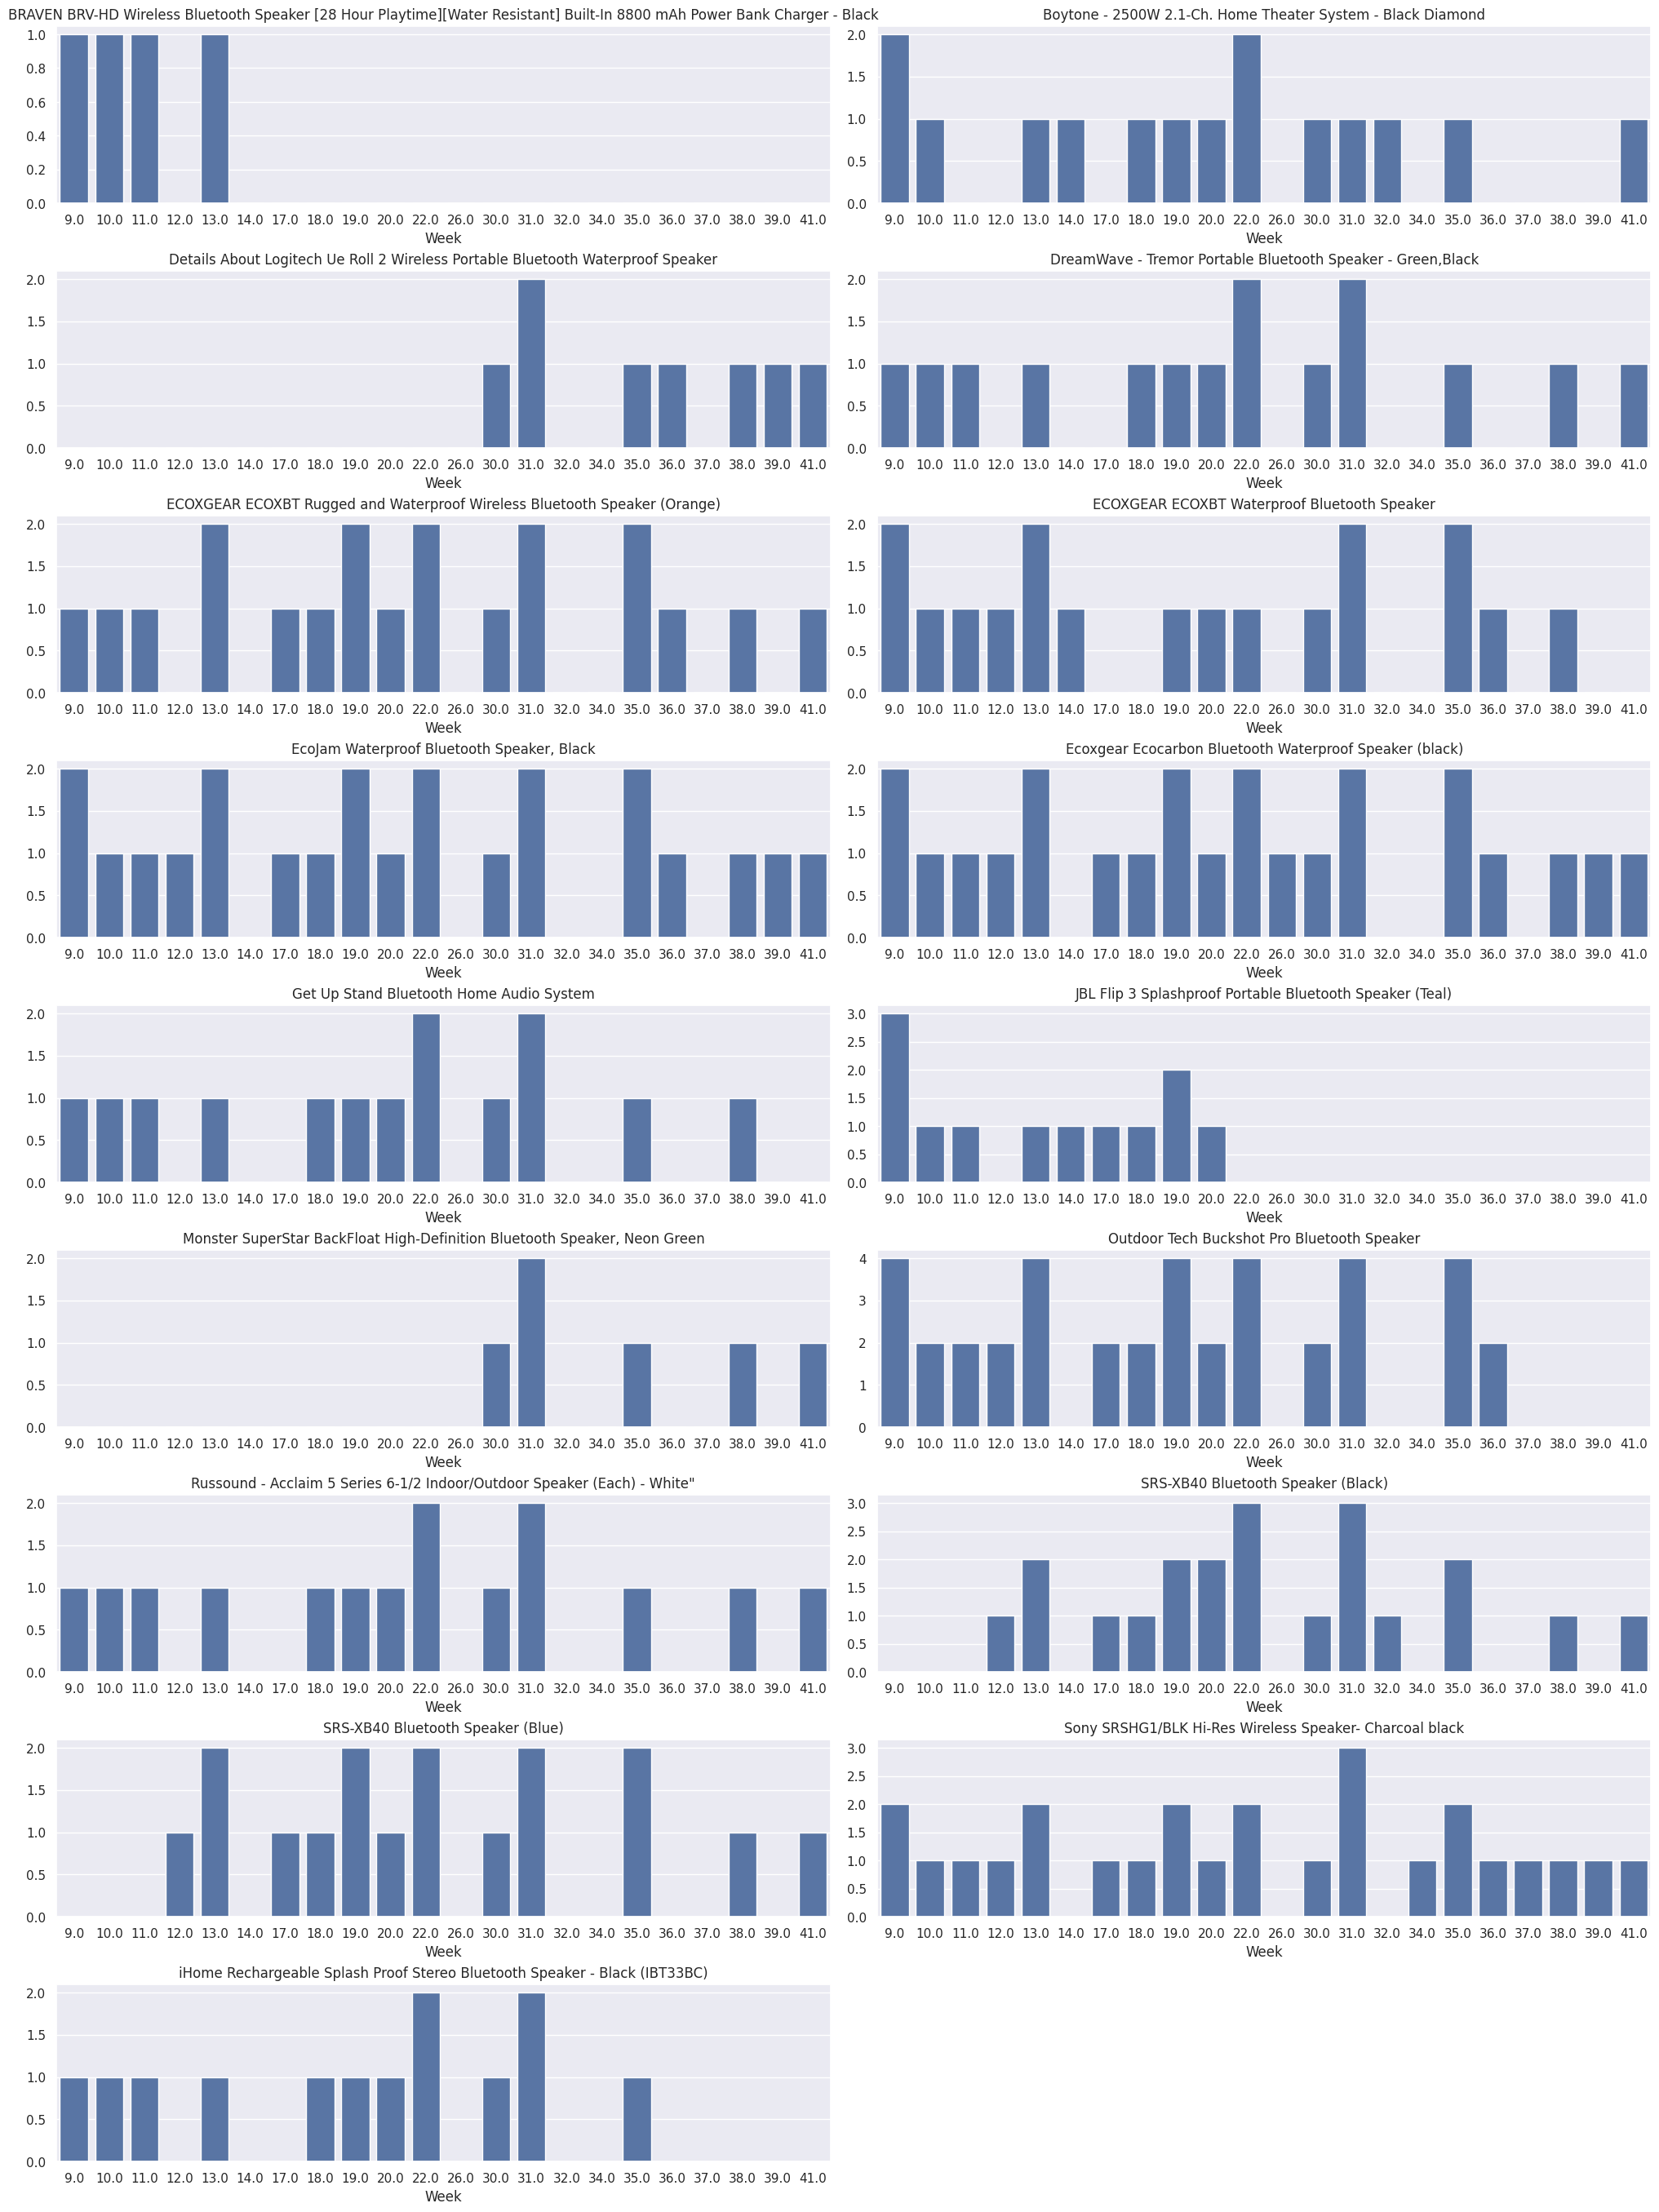

In [ ]:
cols = list(y_demand.columns)[1:]  # Ignora a primeira coluna se for 'week_number'
num_plots = len(cols)
n_rows = (num_plots + 1) // 2  # Duas colunas por linha
fig, axes = plt.subplots(n_rows, 2, figsize=(20, n_rows * 3), constrained_layout=True)

axes = axes.flatten()  # Torna o array de eixos 1D para iteração

for i, col in enumerate(cols):
    sns.barplot(ax=axes[i], data=y_demand, x='week_number', y=col)
    axes[i].set_title(col)
    axes[i].set_xlabel("Week")
    axes[i].set_ylabel("")

# Esconde subplots extras (se houver)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

## Machine Learning

In [ ]:
X_price.head()

week_number  BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond  Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker  DreamWave - Tremor Portable Bluetooth Speaker - Green,Black  ECOXGEAR ECOXBT Rugged and Waterproof Wireless Bluetooth Speaker (Orange)  ECOXGEAR ECOXBT Waterproof Bluetooth Speaker  EcoJam Waterproof Bluetooth Speaker, Black  Ecoxgear Ecocarbon Bluetooth Waterproof Speaker (black)  Get Up Stand Bluetooth Home Audio System  JBL Flip 3 Splashproof Portable Bluetooth Speaker (Teal)  Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green  Outdoor Tech Buckshot Pro Bluetooth Speaker  Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoor Speaker (Each) - White"  SRS-XB40 Bluetooth Speaker (Black)  SRS-XB40 Bluetooth Speaker (Blue)  Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charcoal black  iHome Rechargeable Splash Proof Stereo Bluetooth Speaker - Black (IBT33BC)
0          9.0                                             179.99                                                                                                                      64.99                                                        99.99                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          299.99                                              99.99                                                    119.95                                                                57.49                                             249.99                                                     249.99                             249.99                                             149.99                                                    32.99                         
1         10.0                                             129.99                                                                                                                      64.99                                                        99.99                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          225.99                                              99.99                                                    119.95                                                                57.99                                             249.99                                                     249.99                             249.99                                             149.99                                                    32.99                         
2         11.0                                             129.99                                                                                                                      64.99                                                        99.99                                                                           290.99                                                        72.99                                                                 63.99                                      129.99                                             129.99                                          225.99                                              99.99                                                    119.95                                                                57.49                                      

In [ ]:
y_demand.head()

week_number  BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black  Boytone - 2500W 2.1-Ch. Home Theater System - Black Diamond  Details About Logitech Ue Roll 2 Wireless Portable Bluetooth Waterproof Speaker  DreamWave - Tremor Portable Bluetooth Speaker - Green,Black  ECOXGEAR ECOXBT Rugged and Waterproof Wireless Bluetooth Speaker (Orange)  ECOXGEAR ECOXBT Waterproof Bluetooth Speaker  EcoJam Waterproof Bluetooth Speaker, Black  Ecoxgear Ecocarbon Bluetooth Waterproof Speaker (black)  Get Up Stand Bluetooth Home Audio System  JBL Flip 3 Splashproof Portable Bluetooth Speaker (Teal)  Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green  Outdoor Tech Buckshot Pro Bluetooth Speaker  Russound - Acclaim 5 Series 6-1/2 Indoor/Outdoor Speaker (Each) - White"  SRS-XB40 Bluetooth Speaker (Black)  SRS-XB40 Bluetooth Speaker (Blue)  Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charcoal black  iHome Rechargeable Splash Proof Stereo Bluetooth Speaker - Black (IBT33BC)
0          9.0                                                1.0                                                                                                                        2.0                                                          0.0                                                                              1.0                                                          1.0                                                                   2.0                                         2.0                                                2.0                                             1.0                                                3.0                                                       0.0                                                                  4.0                                                1.0                                                        0.0                                0.0                                                2.0                                                      1.0                         
1         10.0                                                1.0                                                                                                                        1.0                                                          0.0                                                                              1.0                                                          1.0                                                                   1.0                                         1.0                                                1.0                                             1.0                                                1.0                                                       0.0                                                                  2.0                                                1.0                                                        0.0                                0.0                                                1.0                                                      1.0                         
2         11.0                                                1.0                                                                                                                        0.0                                                          0.0                                                                              1.0                                                          1.0                                                                   1.0                                         1.0                                                1.0                                             1.0                                                1.0                                                       0.0                                                                  2.0                                      

#### Product: BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black

In [ ]:
x_tv = X_price['BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black']
y_tv = y_demand['BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black']

X_tv = sm.add_constant(x_tv)

In [ ]:
len(X_price.columns)

18

In [ ]:
model = sm.OLS(y_tv, X_tv)

result = model.fit()
print(result.summary())

                                                                                OLS Regression Results                                                                               
Dep. Variable:     BRAVEN BRV-HD Wireless Bluetooth Speaker [28 Hour Playtime][Water Resistant] Built-In 8800 mAh Power Bank Charger - Black   R-squared:                       0.037
Model:                                                                                                                                   OLS   Adj. R-squared:                 -0.011
Method:                                                                                                                        Least Squares   F-statistic:                    0.7772
Date:                                                                                                                       Mon, 25 Aug 2025   Prob (F-statistic):              0.388
Time:                                                                                     

#### All Products

In [ ]:
def predict_products(X, y):
  df_results = {"name": [],
                "elasticity_price": [],
                "mean_price": [],
                "mean_quantity": [],
                "intercept": [],
                "slope": [],
                "rsquared" : [],
                "p_value": []
                }

  for col in X.columns[1:]:
    #print(col)
    X_product = sm.add_constant(X[col])
    model = sm.OLS(y[col], X_product)
    result = model.fit()

    if (result.f_pvalue < 0.05):
      #print('p value maior qque 0.05')
      rsquared = result.rsquared
      p_value = coefficient = result.f_pvalue
      intercept = result.params.iloc[0]
      slope = result.params.iloc[1]
      mean_price = np.mean(X[col].mean())
      mean_qtd = np.mean(y[col].mean())
      elasticity_price = slope * (mean_price/mean_qtd)

      df_results['name'].append(col)
      df_results['rsquared'].append(rsquared)
      df_results['p_value'].append(p_value)
      df_results['intercept'].append(intercept)
      df_results['slope'].append(slope)
      df_results['mean_price'].append(mean_price)
      df_results['mean_quantity'].append(mean_qtd)
      df_results['elasticity_price'].append(elasticity_price)

  return pd.DataFrame.from_dict(df_results)

In [ ]:
df_elasticity = predict_products(X_price, y_demand)

df_elasticity['ranking'] = df_elasticity.loc[:, 'elasticity_price'].rank(ascending=False).astype(int).reset_index(drop=True)

df_elasticity = df_elasticity.sort_values(by='ranking')

In [ ]:
df_elasticity

name  elasticity_price  mean_price  mean_quantity    intercept      slope  rsquared   p_value  ranking
3  Monster SuperStar BackFloat High-Definition Bl...       8796.600000  119.953636       0.272727 -2398.800000  20.000000  0.182857  0.047127        1
2  JBL Flip 3 Splashproof Portable Bluetooth Spea...          9.838877   82.715455       0.545455    -4.821205   0.064881  0.324317  0.005666        2
1           Get Up Stand Bluetooth Home Audio System          5.367215  239.444545       0.636364    -2.779137   0.014264  0.401111  0.001556        3
4                 SRS-XB40 Bluetooth Speaker (Black)         -6.449468  240.899091       0.954545     7.110856  -0.025556  0.255001  0.016529        4
5                  SRS-XB40 Bluetooth Speaker (Blue)         -6.514696  243.171818       0.772727     5.806811  -0.020702  0.200230  0.036783        5
0  DreamWave - Tremor Portable Bluetooth Speaker ...        -57.183918  290.353636       0.681818    39.670853  -0.134281  0.236558  0.021719        6

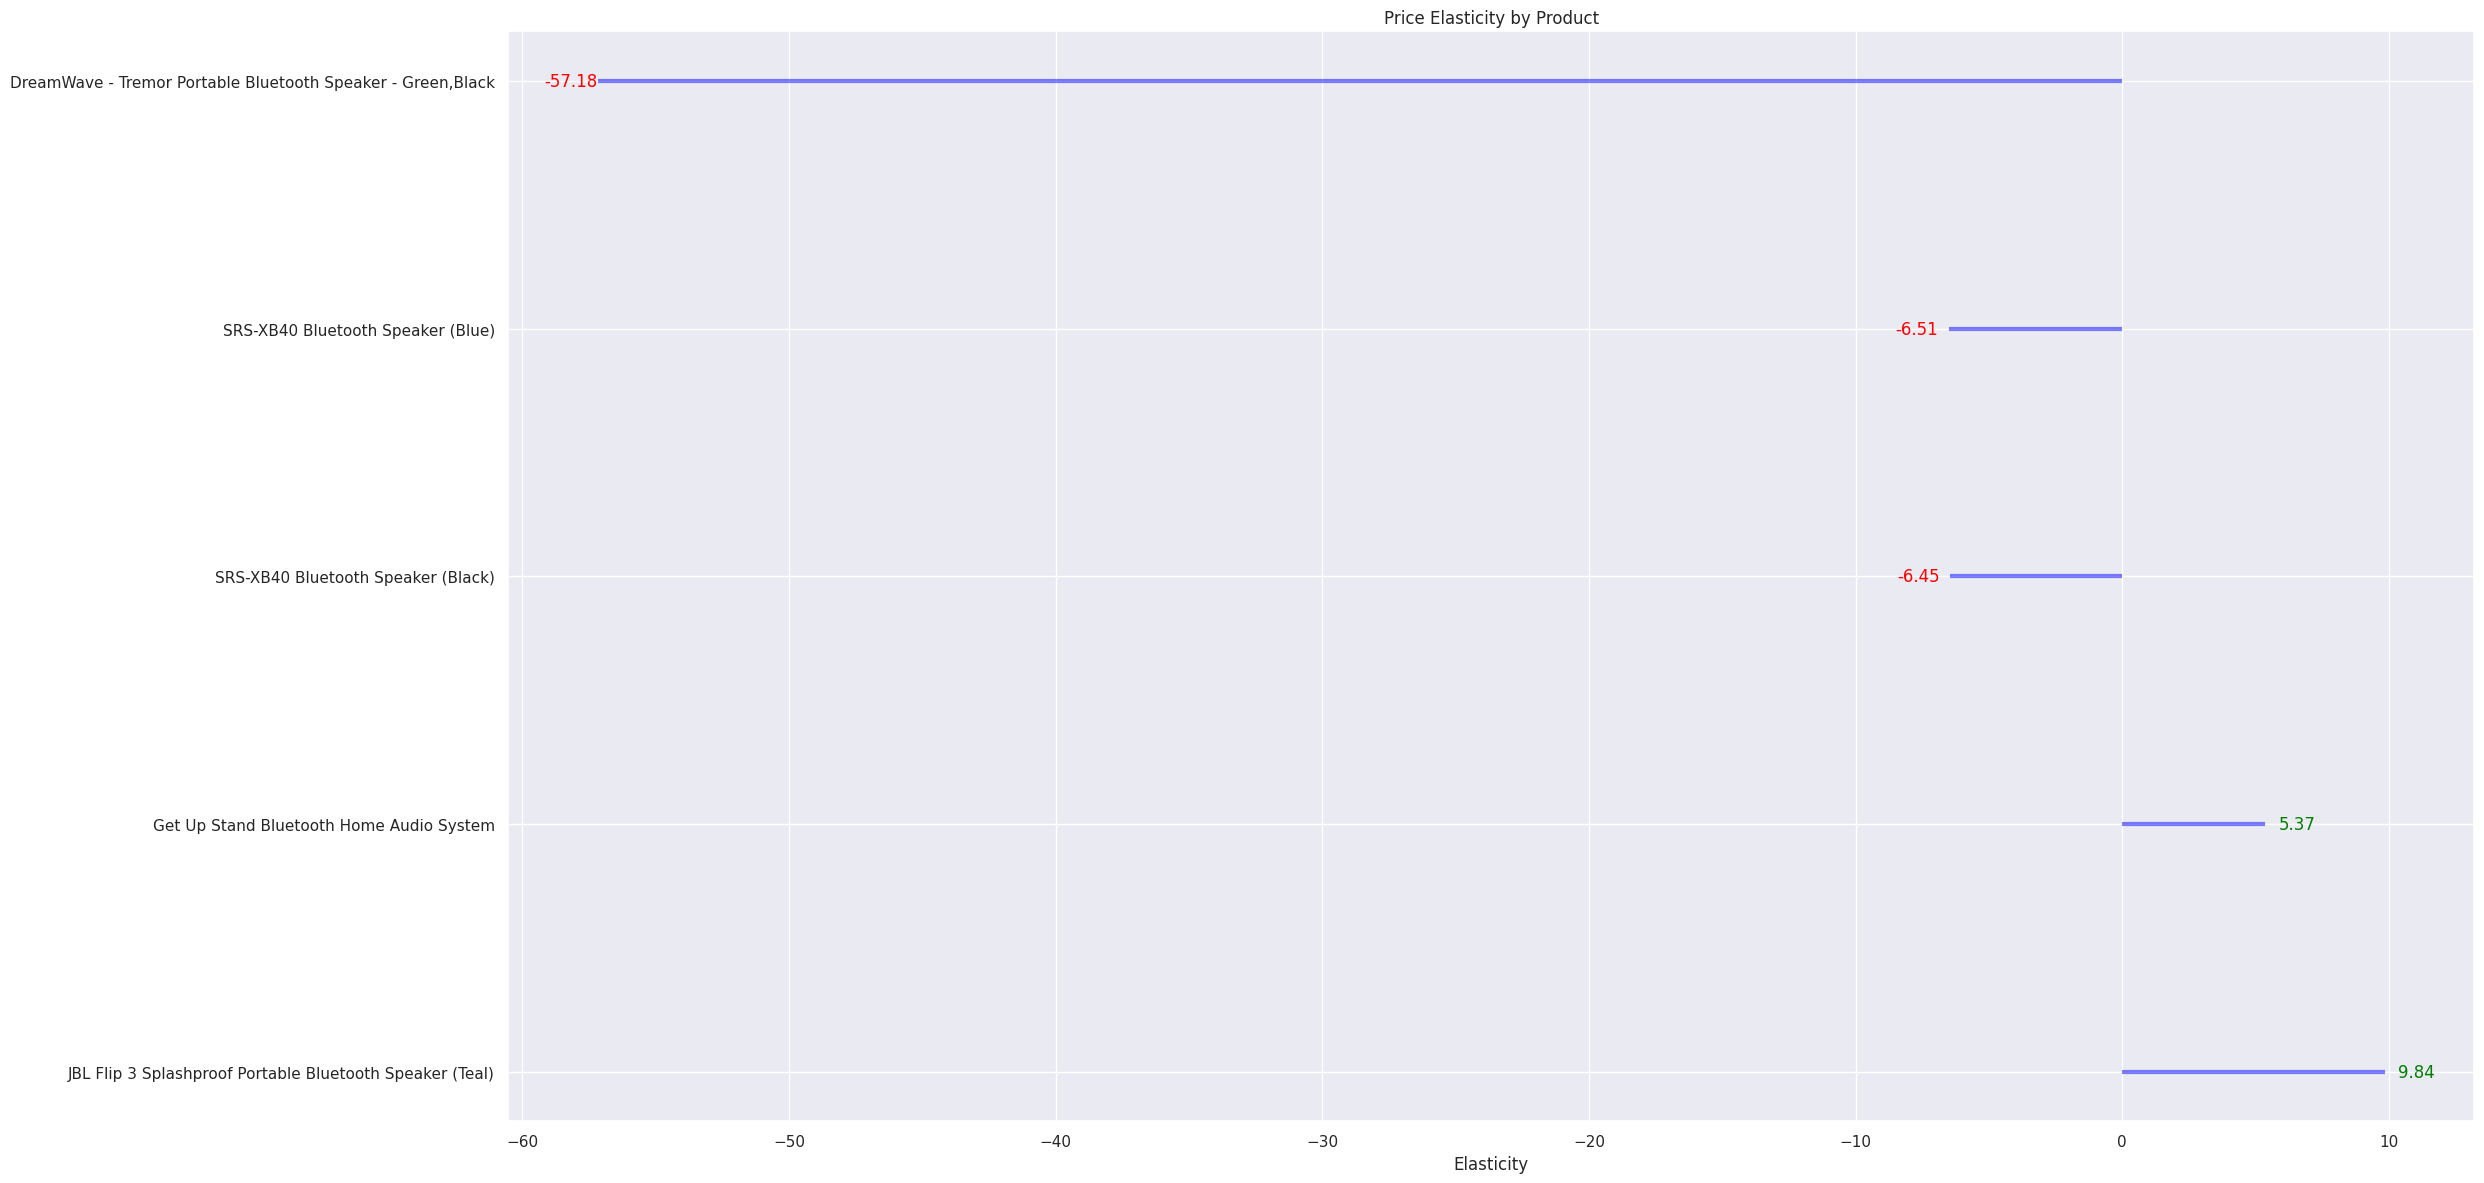

In [ ]:
aux =  df_elasticity[df_elasticity['name'] != 'Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green']

plt.hlines(y=aux['name'], xmin=0, xmax=aux['elasticity_price'], color='blue', alpha=0.5, linewidth=3)

for i, (elasticity, name) in enumerate(zip(aux['elasticity_price'], aux['name'])):
    offset = 0.5 if elasticity >= 0 else -2
    color = 'green' if elasticity >= 0 else 'red'
    plt.text(elasticity + offset, i, f"{elasticity:.2f}", va='center', color=color)

plt.xlabel('Elasticity')
plt.title('Price Elasticity by Product')
plt.tight_layout()
plt.show()

Elasticity per Product

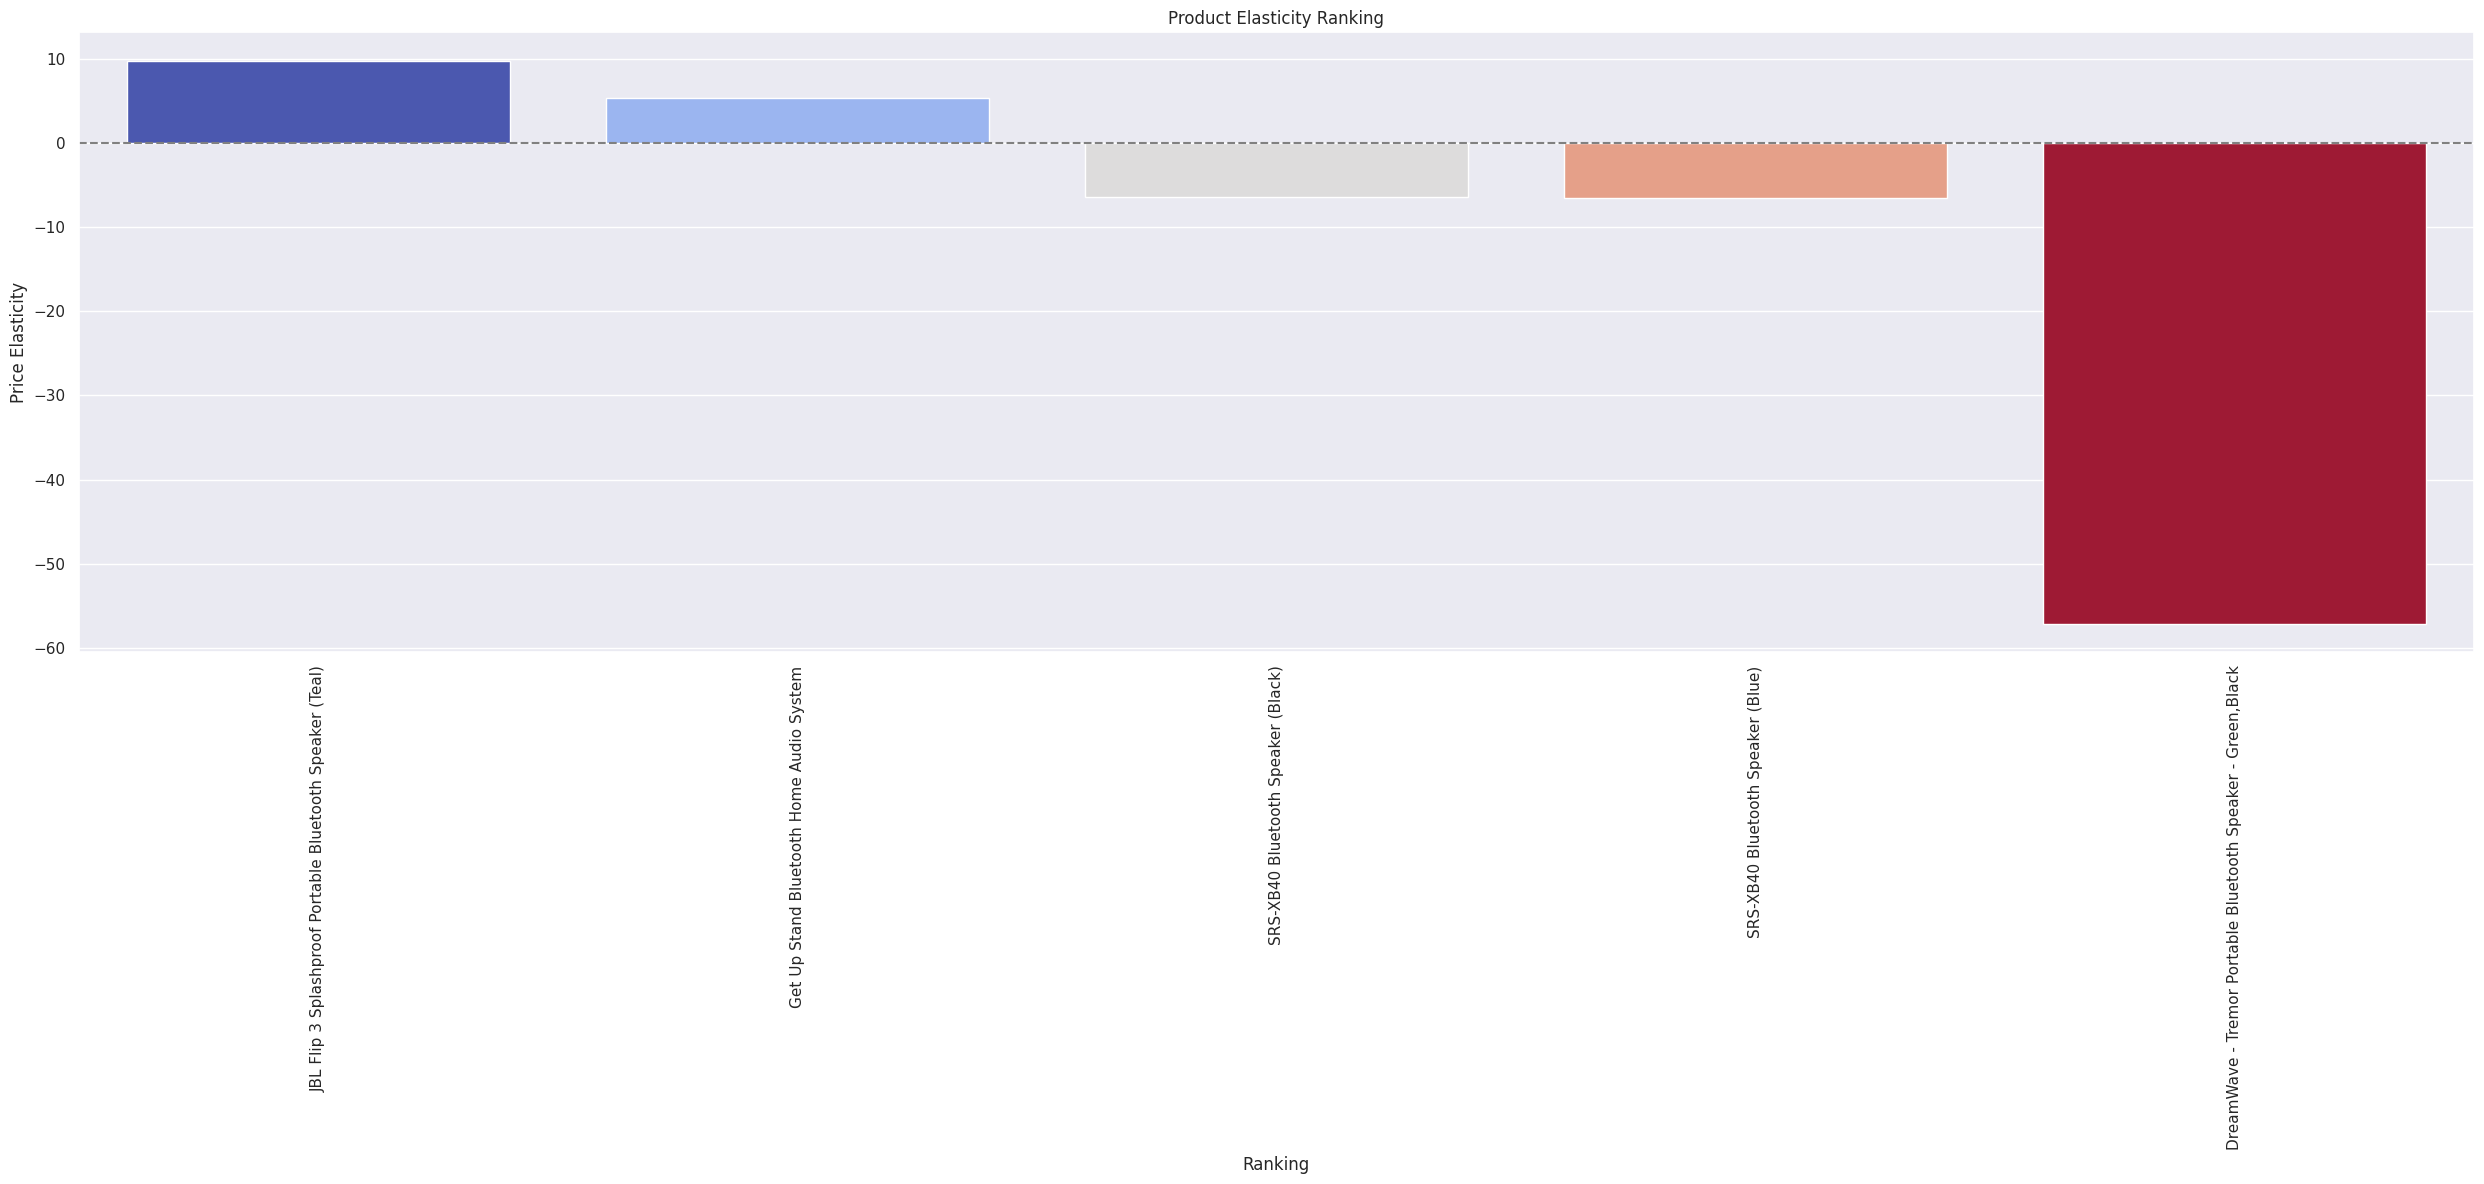

In [ ]:
sns.barplot(data=aux, x='ranking', y='elasticity_price', palette='coolwarm', hue='ranking', legend=False)
plt.title('Product Elasticity Ranking')
plt.xlabel('Ranking')
plt.ylabel('Price Elasticity')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(ticks=range(len(aux)), labels=aux['name'], rotation=90)
plt.tight_layout()
plt.show()

Mean Price x Elasticity

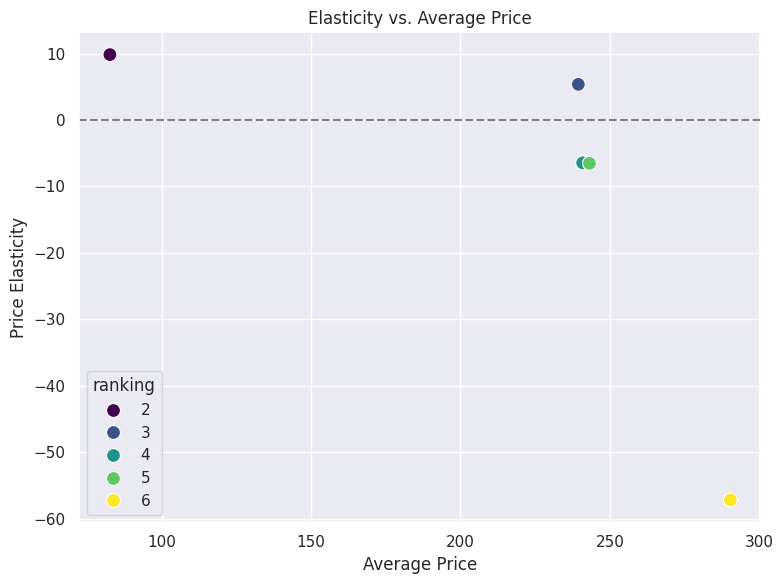

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=aux, x='mean_price', y='elasticity_price', hue='ranking', palette='viridis', s=100)
plt.title('Elasticity vs. Average Price')
plt.xlabel('Average Price')
plt.ylabel('Price Elasticity')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Mean Quantify x Elasticity

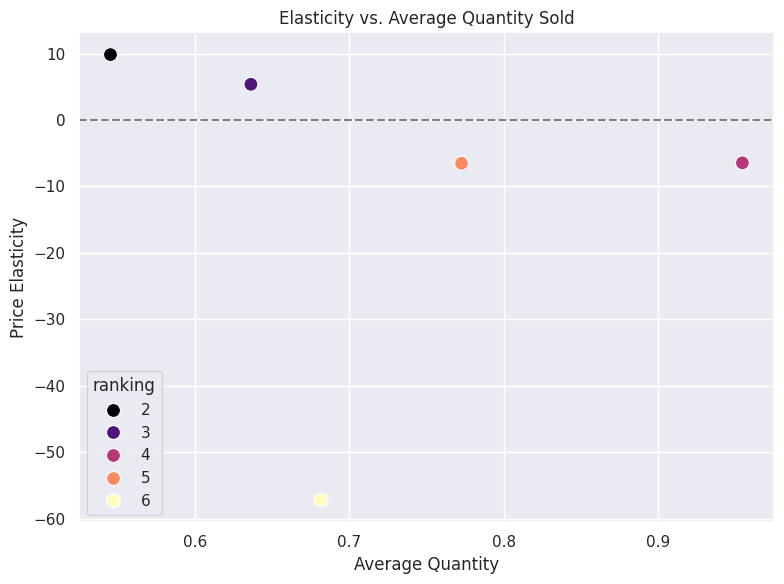

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=aux, x='mean_quantity', y='elasticity_price', hue='ranking', palette='magma', s=100)
plt.title('Elasticity vs. Average Quantity Sold')
plt.xlabel('Average Quantity')
plt.ylabel('Price Elasticity')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

## Business Performance

In [ ]:
df_elasticity = df_elasticity.loc[df_elasticity['name'] != 'Monster SuperStar BackFloat High-Definition Bluetooth Speaker, Neon Green']

In [ ]:
df_elasticity.to_csv('df_elasticity.csv')

#### Simulating the Impact of Price Changes on Invoicing

After identifying the products with significant price elasticity, we simulate how changes in pricing could affect the total revenue (invoicing) of each product.

The function below calculates the adjusted invoicing by considering:

* The percentage change applied to the product's price (increase or reduction)

* The expected response in demand, according to the estimated elasticity

* The resulting difference in revenue compared to the current scenario

This simulation can be performed using two different approaches:

* Per-product average values (use_mean=True) — a simplified method using overall means

* Time series-based calculations (use_mean=False) — a more granular method that accounts for weekly price and demand variations

This analysis supports pricing decisions by showing whether a price change is likely to increase or decrease total revenue, and by how much.

In [ ]:
def simulate_invoicing(df_elasticity, X_price, y_demand, variation_pct, use_mean=False):
    result_invoicing = {
        'name': [],
        'actual_invoicing': [],
        'new_invoicing': [],
        'loss_invoicing': [],
        'variation_invoicing': [],
        'variation_percent': [],
        'reduction_only_invoicing': []
    }

    for row in df_elasticity.itertuples():
        name = row.name
        elasticity = row.elasticity_price

        if name in X_price.columns and name in y_demand.columns:
            price_series = X_price[name]
            demand_series = y_demand[name]

            if use_mean:
                # Abordagem agregada
                mean_price = price_series.mean()
                total_demand = demand_series.sum()

                reduced_price = mean_price * (1 + variation_pct)
                demand_increase_pct = elasticity * variation_pct
                new_demand = total_demand * (1 + demand_increase_pct)

                actual_invoicing = mean_price * total_demand
                new_invoicing = reduced_price * new_demand
                reduction_only_invoicing = mean_price * total_demand * (1 + variation_pct)
            else:
                # Abordagem linha a linha (vetorizada)
                new_price = price_series * (1 + variation_pct)
                new_demand = demand_series * (1 + (elasticity * variation_pct))

                actual_invoicing = (price_series * demand_series).sum()
                new_invoicing = (new_price * new_demand).sum()
                reduction_only_invoicing = (price_series * (1 + variation_pct) * demand_series).sum()

            variation = new_invoicing - actual_invoicing
            variation_pct_result = (variation / actual_invoicing) * 100

            result_invoicing['name'].append(name)
            result_invoicing['actual_invoicing'].append(round(actual_invoicing, 2))
            result_invoicing['new_invoicing'].append(round(new_invoicing, 2))
            result_invoicing['loss_invoicing'].append(round(abs(variation), 2) if variation < 0 else 0)
            result_invoicing['variation_invoicing'].append(round(variation, 2))
            result_invoicing['variation_percent'].append(round(variation_pct_result, 2))
            result_invoicing['reduction_only_invoicing'].append(round(reduction_only_invoicing, 2))

    return pd.DataFrame(result_invoicing)


#### Invoicing Impact Simulation

After calculating the price elasticity, we simulate how a change in price would affect each product's total revenue.
This simulation considers:

* The expected change in demand due to price elasticity

* The resulting adjusted invoicing after the change

*  The difference compared to the current invoicing

The following function provides a narrative output that helps decision-makers interpret whether the price adjustment leads to an expected increase or decrease in revenue.

In [ ]:
def print_invoicing_summary(df_invoicing, pct):
    # Determina o tipo de variação
    tipo_preco = "redução" if pct < 0 else "aumento"
    valor_pct = abs(pct * 100)

    for row in df_invoicing.itertuples():
        name = row.name
        faturamento_atual = row.actual_invoicing
        faturamento_simples = row.reduction_only_invoicing
        faturamento_novo = row.new_invoicing

        variacao_abs = faturamento_novo - faturamento_atual
        variacao_pct = (variacao_abs / faturamento_atual) * 100

        print(f"📦 **{name}**")
        print(f"• The current invoicing is R$ {faturamento_atual:.2f}.")
        print(f"• With a {tipo_preco} of {valor_pct:.0f}%, without considering changes in demand, the invoicing would be R$ {faturamento_simples:.2f}, meaning a {'decrease' if tipo_preco == 'redução' else 'increase'} of R$ {abs(faturamento_atual - faturamento_simples):.2f}.")

        if variacao_abs > 0:
            print(f"• However, considering the impact of elasticity on demand, the new invoicing would be R$ {faturamento_novo:.2f}, representing an **increase** of R$ {variacao_abs:.2f} ({variacao_pct:.2f}%).\n")
        elif variacao_abs < 0:
            print(f"• Even after accounting for elasticity, the new invoicing would be R$ {faturamento_novo:.2f}, representing a **reduction** of R$ {abs(variacao_abs):.2f} ({abs(variacao_pct):.2f}%).\n")
        else:
            print(f"• Even after accounting for elasticity, the invoicing would remain unchanged.\n")



In [ ]:
pct = 0.10

df_invoicing = simulate_invoicing(df_elasticity, X_price, y_demand, variation_pct=pct, use_mean=False)
df_invoicing

name  actual_invoicing  new_invoicing  loss_invoicing  variation_invoicing  variation_percent  reduction_only_invoicing
0  JBL Flip 3 Splashproof Portable Bluetooth Spea...           1059.84        2312.86            0.00              1253.02             118.23                   1165.82
1           Get Up Stand Bluetooth Home Audio System           3607.86        6098.70            0.00              2490.84              69.04                   3968.65
2                 SRS-XB40 Bluetooth Speaker (Black)           4849.79        1894.13         2955.66             -2955.66             -60.94                   5334.77
3                  SRS-XB40 Bluetooth Speaker (Blue)           3999.83        1533.47         2466.36             -2466.36             -61.66                   4399.81
4  DreamWave - Tremor Portable Bluetooth Speaker ...           4339.85      -22524.82        26864.67            -26864.67            -619.02                   4773.83

In [ ]:
df_invoicing.to_csv('business_performance.csv')

In [ ]:
print_invoicing_summary(df_invoicing, pct=pct)

📦 **JBL Flip 3 Splashproof Portable Bluetooth Speaker (Teal)**
• The current invoicing is R$ 1059.84.
• With a aumento of 15%, without considering changes in demand, the invoicing would be R$ 1218.82, meaning a increase of R$ 158.98.
• However, considering the impact of elasticity on demand, the new invoicing would be R$ 3017.58, representing an **increase** of R$ 1957.74 (184.72%).

📦 **Get Up Stand Bluetooth Home Audio System**
• The current invoicing is R$ 3607.86.
• With a aumento of 15%, without considering changes in demand, the invoicing would be R$ 4149.04, meaning a increase of R$ 541.18.
• However, considering the impact of elasticity on demand, the new invoicing would be R$ 7489.36, representing an **increase** of R$ 3881.50 (107.58%).

📦 **SRS-XB40 Bluetooth Speaker (Black)**
• The current invoicing is R$ 4849.79.
• With a aumento of 15%, without considering changes in demand, the invoicing would be R$ 5577.26, meaning a increase of R$ 727.47.
• Even after accounting for el

This notebook demonstrates how data-driven pricing strategies can be enhanced through elasticity analysis and revenue simulations.

By identifying which products are more price-sensitive, businesses can:

Avoid revenue losses from unnecessary price increases

Strategically apply discounts where demand is highly elastic

Maximize profit by aligning pricing with consumer responsiveness

This type of analysis helps bridge the gap between statistical modeling and real business impact, making it a valuable asset in any data science portfolio focused on e-commerce or retail analytics.

#### Cross Elasticity

In [ ]:
def crossprice(df_x, df_y, column_name):
    # Copiar preços e adicionar coluna de demanda do produto-alvo
    df = df_x.copy()
    df['target_demand'] = df_y[column_name]

    # Definir variáveis independentes (todos os preços menos a 1ª coluna se for índice/ID)
    X = sm.add_constant(df.iloc[:, 1:-1])
    y = df['target_demand']

    # Regressão linear
    model = sm.OLS(y, X, missing='drop')
    result = model.fit()

    # Recuperar coeficientes e p-valores
    coefs = result.params
    pvals = result.pvalues

    # Calcular médias
    mean_price = df.iloc[:, 1:-1].mean()
    mean_demand = y.mean()

    # Calcular elasticidade-preço cruzada
    elasticity = (coefs * mean_price / mean_demand).round(4)

    # Montar DataFrame com resultado
    df_result = pd.DataFrame({
        'name': elasticity.index,
        'cross_elasticity': elasticity.values,
        'p_value': pvals.values
    })

    # Remover constante (intercepto)
    df_result = df_result[df_result['name'] != 'const']

    # Filtrar por significância
    df_result = df_result[df_result['p_value'] < 0.05]

    # Marcar efeitos significativos
    df_result[column_name + '_CPE'] = np.where(
        df_result['p_value'] <= 0.05,
        df_result['cross_elasticity'],
        'No Effect'
    )

    return df_result[['name', column_name + '_CPE']]


In [ ]:
result_df = pd.DataFrame()
for column in X_price.columns[1:]:
    result_df[['name', column +'CPE']] = crossprice(X_price, y_demand, column)

result_df = result_df.set_index('name')


In [ ]:
result_df.to_csv('cross_price.csv')

In [ ]:
lista_de_produtos = X_price.columns
resultados = []

for produto in lista_de_produtos:
    df_elast = crossprice(X_price, y_demand, produto)
    resultados.append(df_elast.rename(columns={produto + 'CPE': produto}))

# Unir todos os resultados na forma de matriz
cross_elasticity_matrix = resultados[0]
for df in resultados[1:]:
    cross_elasticity_matrix = pd.merge(cross_elasticity_matrix, df, on='name', how='outer')

# Remover onde não é número (ou opcionalmente manter apenas p-valores significativos)
cross_elasticity_matrix_filtered = cross_elasticity_matrix.copy()
for col in cross_elasticity_matrix_filtered.columns[1:]:
    cross_elasticity_matrix_filtered[col] = pd.to_numeric(cross_elasticity_matrix_filtered[col], errors='coerce')


In [ ]:
def get_top_cross_elasticities(cross_elasticity_matrix_filtered, top_n=20):
    """
    Retorna os N pares de produtos com maior elasticidade-preço cruzada (em valor absoluto),
    considerando apenas relações com p-valor significativo (< 0.05).
    """
    melted = cross_elasticity_matrix_filtered.melt(
        id_vars='name', var_name='preco_de', value_name='elasticidade'
    )
    melted = melted.dropna()
    melted['abs_elasticidade'] = melted['elasticidade'].abs()
    melted = melted.sort_values(by='abs_elasticidade', ascending=False).reset_index(drop=True)
    return melted.head(top_n)


In [ ]:
def analyze_product_relationships(cross_elasticity_matrix_filtered, product_name, top_n=5):
    """
    Retorna os principais produtos cujo preço impacta a demanda do produto especificado.
    Classifica as relações como Substituto (elasticidade > 0) ou Complementar (elasticidade < 0).
    """
    melted = cross_elasticity_matrix_filtered.melt(
        id_vars='name', var_name='preco_de', value_name='elasticidade'
    )
    melted = melted.dropna()
    melted['abs_elasticidade'] = melted['elasticidade'].abs()

    relacoes = melted[melted['name'] == product_name].copy()
    relacoes['tipo_relacao'] = relacoes['elasticidade'].apply(
        lambda x: 'Substituto' if x > 0 else 'Complementar'
    )
    relacoes = relacoes.sort_values(by='abs_elasticidade', ascending=False)
    return relacoes[['preco_de', 'elasticidade', 'tipo_relacao']].head(top_n)


In [ ]:
# Top 15 pares mais relevantes
top_15 = get_top_cross_elasticities(cross_elasticity_matrix_filtered, top_n=15)
top_15

top_15.to_csv('15_pares_mais_relevantes.csv')

In [ ]:
# Analisar impacto cruzado em um produto específico
produto = "ECOXGEAR ECOXBT Rugged and Waterproof Wireless Bluetooth Speaker (Orange)"
relacoes = analyze_product_relationships(cross_elasticity_matrix_filtered, produto, top_n=5)
relacoes

preco_de  elasticidade  tipo_relacao
148       Get Up Stand Bluetooth Home Audio System_CPE      -84.7536  Complementar
276  iHome Rechargeable Splash Proof Stereo Bluetoo...      -82.7427  Complementar
180  Monster SuperStar BackFloat High-Definition Bl...      -76.8790  Complementar
68   DreamWave - Tremor Portable Bluetooth Speaker ...      -71.7104  Complementar
212  Russound - Acclaim 5 Series 6-1/2 Indoor/Outdo...      -71.7104  Complementar